In [1]:
%%latex
\tableofcontents

<IPython.core.display.Latex object>

# Methods

- We will build models reflecting three levels of available data
    - "Easy" is mostly data already available to the emergency dispatcher before the notification comes in, like month, day of week, hour, weather, urban/rural, 

# Setup

## Import Libraries

In [2]:
print ('Install Packages')

import sys, copy, math, time, os

print ('Python version: {}'.format(sys.version))

#from collections import Counter

import numpy as np
print ('NumPy version: {}'.format(np.__version__))
np.set_printoptions(suppress=True)

import scipy as sc
print ('SciPy version:  {}'.format(sc.__version__))

import tensorflow as tf
print ('TensorFlow version:  {}'.format(tf.__version__))
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

from tensorflow import keras
print ('Keras version:  {}'.format(keras.__version__))

from keras import layers
import keras.backend as K
#from keras.layers import IntegerLookup
#from keras.layers import Normalization
#from keras.layers import StringLookup
#from keras.utils import get_custom_objects
#from keras.utils import tf_utils

from keras.models import Sequential
from keras.layers import Dense

#from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier

import pandas as pd
print ('Pandas version:  {}'.format(pd.__version__))
pd.set_option('display.max_rows', 500)

import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
#    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

import matplotlib.pyplot as plt
%matplotlib inline

# Library for reading Microsoft Access files
#import pandas_access as mdb

import sklearn
print ('SciKit-Learn version: {}'.format(sklearn.__version__))
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
#from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
#from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

import imblearn
print ('Imbalanced-Learn version: {}'.format(imblearn.__version__))
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.ensemble import EasyEnsembleClassifier

#!pip install pydot

# Set Randomness.  Copied from https://www.kaggle.com/code/abazdyrev/keras-nn-focal-loss-experiments
import random
#np.random.seed(42) # NumPy
#random.seed(42) # Python
#tf.random.set_seed(42) # Tensorflow

import warnings
warnings.filterwarnings('ignore')

print ('Finished Installing Packages')

Install Packages
Python version: 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:26:08) [Clang 14.0.6 ]
NumPy version: 1.24.2
SciPy version:  1.7.3


/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


TensorFlow version:  2.11.0
Keras version:  2.11.0
Pandas version:  1.5.3
SciKit-Learn version: 1.2.2
Imbalanced-Learn version: 0.10.1
Finished Installing Packages


## Get Data

In [1]:
def Get_Data():
    print ('Get_Data()')
    data = pd.read_csv(
        '../../Big_Files/CRSS_Imputed.csv',
        low_memory=False
    )
    print ('data.shape: ', data.shape)
    
    print ('End Get_Data()')
    print ()
    return data

def Test_Get_Data():
    data = Get_Data()
    display (data.head())
    
#Test_Get_Data()

# Tools

## Engineer Features
- AGE_x_SEX
    - We had found that the correlation between age and hospitalization varied by sex, so we made a new feature that captured the complexities
- AGE_x_SCH_BUS
    - We also found that those on a school bus had different rates of hospitalization based on age, so we created this more complex feature.

In [4]:
def Feature_Engineering_Cross_Two(data):
    print ('Feature_Engineering_Cross_Two')
    Pairs = [
        ['AGE', 'SEX', 'AGE_x_SEX'],
        ['AGE', 'SCH_BUS', 'AGE_x_SCH_BUS']
    ]
    for P in Pairs:
        data[P[2]] = data[P[0]].map(str) + '_x_' + data[P[1]].map(str)
    
    print ()
    return data
        

## Thin Features 
### Thin Features to only "Hard" Level

In [5]:
def Thin_to_Hard_Features(data):
    print ('Thin_to_Hard_Features()')

    Merge = [
        'CASENUM',
        'VEH_NO',
        'PER_NO',        
    ]

    Accident = [
        'DAY_WEEK',
        'HOUR',
        'INT_HWY',
        'LGT_COND',
        'MONTH',
#        'PEDS',
        'PERMVIT',
        'PERNOTMVIT',
        'PJ',
        'PSU',
        'PVH_INVL',
        'REGION',
        'REL_ROAD',
        'RELJCT1',
        'RELJCT2',
        'SCH_BUS',
        'TYP_INT',
        'URBANICITY',
        'VE_FORMS',
        'VE_TOTAL',
        'WEATHER',
        'WRK_ZONE',
        'YEAR',
    ]
    
    Vehicle = [
        'BODY_TYP',
        'BUS_USE',
        'EMER_USE',
        'MAKE',
#        'MOD_YEAR',
        'MODEL',
        'NUMOCCS',
        'VALIGN',
        'VNUM_LAN',
        'VPROFILE',
        'VSPD_LIM',
#        'VSURCOND',
        'VTRAFCON',
        'VTRAFWAY',
    ]
    
    Person = [
        'AGE',
        'LOCATION',
        'PER_TYP',
        'SEX',
        'HOSPITAL',    
    ]

    Engineered = [
        'VEH_AGE',
        'AGE_x_SEX',
        'AGE_x_SCH_BUS'
    ]
    
    # Put features in alphabetical order
    Features = Accident + Vehicle + Person + Engineered
    Features = sorted(Features)
#    Features = Merge + Features
    
    data = data.filter(Features, axis=1)
    
    print ('data.shape: ', data.shape)
    
    print ('End Thin_to_Hard_Features()')
    print ()
        
    return data

def Test_Thin_to_Hard_Features():
    data = Get_Data()
    data = Thin_to_Hard_Features(data)
    for feature in data:
        display(data[feature].value_counts())
        
#Test_Thin_to_Hard_Features()

### Thin Features to "Medium" Level

In [6]:
def Thin_to_Medium_Features(data):
    print ('Thin_to_Medium_Features()')

    Merge = [
        'CASENUM',
        'VEH_NO',
        'PER_NO',        
    ]

    Accident = [
        'DAY_WEEK',
        'HOUR',
        'INT_HWY',
#        'LGT_COND',
        'MONTH',
#        'PEDS',
#        'PERMVIT',
#        'PERNOTMVIT',
        'PJ',
        'PSU',
#        'PVH_INVL',
        'REGION',
        'REL_ROAD',
        'RELJCT1',
#        'RELJCT2',
#        'SCH_BUS',
        'TYP_INT',
        'URBANICITY',
#        'VE_FORMS',
#        'VE_TOTAL',
        'WEATHER',
#        'WRK_ZONE',
        'YEAR',
    ]
    
    Vehicle = [
#        'BODY_TYP',
#        'BUS_USE',
#        'EMER_USE',
#        'MAKE',
#        'MOD_YEAR',
#        'MODEL',
#        'NUMOCCS',
        'VALIGN',
        'VNUM_LAN',
        'VPROFILE',
        'VSPD_LIM',
#        'VSURCOND',
        'VTRAFCON',
        'VTRAFWAY',
    ]
    
    Person = [
        'AGE',
#        'LOCATION',
#        'PER_TYP',
        'SEX',
        'HOSPITAL',    
    ]

    Engineered = [
#        'VEH_AGE',
        'AGE_x_SEX',
#        'AGE_x_SCH_BUS'
    ]
    
    # Put features in alphabetical order
    Features = Accident + Vehicle + Person + Engineered
    Features = sorted(Features)
#    Features = Merge + Features
    
    data = data.filter(Features, axis=1)
    
    print ('data.shape: ', data.shape)
    
    print ('End Thin_to_Medium_Features()')
    print ()
        
    return data

def Test_Thin_to_Medium_Features():
    data = Get_Data()
    data = Thin_to_Medium_Features(data)
    for feature in data:
        display(data[feature].value_counts())
        
#Test_Thin_to_Medium_Features()

### Thin Features to "Easy" Level

In [7]:
def Thin_to_Easy_Features(data):
    print ('Thin_to_Easy_Features()')

    Accident = [
        'DAY_WEEK',
        'HOUR',
#        'INT_HWY',
#        'LGT_COND',
        'MONTH',
#        'PEDS',
#        'PERMVIT',
#        'PERNOTMVIT',
        'PJ',
        'PSU',
#        'PVH_INVL',
        'REGION',
#        'REL_ROAD',
#        'RELJCT1',
#        'RELJCT2',
#        'SCH_BUS',
#        'TYP_INT',
        'URBANICITY',
#        'VE_FORMS',
#        'VE_TOTAL',
        'WEATHER',
#        'WRK_ZONE',
        'YEAR',
    ]
    
    Vehicle = [
#        'BODY_TYP',
#        'BUS_USE',
#        'EMER_USE',
#        'MAKE',
#        'MOD_YEAR',
#        'MODEL',
#        'NUMOCCS',
#        'VALIGN',
#        'VNUM_LAN',
#        'VPROFILE',
#        'VSPD_LIM',
#        'VSURCOND',
#        'VTRAFCON',
#        'VTRAFWAY',
    ]
    
    Person = [
#        'AGE',
#        'LOCATION',
#        'PER_TYP',
#        'SEX',
        'HOSPITAL',    
    ]

    Engineered = [
#        'VEH_AGE',
#        'AGE_x_SEX',
#        'AGE_x_SCH_BUS'
    ]
    
    # Put features in alphabetical order
    Features = Accident + Vehicle + Person + Engineered
    Features = sorted(Features)
#    Features = Merge + Features
    
    data = data.filter(Features, axis=1)
    
    print ('data.shape: ', data.shape)
    
    print ('End Thin_to_Easy_Features()')
    print ()
        
    return data

def Test_Thin_to_Easy_Features():
    data = Get_Data()
    data = Thin_to_Easy_Features(data)
    for feature in data:
        display(data[feature].value_counts())
        
#Test_Thin_to_Easy_Features()

## Get Dummies
- Transform categorical data into one-hot-encoded features
- For each value in the category, make a new feature that is "1" when the feature has that value, "0" otherwise.  

In [8]:
def Get_Dummies(data, target):
    print ('Get_Dummies')
    data = data.astype('category')
    Target = data.pop(target)
    data_Dummies = pd.get_dummies(data, prefix = data.columns)
    data_Dummies = data_Dummies.join(Target)
#    for feature in data_Dummies:
#        print (feature)
    print ()

    return data_Dummies

def Test_Get_Dummies():
    print ('Test_Get_Dummies')
    A = pd.DataFrame({
        'A': ['a', 'b', 'a'], 
        'B': ['b', 'a', 'c'], 
        'C': [1, 2, 3]})
    C = Get_Dummies(A, 'C')
    display(C)
    print ()

#Test_Get_Dummies()

# Models

## AdaBoost Model
https://stackoverflow.com/questions/39063676/how-to-boost-a-keras-based-neural-network-using-adaboost
- model.predict_proba(X_test) returns two columns, 
    - the first the probability that the sample is in class 0, 
    - and the second the probability that the sample is in class 1.
    - We just want the second column.

In [9]:
def AdaBoost(X_train, X_test, y_train, y_test, filename, title):
    print ('AdaBoost() ', filename)
    model = AdaBoostClassifier(n_estimators=100)
    model.fit(
        X_train, 
        y_train.values.ravel(),
    )
    
    # Test on training set for overfit
    y_proba = model.predict_proba(X_train)
    y_proba = [x[1] for x in y_proba]
    y_pred = K.round(y_proba).numpy()
    y_proba = np.array(y_proba)
    Chart_and_Plots(y_train, y_proba, y_pred, filename + '_Train', title)  
    
    # Test on Test Set
    y_proba = model.predict_proba(X_test)
    y_proba = [x[1] for x in y_proba]
    y_pred = K.round(y_proba).numpy()
    y_proba = np.array(y_proba)
    Chart_and_Plots(y_test, y_proba, y_pred, filename + '_Test', title)
    
    print ()
    return model    

## Ensembles of Classifiers
https://imbalanced-learn.org/stable/ensemble.html#bagging-classifier

with arguments based on the documentation examples

https://imbalanced-learn.org/stable/auto_examples/ensemble/plot_comparison_ensemble_classifier.html#sphx-glr-auto-examples-ensemble-plot-comparison-ensemble-classifier-py

## Bagging Classifier

In [10]:
def Bagging(X_train, X_test, y_train, y_test, filename, title):
    print ('Bagging() ', filename)
    model = BalancedBaggingClassifier(
#        random_state=42
    )
    model.fit(
        X_train, 
        y_train.values.ravel(),
    )
    
    # Test on training set for overfit
    y_proba = model.predict_proba(X_train)
    y_proba = [x[1] for x in y_proba]
    y_pred = K.round(y_proba).numpy()
    y_proba = np.array(y_proba)
    Chart_and_Plots(y_train, y_proba, y_pred, filename + '_Train', title)  
    
    # Test on Test Set
    y_proba = model.predict_proba(X_test)
    y_proba = [x[1] for x in y_proba]
    y_pred = K.round(y_proba).numpy()
    y_proba = np.array(y_proba)
    Chart_and_Plots(y_test, y_proba, y_pred, filename + '_Test', title)

    print ()
    return model

## Balanced Random Forest Classifier

In [11]:
def Balanced_Random_Forest_Classifier(X_train, X_test, y_train, y_test, alpha, filename, title):
    print ('Balanced Random Forest Classifier ', filename)
    print ('alpha = ', alpha)
    print ()
    model = BalancedRandomForestClassifier(
        bootstrap = True, ccp_alpha = 0.0, criterion = 'gini', 
        max_depth = None,
#        max_depth = 40, 
        max_features = 'sqrt', 
        max_leaf_nodes = None,
#        max_leaf_nodes = 10000,  
        max_samples = None, 
        min_impurity_decrease = 0.0, 
        min_samples_leaf = 1, 
        min_samples_split = 2, 
        min_weight_fraction_leaf = 0.0, 
        n_estimators = 100, 
#        n_estimators = 1000, 
        n_jobs = None, 
        oob_score = False, 
        random_state = None, 
        replacement = False, 
        sampling_strategy = 'auto', 
        verbose = 0, 
        warm_start = False,
        class_weight = {0:1-alpha, 1:alpha}
    )
    model.fit(
        X_train, 
        y_train.values.ravel(),
    )
    print ()
    print ('model.get_params()')
    print (model.get_params())
    print ()
    
    print ('[estimator.get_depth() for estimator in model.estimators_]')
    print ([estimator.get_depth() for estimator in model.estimators_])
    print ()
    print ('[estimator.get_n_leaves() for estimator in model.estimators_]')
    print ([estimator.get_n_leaves() for estimator in model.estimators_])
    print ()
    
    # Test on training set for overfit
    y_proba = model.predict_proba(X_train)
    y_proba = [x[1] for x in y_proba]
    y_pred = K.round(y_proba).numpy()
    y_proba = np.array(y_proba)
    Chart_and_Plots(y_train, y_proba, y_pred, filename + '_Train', title)  
    
    y_proba = model.predict_proba(X_test)
    y_proba = [x[1] for x in y_proba]
    y_pred = K.round(y_proba).numpy()
    y_proba = np.array(y_proba)
    Chart_and_Plots(y_test, y_proba, y_pred, filename + '_Test', title)
    
    
    
    print ()
    return model    


## Random Forest Classifier

In [12]:
def Random_Forest_Classifier(X_train, X_test, y_train, y_test, estimator, filename, title):
    print ('Random Forest Classifier ', filename)
    model = RandomForestClassifier(max_depth=2, random_state=0)
    model.fit(
        X_train, 
        y_train.values.ravel(),
    )
    
    # Test on training set for overfit
    y_proba = model.predict_proba(X_train)
    y_proba = [x[1] for x in y_proba]
    y_pred = K.round(y_proba).numpy()
    y_proba = np.array(y_proba)
    Chart_and_Plots(y_train, y_proba, y_pred, filename + '_Train', title)  
    
    # Test on test data, to test for underfit
    y_proba = model.predict_proba(X_test)
    y_proba = [x[1] for x in y_proba]
    y_pred = K.round(y_proba).numpy()
    y_proba = np.array(y_proba)
    Chart_and_Plots(y_test, y_proba, y_pred, filename + '_Test', title)

    print ()
    return model    


## RUSBoost Classifier

In [13]:
def RUSBoost_Classifier(X_train, X_test, y_train, y_test, estimator, filename, title):
    print ('RUSBoost Classifier ', filename)
    model = RUSBoostClassifier(
        n_estimators=1000, 
        estimator=estimator,
        algorithm='SAMME.R', 
#        random_state=42
    )
    model.fit(
        X_train, 
        y_train.values.ravel(),
    )
    
    # Test on training set for overfit
    y_proba = model.predict_proba(X_train)
    y_proba = [x[1] for x in y_proba]
    y_pred = K.round(y_proba).numpy()
    y_proba = np.array(y_proba)
    Chart_and_Plots(y_train, y_proba, y_pred, filename + '_Train', title)  
    
    # Test on test data, to test for underfit
    y_proba = model.predict_proba(X_test)
    y_proba = [x[1] for x in y_proba]
    y_pred = K.round(y_proba).numpy()
    y_proba = np.array(y_proba)
    Chart_and_Plots(y_test, y_proba, y_pred, filename + '_Test', title)

    print ()
    return model    


## Easy Ensemble Classifier (Adaboost)

In [14]:
def Easy_Ensemble_Classifier(X_train, X_test, y_train, y_test, filename, title):
    print ('Easy Ensemble Classifier ', filename)
    estimator = AdaBoostClassifier(n_estimators=10)
    model = EasyEnsembleClassifier(n_estimators=10, estimator=estimator)
    model.fit(
        X_train, 
        y_train.values.ravel(),
    )

    # Test on training set for overfit
    y_proba = model.predict_proba(X_train)
    y_proba = [x[1] for x in y_proba]
    y_pred = K.round(y_proba).numpy()
    y_proba = np.array(y_proba)
    Chart_and_Plots(y_train, y_proba, y_pred, filename + '_Train', title)  
    
    # Test on test data, to test for underfit
    y_proba = model.predict_proba(X_test)
    y_proba = [x[1] for x in y_proba]
    y_pred = K.round(y_proba).numpy()
    y_proba = np.array(y_proba)
    Chart_and_Plots(y_test, y_proba, y_pred, filename + '_Test', title)
    
    print ()
    return model    

## Logistic Regression Classifier

In [15]:
def Logistic_Regression_Classifier(X_train, X_test, y_train, y_test, alpha, filename, title):
    print ('Logistic Regression Classifier ', filename)
    model = LogisticRegression(
#        class_weight={0:(1+r_target)/(2*r_target), 1:(1+r_target)/(2*1)}
        class_weight = {0:1-alpha, 1:alpha},
        max_iter=1000,
#        random_state=42,
    )
    model.fit(
        X_train, 
        y_train.values.ravel(),
    )

    # Test on training set for overfit
    y_proba = model.predict_proba(X_train)
    y_proba = [x[1] for x in y_proba]
    y_pred = K.round(y_proba).numpy()
    y_proba = np.array(y_proba)
    Chart_and_Plots(y_train, y_proba, y_pred, filename + '_Train', title)  
    
    # Test on test data, to test for underfit
    y_proba = model.predict_proba(X_test)
    y_proba = [x[1] for x in y_proba]
    y_pred = K.round(y_proba).numpy()
    y_proba = np.array(y_proba)
    Chart_and_Plots(y_test, y_proba, y_pred, filename + '_Test', title)
    
    print ()
    return model    

# Evaluate Models

In [16]:
def Chart_and_Plots(y_test, y_proba, y_pred, filename, title):
    
    Analyze_Prediction(y_test, y_proba, filename, title)
    Plot_Prediction(y_test, y_proba, filename, title)
    Plot_Prediction_Wide(y_test, y_proba, filename, title)
    ROC(y_test, y_proba, [], filename)
    TeX_Results(filename)
    
    y_test, y_proba_New, y_pred = Linear_Transform_y_proba_Specified(y_test, y_proba, 0.0, 1.0)
    Filename = filename + '_Transformed_100'
    Analyze_Prediction(y_test, y_proba_New, Filename, title)
    Plot_Prediction(y_test, y_proba_New, Filename, title)
    Plot_Prediction_Wide(y_test, y_proba_New, Filename, title)
    ROC(y_test, y_proba_New, [], Filename)
    TeX_Results(Filename)

    y_test, y_proba_New, y_pred = Linear_Transform_y_proba_Specified(y_test, y_proba, 0.01,0.99)
    Filename = filename + '_Transformed_98'
    Analyze_Prediction(y_test, y_proba_New, Filename, title)
    Plot_Prediction(y_test, y_proba_New, Filename, title)
    Plot_Prediction_Wide(y_test, y_proba_New, Filename, title)
    ROC(y_test, y_proba_New, [], Filename)
    TeX_Results(Filename)

    y_test, y_proba_New, y_pred = Linear_Transform_y_proba_Specified(y_test, y_proba, 0.025,0.975)
    Filename = filename + '_Transformed_95'
    Analyze_Prediction(y_test, y_proba_New, Filename, title)
    Plot_Prediction(y_test, y_proba_New, Filename, title)
    Plot_Prediction_Wide(y_test, y_proba_New, Filename, title)
    ROC(y_test, y_proba_New, [], Filename)
    TeX_Results(Filename)

    
    print ()
    

In [17]:
def TeX_Results(filename):
    TeX = open('../Paper_10_11_23/Results_Temp.tex', 'a')
    TeX.write('\\verb|%s|\n\n' % filename)
    TeX.write('\\noindent\\begin{tabular}{@{\\hspace{-6pt}}p{4.3in} @{\\hspace{-6pt}}p{2.0in}}\n\n')
    TeX.write('\\vskip 0pt\n\n')
    TeX.write('\\hfil Raw Model Output\n\n')
    TeX.write('\\input{../Keras/Images/%s_Pred_Wide.pgf}\n\n' % filename)
    TeX.write('&\n\n\\vskip 0pt\n\n\\hfil ROC Curve\n\n')
    TeX.write('\\input{../Keras/Images/%s_ROC.pgf}\n\n' % filename)
    TeX.write('\\end{tabular}\n\n\\vskip 12pt\n\n')
    
    TeX.write('\\input{../Keras/Analyze_Proba/%s_20}\n\n' % filename)
    TeX.write('\\newpage\n\n')

In [18]:
def Linear_Transform_y_proba(y_test, y_proba):
    print ('Linear_Transform_y_proba()')
    print ()
    
    # I considered two methods.  
    # One was to take the medians of the negative and positive classes and transform them to 0.25 and 0.75.
    # That didn't always work the way I wanted.  
    # Then I tried taking the 0.05 quantile to 0.05 and the 0.95 quantile to 0.95.
    
#    N_median = np.median(y_proba[np.array(y_test)==0])
#    P_median = np.median(y_proba[np.array(y_test)==1])
#    center = (N_median + P_median)/2
#    print ('N_median = %.3f, P_median = %.3f, center = %.3f' % (N_median, P_median, center))
#    y_proba = 0.25/(center - N_median) * (y_proba - center) + 0.5

    
    a = np.quantile(y_proba[np.array(y_test)==0],0.025)
    b = np.quantile(y_proba[np.array(y_test)==1],0.975)
    print ('a = %.3f, b = %.3f' % (a, b))
    y_proba = 1/(b-a) * (y_proba - a)
    
    y_proba = np.where (y_proba < 0.0, 0.0, y_proba)
    y_proba = np.where (y_proba > 1.0, 1.0, y_proba)
    y_pred = K.round(y_proba)

    print ()
    
    return y_test, y_proba, y_pred

In [19]:
def Linear_Transform_y_proba_Specified(y_test, y_proba, left, right):
    print ('Linear_Transform_y_proba()')
    print ()
    
    # I considered two methods.  
    # One was to take the medians of the negative and positive classes and transform them to 0.25 and 0.75.
    # That didn't always work the way I wanted.  
    # Then I tried taking the 0.05 quantile to 0.05 and the 0.95 quantile to 0.95.
    
#    N_median = np.median(y_proba[np.array(y_test)==0])
#    P_median = np.median(y_proba[np.array(y_test)==1])
#    center = (N_median + P_median)/2
#    print ('N_median = %.3f, P_median = %.3f, center = %.3f' % (N_median, P_median, center))
#    y_proba = 0.25/(center - N_median) * (y_proba - center) + 0.5

    
    a = np.quantile(y_proba[np.array(y_test)==0],left)
    b = np.quantile(y_proba[np.array(y_test)==1],right)
    print ('a = %.3f, b = %.3f' % (a, b))
    y_proba = 1/(b-a) * (y_proba - a)
    
    y_proba = np.where (y_proba < 0.0, 0.0, y_proba)
    y_proba = np.where (y_proba > 1.0, 1.0, y_proba)
    y_pred = K.round(y_proba)

    print ()
    
    return y_test, y_proba, y_pred

In [20]:
def Evaluate_Model(y_test, y_proba, y_pred, center, filename):
    print ('Evaluate_Model()')
    y_test = np.array(y_test)
    y_pred = [round(x) for x in y_proba]
    y_pred = np.array(y_pred)
#    print ('np.unique(y_proba) = ', np.unique(y_proba))
#    print ('np.unique(y_pred) = ', np.unique(y_pred))
    CM = confusion_matrix(y_test, y_pred)
#    print(CM)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc_value = auc(fpr, tpr)
    
    CSV = [[filename, CM[0][0], CM[0][1], CM[1][0], CM[1][1], center, auc_value]]
    np.savetxt('./Confusion_Matrices/' + filename + '.csv', 
        CSV,
        delimiter =", ", 
        fmt ='% s'
              )
#    print ()
    CM = confusion_matrix(y_test, y_pred, normalize='all')
#    print(CM)
#    print ()

#    y_pred = y_pred.ravel()
#    y_test = tf.convert_to_tensor(y_test)
#    y_pred = tf.convert_to_tensor(y_pred)

#    print ('%.3f & Precision \cr ' %  Precision_Metric(y_test, y_pred).numpy())
#    print ('%.3f & Recall \cr ' %  Recall_Metric(y_test, y_pred).numpy())
#    print ('%.3f & F1 \cr ' %  F1_Metric(y_test, y_pred).numpy())



# Plots and Tables

## Plot Prediction

How to insert a .pgf plot into a \LaTeX document:

\begin{figure}
    \begin{center}
        \input{Plot.pgf}
    \end{center}
    \caption{A PGF histogram from \texttt{matplotlib}.}
\end{figure}


In [21]:
def Plot_Prediction(y_test, y_proba, filename, title):
    print ('Plot_Prediction()')
    print (filename)
    
#    print (y_test)
#    print (y_proba)
#    return 0
#    y_test = y_test.numpy()
    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
#    bins = [x*0.05 for x in range (21)]
#    bins = [x*0.10 for x in range (11)]
    n = 10
    bins= [x/n for x in range (0, n+1)]
#    print (bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=False)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=False)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)
    
    G = G/len(y_proba)*100
    H = H/len(y_proba)*100

    fig = plt.figure(figsize=(2.0,1.5)) # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    
    G.plot(kind='bar', fill=False, ax=ax, width=0.4, position=1)
    H.plot(kind='bar', color='black', ax=ax, width=0.4, position=0)
    plt.xticks(
        ticks = [0, 2.5, 5, 7.5, 10], 
        labels = ['0.0', '0.25', '0.5', '0.75', '1.0'],
        rotation=0
    )
    ax.legend(['Neg', 'Pos'])
#    plt.title(title)
    plt.xlabel('$p$')
    plt.ylabel('Percent of Data Set')
    plt.savefig('./Images/' + filename + '_Pred.png', bbox_inches="tight")
    plt.savefig('./Images/' + filename + '_Pred.pgf', bbox_inches="tight")
    print ('./Images/' + filename + '_Pred.png')
    plt.show()
    plt.close()
    print ()


In [22]:
def Plot_Prediction_Zoom(y_test, y_proba, filename, title, left, right):
    print ('Plot_Prediction()')
    print (filename)
    
#    print (y_test)
#    print (y_proba)
#    return 0
#    y_test = y_test.numpy()
    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    B = B[A['HOSPITAL'] > left]
    B = B[A['HOSPITAL'] < right]
    A = A[A['HOSPITAL'] > left]
    A = A[A['HOSPITAL'] < right]
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
#    bins = [x*0.05 for x in range (21)]
#    bins = [x*0.10 for x in range (11)]
    n = 10
    bins= [left + (right-left)*x/n for x in range (-1, n+1)]
#    print (bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=False)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=False)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)

    G = G/len(y_proba)*100
    H = H/len(y_proba)*100

    fig = plt.figure(figsize=(2.0,1.5)) # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    
    G.plot(kind='bar', fill=False, ax=ax, width=0.4, position=1)
    H.plot(kind='bar', color='black', ax=ax, width=0.4, position=0)

    ticks = [0, 2.5, 5, 7.5, 10]
    labels = [str(round(left + (right-left) * t/10,2)) for t in ticks]
    plt.xticks(
        ticks = ticks, 
        labels = labels,
        rotation=0
    )
    ax.legend(['Neg', 'Pos'])
#    plt.title(title)
    plt.xlabel('$p$')
    plt.ylabel('Percent of Data Set')
    plt.savefig('./Images/' + filename + '_Pred_Zoom.png', bbox_inches="tight")
    plt.savefig('./Images/' + filename + '_Pred_Zoom.pgf', bbox_inches="tight")
    print ('./Images/' + filename + '_Pred_Zoom.png')
    plt.show()
    plt.close()
    print ()


Plot_Prediction()
Test
./Images/Test_Pred_Wide.png


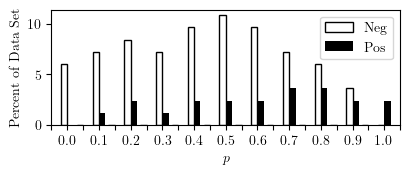

In [23]:
def Plot_Prediction_Wide(y_test, y_proba, filename, title):
    print ('Plot_Prediction()')
    print (filename)
    
#    print ('y_test = ', y_test)
#    print ('y_proba = ',y_proba)

#    y_test = y_test.numpy()
    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
#    print ("A = pd.DataFrame(y_proba, columns=['HOSPITAL'])")
#    display(A)
#    print ("B = pd.DataFrame(y_test, columns=['HOSPITAL'])")
#    display(B)
#    print ("C = A[B['HOSPITAL']==0]")
#    display(C)
#    print ("D = A[B['HOSPITAL']==1]")
#    display(D)
    n = 20
#    bins= [x/n - 1/(2*n) for x in range (-1, n+3)]
    bins= [x/n for x in range (-1, n+1)]
#    print ('Bins = ', bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=True)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=True)
#    print ("E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=True)")
#    display(E)
#    print ("F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=True)")
#    display(F)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)
#    print ("G = E.value_counts(sort=False)")
#    display(G)
#    print ("H = F.value_counts(sort=False)")
#    display(H)

    G = G/len(y_proba)*100
    H = H/len(y_proba)*100
#    print ("G = G/len(y_proba)*100")
#    display(G)
#    print ("H = H/len(y_proba)*100")
#    display(H)

    fig = plt.figure(figsize=(4.5,1.5)) # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    
    G.plot(kind='bar', fill=False, ax=ax, width=0.4, position=1)
    H.plot(kind='bar', color='black', ax=ax, width=0.4, position=0)
    ticks = [n/20*i for i in range (-1,22)]
#    print ('ticks = ', ticks)
    plt.xticks(
        ticks = ticks,
        labels = ['','0.0', '', '0.1', '', '0.2', '', '0.3', '', '0.4', '', '0.5', '', '0.6', '', '0.7', '', '0.8', '', '0.9', '', '1.0', ''],
        rotation=0
    )
    ax.legend(['Neg', 'Pos'])
#    plt.title(title)
    plt.xlabel('$p$')
    plt.ylabel('Percent of Data Set')
    plt.savefig('./Images/' + filename + '_Pred_Wide.png', bbox_inches="tight")
    plt.savefig('./Images/' + filename + '_Pred_Wide.pgf', bbox_inches="tight")
    print ('./Images/' + filename + '_Pred_Wide.png')
    plt.show()
    plt.close()
    print ()

def Test_Plot_Prediction_Wide():
    
    y_proba = (
        [0.0]*5 + 
        [0.0]*0 + 
        [0.1]*6 + 
        [0.1]*1 + 
        [0.2]*7 + 
        [0.2]*2 + 
        [0.3]*6 + 
        [0.3]*1 + 
        [0.4]*8 + 
        [0.4]*2 + 
        [0.5]*9 + 
        [0.5]*2 + 
        [0.6]*8 + 
        [0.6]*2 + 
        [0.7]*6 + 
        [0.7]*3 + 
        [0.8]*5 + 
        [0.8]*3 + 
        [0.9]*3 + 
        [0.9]*2 + 
        [1.0]*0 + 
        [1.0]*2 
    )
    y_test = (
        [0]*5 + 
        [1]*0 + 
        [0]*6 + 
        [1]*1 + 
        [0]*7 + 
        [1]*2 + 
        [0]*6 + 
        [1]*1 + 
        [0]*8 + 
        [1]*2 + 
        [0]*9 + 
        [1]*2 + 
        [0]*8 + 
        [1]*2 + 
        [0]*6 + 
        [1]*3 + 
        [0]*5 + 
        [1]*3 + 
        [0]*3 + 
        [1]*2 + 
        [0]*0 + 
        [1]*2 
    )
    Plot_Prediction_Wide(y_test, y_proba, 'Test', 'Test')
    
Test_Plot_Prediction_Wide()

## Switching between FP/TP and Precision

$$\text{Precision} = \frac{TP}{FP+TP}$$

$$\frac{1}{\text{Precision}} = \frac{FP+TP}{TP} = \frac{FP}{TP} + \frac{TP}{TP} = \frac{FP}{TP} +  1$$

$$\frac{FP}{TP} + 1 = \frac{1}{\text{Precision}}$$

$$\frac{FP}{TP} = \frac{1}{\text{Precision}} - 1 = \frac{1}{\text{Precision}} - \frac{\text{Precision}}{\text{Precision}}  = \frac{1 - \text{Precision}}{\text{Precision}}$$

- In a previous version I had wanted $FP/TP$ to equal either 2.0, 1.0, or 0.5, indicating that we were willing to send 2 unnecessary ambulances for each necessary one, etc.  
    - $FP/TP = 2.0$ corresponds to precision = 1/3
    - $FP/TP = 1.0$ corresponds to precision = 1/2
    - $FP/TP = 0.5$ corresponds to precision = 2/3

- Neg/Pos corresponds to marginal precision similarly

In [24]:
def Value_Counts_y_proba(y_proba, filename):
#    print ()
    print ('Value_Counts_y_proba')
#    print (type(y_proba))
    Y_proba = pd.Series(y_proba)
    A = Y_proba.value_counts().reset_index(drop=True)
    n = len(y_proba)
    nA = len(A)
#    display(Y_proba)
#    display(A)
    B = A.cumsum()
#    display(B)
#    print (B[10])
#    print ()
    cutoff_95 = B.sub(0.95*n).abs().idxmin() + 1
    cutoff_90 = B.sub(0.90*n).abs().idxmin() + 1
    cutoff_80 = B.sub(0.80*n).abs().idxmin() + 1
    print (n, nA)
    print (cutoff_95)
#    print ()

    n100 = min(100, len(B)-1)
    n200 = min(200, len(B)-1)
#    print ('n200 = ', n200)
    f = open('./Analyze_Proba/Value_Counts_y_proba.csv', 'a')
    f.write('%s,%d,%d,%0.4f,%d,%0.4f,%d,%0.4f,%d,%0.4f,%d,%0.4f,%d,%0.4f,%d,%0.4f,%d,%0.4f\n' % (
        filename, n, nA, nA/n, 
        cutoff_95, cutoff_95/n,
        cutoff_90, cutoff_90/n,
        cutoff_80, cutoff_80/n,
        B[10], B[10]/n,
        B[20], B[20]/n,
        B[n100], B[n100]/n,
        B[n200], B[n200]/n,
    ))
    f.close()
    
    H = Y_proba.value_counts().head(100)
    Filename = './Analyze_Proba/' + filename + '_Value_Counts.csv'
    H.to_csv(Filename)
    
    
    print ('Finished')
    return 0
    
def Create_Files_for_Value_Counts_y_proba():
    f = open('./Analyze_Proba/Value_Counts_y_proba.csv', 'w')
    f.write("Filename,n,nUnique,nUnique/n,95%,95%/n,90%,90%/n,80%,80%/n,B[10],B[10]/n,B[20],B[20]/n,B[100],B[100]/n,B[200],B[200]/n,\n")
    f.close()
    
#Create_Files_for_Value_Counts_y_proba()

def Create_Files_for_Lengths_of_fpr_tpr():
    f = open('./Analyze_Proba/Lengths_of_fpr_tpr.csv', 'w')
    f.write("Filename,len(y_proba),nUnique(y_proba),len(fpr),nUnique(fpr),len(tpr),nUnique(tpr),len(fpr tpr),nUnique(fpr tpr)\n")
    f.close()
    
    
    
def Test_Value_Counts_y_proba():
    A = [5]*50 + [6]*20 + [i for i in range (10,40)]*2 + [i for i in range (100,400)]
    Value_Counts_y_proba(A, 'Test')

Test_Value_Counts_y_proba()

    


Value_Counts_y_proba
430 332
310
Finished


In [25]:
def Analyze_Prediction(y_test, y_proba, filename, title):
    print ('Analyze_Prediction()')
    print (filename)
    
    Value_Counts_y_proba(y_proba, filename)
    
#    print (y_test)
#    print (y_proba)
#    return 0
#    y_test = y_test.numpy()
    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
#    print ('print (len(A), len(C), len(D), len(C) + len(D))')
#    print (len(A), len(C), len(D), len(C) + len(D))

    N = len(C)
    P = len(D)
    
    ##### 10 bins
    n = 10
    bins= [x/n for x in range (-1, n+1)]
#    print (bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=True)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=True)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)

    Analyze = pd.DataFrame()
    Analyze['Neg'] = G
    Analyze['Pos'] = H
    Analyze['p'] = bins[1:]
#    Analyze['Neg/Pos'] = Analyze['Neg']/Analyze['Pos']
    Analyze['mPrec'] = Analyze['Pos']/(Analyze['Pos'] + Analyze['Neg'])
    Analyze['TN'] = Analyze['Neg'].cumsum()
    Analyze['FP'] = N - Analyze['TN']
    Analyze['FN'] = Analyze['Pos'].cumsum()
    Analyze['TP'] = P - Analyze['FN']
#    Analyze['FP/TP'] = Analyze['FP']/Analyze['TP']
#    Analyze['FP+TP'] = Analyze['FP'] + Analyze['TP']
    Analyze['Prec'] = Analyze['TP']/(Analyze['FP'] + Analyze['TP'])
    Analyze['Rec'] =  Analyze['TP']/(Analyze['FN'] + Analyze['TP'])
    Analyze['FP/P'] =  Analyze['FP']/(Analyze['FN'] + Analyze['TP'])
    Analyze['$\hat{p}$'] = (Analyze['TP'] + Analyze['FP'])/len(y_proba)
    
    Analyze['Neg']=Analyze['Neg'].apply('{:,}'.format)
    Analyze['Pos']=Analyze['Pos'].apply('{:,}'.format)
    Analyze['TN']=Analyze['TN'].apply('{:,}'.format)
    Analyze['FP']=Analyze['FP'].apply('{:,}'.format)
    Analyze['FN']=Analyze['FN'].apply('{:,}'.format)
    Analyze['TP']=Analyze['TP'].apply('{:,}'.format)
#    Analyze['FP+TP']=Analyze['FP+TP'].apply('{:,}'.format)
    
#    Analyze['Neg/Pos']=Analyze['Neg/Pos'].apply('{:.2f}'.format)
    Analyze['mPrec']=Analyze['mPrec'].apply('{:.2f}'.format)
#    Analyze['FP/TP']=Analyze['FP/TP'].apply('{:.2f}'.format)
    Analyze['Prec']=Analyze['Prec'].apply('{:.2f}'.format)
    Analyze['Rec']=Analyze['Rec'].apply('{:.2f}'.format)
    Analyze['FP/P']=Analyze['FP/P'].apply('{:.2f}'.format)
    Analyze['$\hat{p}$']=Analyze['$\hat{p}$'].apply('{:.2f}'.format)
        
#    Analyze.index.name = 'p'
    Analyze.set_index('p', inplace=True)
#    print ('./Analyze_Proba/' + filename + '_10.tex')
#    print (len(y_proba))
#    display(Analyze)
    Analyze.to_csv('./Analyze_Proba/' + filename + '_10.csv', index=True)
    Analyze.to_latex(
        './Analyze_Proba/' + filename + '_10.tex', 
        index=True, 
        float_format="{:.2f}".format, 
        column_format='rrrrrrrrrrrrrrr',
        escape=False
    )



    ##### 20 bins
    n = 20
    bins= [x/n for x in range (-1, n+1)]
#    print (bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=True)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=True)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)

    Analyze = pd.DataFrame()
    Analyze['Neg'] = G
    Analyze['Pos'] = H
    Analyze['p'] = bins[1:]
#    Analyze['Neg/Pos'] = Analyze['Neg']/Analyze['Pos']
    Analyze['mPrec'] = Analyze['Pos']/(Analyze['Pos'] + Analyze['Neg'])
    Analyze['TN'] = Analyze['Neg'].cumsum()
    Analyze['FP'] = N - Analyze['TN']
    Analyze['FN'] = Analyze['Pos'].cumsum()
    Analyze['TP'] = P - Analyze['FN']
#    Analyze['FP/TP'] = Analyze['FP']/Analyze['TP']
#    Analyze['FP+TP'] = Analyze['FP'] + Analyze['TP']
    Analyze['Prec'] = Analyze['TP']/(Analyze['FP'] + Analyze['TP'])
    Analyze['Rec'] =  Analyze['TP']/(Analyze['FN'] + Analyze['TP'])
    Analyze['FP/P'] =  Analyze['FP']/(Analyze['FN'] + Analyze['TP'])
    Analyze['$\hat{p}$'] = (Analyze['TP'] + Analyze['FP'])/len(y_proba)
    
    Analyze['Neg']=Analyze['Neg'].apply('{:,}'.format)
    Analyze['Pos']=Analyze['Pos'].apply('{:,}'.format)
    Analyze['TN']=Analyze['TN'].apply('{:,}'.format)
    Analyze['FP']=Analyze['FP'].apply('{:,}'.format)
    Analyze['FN']=Analyze['FN'].apply('{:,}'.format)
    Analyze['TP']=Analyze['TP'].apply('{:,}'.format)
#    Analyze['FP+TP']=Analyze['FP+TP'].apply('{:,}'.format)
    
#    Analyze['Neg/Pos']=Analyze['Neg/Pos'].apply('{:.2f}'.format)
    Analyze['mPrec']=Analyze['mPrec'].apply('{:.2f}'.format)
#    Analyze['FP/TP']=Analyze['FP/TP'].apply('{:.2f}'.format)
    Analyze['Prec']=Analyze['Prec'].apply('{:.2f}'.format)
    Analyze['Rec']=Analyze['Rec'].apply('{:.2f}'.format)
    Analyze['FP/P']=Analyze['FP/P'].apply('{:.2f}'.format)
    Analyze['$\hat{p}$']=Analyze['$\hat{p}$'].apply('{:.2f}'.format)
        
#    Analyze.index.name = 'p'
    Analyze.set_index('p', inplace=True)
#    print ('./Analyze_Proba/' + filename + '_10.tex')
#    print (len(y_proba))
#    display(Analyze)
    Analyze.to_csv('./Analyze_Proba/' + filename + '_20.csv', index=True)
    Analyze.to_latex(
        './Analyze_Proba/' + filename + '_20.tex', 
        index=True, 
        float_format="{:.2f}".format, 
        column_format='rrrrrrrrrrrrrrr',
        escape=False
    )




    ##### 100 bins
    n = 100
    bins= [x/n for x in range (-1, n+1)]
#    print (bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=True)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=True)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)

    Analyze = pd.DataFrame()
    Analyze['Neg'] = G
    Analyze['Pos'] = H
    Analyze['p'] = bins[1:]
#    Analyze['Neg/Pos'] = Analyze['Neg']/Analyze['Pos']
    Analyze['mPrec'] = Analyze['Pos']/(Analyze['Pos'] + Analyze['Neg'])
    Analyze['TN'] = Analyze['Neg'].cumsum()
    Analyze['FP'] = N - Analyze['TN']
    Analyze['FN'] = Analyze['Pos'].cumsum()
    Analyze['TP'] = P - Analyze['FN']
#    Analyze['FP/TP'] = Analyze['FP']/Analyze['TP']
#    Analyze['FP+TP'] = Analyze['FP'] + Analyze['TP']
    Analyze['Prec'] = Analyze['TP']/(Analyze['FP'] + Analyze['TP'])
    Analyze['Rec'] =  Analyze['TP']/(Analyze['FN'] + Analyze['TP'])
    Analyze['FP/P'] =  Analyze['FP']/(Analyze['FN'] + Analyze['TP'])
    Analyze['$\hat{p}$'] = (Analyze['TP'] + Analyze['FP'])/len(y_proba)
    
    A = Analyze.copy(deep=True)
    
    Analyze['Neg']=Analyze['Neg'].apply('{:,}'.format)
    Analyze['Pos']=Analyze['Pos'].apply('{:,}'.format)
    Analyze['TN']=Analyze['TN'].apply('{:,}'.format)
    Analyze['FP']=Analyze['FP'].apply('{:,}'.format)
    Analyze['FN']=Analyze['FN'].apply('{:,}'.format)
    Analyze['TP']=Analyze['TP'].apply('{:,}'.format)
#    Analyze['FP+TP']=Analyze['FP+TP'].apply('{:,}'.format)
    
#    Analyze['Neg/Pos']=Analyze['Neg/Pos'].apply('{:.2f}'.format)
    Analyze['mPrec']=Analyze['mPrec'].apply('{:.2f}'.format)
#    Analyze['FP/TP']=Analyze['FP/TP'].apply('{:.2f}'.format)
    Analyze['Prec']=Analyze['Prec'].apply('{:.2f}'.format)
    Analyze['Rec']=Analyze['Rec'].apply('{:.2f}'.format)
    Analyze['FP/P']=Analyze['FP/P'].apply('{:.2f}'.format)
    Analyze['$\hat{p}$']=Analyze['$\hat{p}$'].apply('{:.2f}'.format)
        
#    Analyze.index.name = 'p'
    Analyze.set_index('p', inplace=True)
#    print ('./Analyze_Proba/' + filename + '_10.tex')
#    print (len(y_proba))
#    display(Analyze)
    Analyze.to_csv('./Analyze_Proba/' + filename + '_100.csv', index=True)
    Analyze.to_latex(
        './Analyze_Proba/' + filename + '_100.tex', 
        index=True, 
        float_format="{:.2f}".format, 
        column_format='rrrrrrrrrrrrrrr',
        escape=False
    )


    
    # Append CSV files with results from multiple models
    A.set_index('p', inplace=True)
    A.insert(0, 'Filename', filename)
    
    # Remove rows with negligible number of samples
    A = A[A['Neg'] >= 20]
    A = A[A['Pos'] >= 20]
    
    
    A_closest = A.iloc[(A['mPrec'] - 0.333).abs().argsort()[:1]].head(1)
    A_closest.to_csv('./Analyze_Proba/mPrec_0_333.csv', mode='a', 
        index=True, header=False, float_format="{:.2f}".format)
    A_closest['Filename'] = A_closest['Filename'].str.replace('_','\\_')
    A_closest.to_csv('./Analyze_Proba/mprec_0_333.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, float_format="{:.2f}".format)
    
    A_closest = A.iloc[(A['mPrec'] - 0.5).abs().argsort()[:1]].head(1)
    A_closest.to_csv('./Analyze_Proba/mPrec_0_5.csv', mode='a', index=True, header=False)
    
    A_closest = A.iloc[(A['mPrec'] - 0.667).abs().argsort()[:1]].head(1)
    A_closest.to_csv('./Analyze_Proba/mPrec_0_667.csv', mode='a', index=True, header=False)
    
    A_closest = A.iloc[(A['Prec'] - 0.333).abs().argsort()[:1]].head(1)
    A_closest.to_csv('./Analyze_Proba/Prec_0_333.csv', mode='a', index=True, header=False)
    
    A_closest = A.iloc[(A['Prec'] - 0.5).abs().argsort()[:1]].head(1)
    A_closest.to_csv('./Analyze_Proba/Prec_0_5.csv', mode='a', index=True, header=False)
    
    A_closest = A.iloc[(A['Prec'] - 0.667).abs().argsort()[:1]].head(1)
    A_closest.to_csv('./Analyze_Proba/Prec_0_667.csv', mode='a', index=True, header=False)
    
    A_closest = A.iloc[(A['$\hat{p}$'] - 0.05).abs().argsort()[:1]].head(1)
    A_closest.to_csv('./Analyze_Proba/p_hat_0_05.csv', mode='a', index=True, header=False)
    
    A_closest = A.iloc[(A['$\hat{p}$'] - 0.10).abs().argsort()[:1]].head(1)
    A_closest.to_csv('./Analyze_Proba/p_hat_0_10.csv', mode='a', index=True, header=False)
    
    A_closest = A.iloc[(A['$\hat{p}$'] - 0.15).abs().argsort()[:1]].head(1)
    A_closest.to_csv('./Analyze_Proba/p_hat_0_15.csv', mode='a', index=True, header=False)
    
    A_closest = A.iloc[(A['FP/P'] - 0.05).abs().argsort()[:1]].head(1)
    A_closest.to_csv('./Analyze_Proba/FP_P_0_05.csv', mode='a', index=True, header=False)
    
    
def Create_Files_for_Analyze_Prediction():
    f = open('./Analyze_Proba/mPrec_0_5.csv', 'w')
    f.write("p,Filename,Neg,Pos,$m$Prec,TN,FP,FN,TP,Prec,Rec,FP/P,$\hat{p}$\n")
    f.close()
    f = open('./Analyze_Proba/mPrec_0_667.csv', 'w')
    f.write("p,Filename,Neg,Pos,$m$Prec,TN,FP,FN,TP,Prec,Rec,FP/P,$\hat{p}$\n")
    f.close()
    f = open('./Analyze_Proba/mPrec_0_333.csv', 'w')
    f.write("p,Filename,Neg,Pos,$m$Prec,TN,FP,FN,TP,Prec,Rec,FP/P,$\hat{p}$\n")
    f.close()
    g = open('./Analyze_Proba/mPrec_0_333.tex', 'w')
    g.write("p & Filename & Neg & Pos & $m$Prec & TN & FP & FN & TP & Prec & Rec & FP/P & $\hat{p}$\\cr\\hline\n")
    g.close()
    f = open('./Analyze_Proba/Prec_0_5.csv', 'w')
    f.write("p,Filename,Neg,Pos,$m$Prec,TN,FP,FN,TP,Prec,Rec,FP/P,$\hat{p}$\n")
    f.close()
    f = open('./Analyze_Proba/Prec_0_667.csv', 'w')
    f.write("p,Filename,Neg,Pos,$m$Prec,TN,FP,FN,TP,Prec,Rec,FP/P,$\hat{p}$\n")
    f.close()
    f = open('./Analyze_Proba/Prec_0_333.csv', 'w')
    f.write("p,Filename,Neg,Pos,$m$Prec,TN,FP,FN,TP,Prec,Rec,FP/P,$\hat{p}$\n")
    f.close()
    f = open('./Analyze_Proba/p_hat_0_05.csv', 'w')
    f.write("p,Filename,Neg,Pos,$m$Prec,TN,FP,FN,TP,Prec,Rec,FP/P,$\hat{p}$\n")
    f.close()
    f = open('./Analyze_Proba/p_hat_0_10.csv', 'w')
    f.write("p,Filename,Neg,Pos,$m$Prec,TN,FP,FN,TP,Prec,Rec,FP/P,$\hat{p}$\n")
    f.close()
    f = open('./Analyze_Proba/p_hat_0_15.csv', 'w')
    f.write("p,Filename,Neg,Pos,$m$Prec,TN,FP,FN,TP,Prec,Rec,FP/P,$\hat{p}$\n")
    f.close()
    f = open('./Analyze_Proba/FP_P_0_05.csv', 'w')
    f.write("p,Filename,Neg,Pos,$m$Prec,TN,FP,FN,TP,Prec,Rec,FP/P,$\hat{p}$\n")
    f.close()


#Create_Files_for_Analyze_Prediction()



In [26]:
def Test_Plot_Prediction_Zoom():
    print ('Idealized_Results()')
    # Set randomness
    np.random.seed(42) # NumPy
    random.seed(42) # Python
    tf.random.set_seed(42) # Tensorflow    

    shape, scale = 3.7, 0.1 # mean=4, std=2*sqrt(2)
    a = np.random.gamma(shape, scale, 150771)
    a = np.where(a>1.0, random.random(), a)
    
    shape, scale = 3.8, 0.1 # mean=4, std=2*sqrt(2)
    b = np.random.gamma(shape, scale, 26621)    
    b = np.where(b>1.0, random.random(), b)
    b = 1-b
    
    y_proba = np.concatenate((a,b),axis=0)
    y_pred = K.round(y_proba)
    y_test = [0]*len(a) + [1]*len(b)  
    
    display(y_proba[:20])
    display(y_pred[:20])
    
    Plot_Prediction(y_test, y_proba, 'Test', 'Test')    
    Plot_Prediction_Wide(y_test, y_proba, 'Test', 'Test')    
    Plot_Prediction_Zoom(y_test, y_proba, 'Test', 'Test', 0.45, 0.55)
    Analyze_Prediction(y_test, y_proba, 'Test', 'Test')    
    
#Test_Plot_Prediction_Zoom()

## Plot ROC Curves

In [27]:
def ROC(y_test, y_proba, p_values, filename):
    print ('ROC()')
    print (filename)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    
    A = np.asarray((fpr,tpr)).T
    print ()
    print ('len(fpr/tpr) = ', len(A))
    print (A[:10])
    A = np.unique(A, axis=0)
    print (A[:10])
    nU = len(A)
    print ('Unique fpr/tpr = ', nU)
    print ()
    
    f = open('./Analyze_Proba/Lengths_of_fpr_tpr.csv', 'a')
    f.write('%s,' % (filename))
    f.write('%d,' % len(y_proba))
    f.write('%d,' % len(np.unique(y_proba)))
    f.write('%d,' % len(fpr))
    f.write('%d,' % len(np.unique(fpr)))
    f.write('%d,' % len(tpr))
    f.write('%d,' % len(np.unique(tpr)))
    f.write('%d,' % len(np.asarray((fpr,tpr)).T))
    f.write('%d,' % len(np.unique(np.asarray((fpr,tpr)).T, axis=0)))
    f.write('\n')
    f.close()

    
    N_median = np.median(y_proba[np.array(y_test)==0])
    P_median = np.median(y_proba[np.array(y_test)==1])
#    print ('N_median, P_median = ', N_median, P_median)

    m = np.quantile(y_proba,0.50)
    p = np.quantile(y_proba,0.25)
    q = np.quantile(y_proba,0.75)
    
    Y = []
    print ('p_values = ', p_values)
    for X in p_values:
        difference_array = np.absolute(thresholds-X)
        index = difference_array.argmin()
        F = fpr[index]
        T = tpr[index]
        Y.append([X,str(round(X,3)),F,T])
    
    auc_value = auc(fpr, tpr)
    auc_value = round(auc_value,3)
    fig = plt.figure(figsize=(2.0,1.5)) # Create matplotlib figure
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, color='black', label='AUC={:.3f}'.format(auc_value))
    
    for y in Y:
#        plt.plot([y[2]], [y[3]], marker="o", markersize=20, markeredgecolor="white", markerfacecolor="white")
#        plt.annotate(
#            y[1], # this is the text
#            (y[2], y[3]), # these are the coordinates to position the label
#            ha='center' # horizontal alignment can be left, right or center
#        )
        plt.text(
            y[2], y[3], # these are the coordinates to position the label
            y[1], # this is the text
            backgroundcolor='white', # horizontal alignment can be left, right or center
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='square,pad=0.3')
        )
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
#    plt.title('ROC with AUC {:.3f}'.format(auc_value))
    plt.legend(loc='best')
    plt.savefig('./Images/' + filename + '_ROC.png', bbox_inches="tight")
    plt.savefig('./Images/' + filename + '_ROC.pgf', bbox_inches="tight")
    print ('./Images/' + filename + '_ROC.png')
    plt.show()
    plt.close()
    print ()
    return 0

def Test_ROC():
    y_test = [0,0,0,0,0,1]*10000
#    y_proba = [abs(0.45 - y)+round(0.45*random.random(),2) for y in y_test]
    y_proba = [abs(0.45 - y)+round(0.45*random.normalvariate(mu=0.2, sigma=0.2),3) for y in y_test]
#    random.normalvariate(mu=0.0, sigma=1.0)
    y_test = np.array(y_test)
    y_proba = np.array(y_proba)
    print (y_test)
    print (y_proba)
    ROC(y_test, y_proba, [0.5], "tmp")
    
#Test_ROC()



# Five-Fold Cross Validation

In [28]:
def Five_Fold_Cross_Validation(data, model, filename, title):
    print ()
    print ('------------------------')
    print ()
    print (filename)
    print ()
    
    target = 'HOSPITAL'
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    target_column = data.loc[:,target]
    y_test = []
    y_proba = []
    y_pred = []
    
    iteration = 0
    for train_index, test_index in skf.split(data, target_column):
        print ('K-fold iteration = ', iteration)
        iteration += 1
        
#        print ('len(train_index) = ', len(train_index))
#        print (train_index)
#        print ('len(test_index) = ', len(test_index))
#        print (test_index)
        
        train_fold = data.iloc[train_index]
#        print ()
#        print ('train_fold')
#        display(train_fold)
        
        test_fold = data.iloc[test_index]
#        print ()
#        print ('test_fold')
#        display(test_fold)
#        print ('type(test_fold) = ', type(test_fold))
        
        
        X_train_fold = train_fold.drop(columns=[target])
        X_test_fold = test_fold.drop(columns=[target])
        y_train_fold = train_fold[target].squeeze()        
        y_test_fold = test_fold[target].squeeze()
#        print ('type(y_test_fold) = ', type(y_test_fold))
        
#        print ()
        model.fit(X_train_fold, y_train_fold.values.ravel())
        y_proba_fold = model.predict_proba(X_test_fold)
        y_proba_fold = [x[1] for x in y_proba_fold]
        y_pred_fold = list(np.around(np.array(y_proba_fold),0))
        
        ###
#        print ('X_train_fold')
#        display(X_train_fold)
#        print ('y_train_fold')
#        display(y_train_fold)
#        print ('y_train_fold.value_counts()')
#        display(y_train_fold.value_counts())
#        print ('y_proba_fold')
#        print (y_proba_fold)
#        ###
#        
        y_test = y_test + y_test_fold.to_list()
        y_proba = y_proba + y_proba_fold
#        print ('len(y_proba) = ', len(y_proba))
        y_pred = y_pred + y_pred_fold

    y_test = np.array(y_test)
    y_proba = np.array(y_proba)
    y_pred = np.array(y_pred)
    
    
    Chart_and_Plots(y_test, y_proba, y_pred, filename + '_Test', title)
    
    
    print ()
    return model    


In [29]:
def BRFC_5_Fold(data, target, alpha, filename):
     
    title = ''
    model = BalancedRandomForestClassifier(
        bootstrap = True, ccp_alpha = 0.0, criterion = 'gini', 
        max_depth = None,
#        max_depth = 40, 
        max_features = 'sqrt', 
        max_leaf_nodes = None,
#        max_leaf_nodes = 10000,  
        max_samples = None, 
        min_impurity_decrease = 0.0, 
        min_samples_leaf = 1, 
        min_samples_split = 2, 
        min_weight_fraction_leaf = 0.0, 
        n_estimators = 100, 
#        n_estimators = 1000, 
        n_jobs = None, 
        oob_score = False, 
        random_state = None, 
        replacement = False, 
        sampling_strategy = 'auto', 
        verbose = 0, 
        warm_start = False,
        class_weight = {0:1-alpha, 1:alpha}
    )
    Five_Fold_Cross_Validation(data, model, filename, title)



In [30]:
def RFC_5_Fold(data, target, filename):
    title = ''
    model = RandomForestClassifier(max_depth=2, random_state=0)
    Five_Fold_Cross_Validation(data, model, filename, title)


In [31]:
def AdaBoost_5_Fold(data, target, filename):
    title = ''
    model = AdaBoostClassifier(n_estimators=100)
    Five_Fold_Cross_Validation(data, model, filename, title)


In [32]:
def RUSBoost_5_Fold(data, target, filename):
    title = ''
    estimator = DecisionTreeClassifier(
        max_depth=1,
#        class_weight={0:(1+r_target)/(2*r_target), 1:(1+r_target)/(2*1)},
    )    
    model = RUSBoostClassifier(
        n_estimators=1000, 
        estimator=estimator,
        algorithm='SAMME.R', 
#        random_state=42
    )
    Five_Fold_Cross_Validation(data, model, filename, title)


In [33]:
def BalancedBagging_5_Fold(data, target, filename):
    title = ''
    model = BalancedBaggingClassifier(
#        random_state=42
    )
    Five_Fold_Cross_Validation(data, model, filename, title)
    

In [34]:
def EasyEnsemble_5_Fold(data, target, filename):
    title = ''
    estimator = AdaBoostClassifier(n_estimators=10)
    model = EasyEnsembleClassifier(n_estimators=10, estimator=estimator)
    Five_Fold_Cross_Validation(data, model, filename, title)

    

In [35]:
def LogisticRegression_5_Fold(data, target, alpha, filename):
    title = ''
    model = LogisticRegression(
#        class_weight={0:(1+r_target)/(2*r_target), 1:(1+r_target)/(2*1)}
        class_weight = {0:1-alpha, 1:alpha},
        max_iter=1000,
#        random_state=42,
    )
    Five_Fold_Cross_Validation(data, model, filename, title)


In [36]:
def KBFC_5_Fold(data, target, alpha, gamma, filename):
    print ()
    print ('------------------------')
    print ()
    print (filename)
    print ()
    
    target = 'HOSPITAL'
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    target_column = data.loc[:,target]
    y_test = []
    y_proba = []
    y_pred = []
    
    iteration = 0
    for train_index, test_index in skf.split(data, target_column):
        print ()
        print ()
        print ('K-fold iteration = ', iteration)
        iteration += 1
        
        print ('len(train_index) = ', len(train_index))
        print (train_index)
        print ('len(test_index) = ', len(test_index))
        print (test_index)
        
        train_fold = data.iloc[train_index]
        print ()
        print ('train_fold')
        display(train_fold)
        
        test_fold = data.iloc[test_index]
        print ()
        print ('test_fold')
        display(test_fold)
        print ('type(test_fold) = ', type(test_fold))
        
        
        X_train_fold = train_fold.drop(columns=[target])
        X_test_fold = test_fold.drop(columns=[target])
        y_train_fold = train_fold[target].squeeze()        
        y_test_fold = test_fold[target].squeeze()
        print ('type(y_test_fold) = ', type(y_test_fold))

        print ('len(X_train_fold) = ', len(X_train_fold))
        print ('len(X_test_fold) = ', len(X_test_fold))
        print ('len(y_train_fold) = ', len(y_train_fold))
        print ('len(y_test_fold) = ', len(y_test_fold))
        print ()
        
#        print ()

        loss_function = tf.keras.losses.BinaryFocalCrossentropy(
            apply_class_balancing=True,
            alpha=alpha,
            gamma=gamma,
    #        from_logits=False,
    #        label_smoothing=0.0,
    #        axis=-1,
    #        reduction=losses_utils.ReductionV2.AUTO,
    #        name='binary_focal_crossentropy'
        )   
    
        # create model
        model = Sequential()
        print ('data.shape = ', data.shape, data.shape[-1])
        model.add(Dense(60, input_shape=(data.shape[-1]-1,), activation='relu'))
#        model.add(Dense(30, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))    
        # Compile model
        metrics = [
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall"),
    #        F1_Metric,
        ]
        model.compile(loss=loss_function, optimizer=tf.keras.optimizers.Adam(), metrics=metrics)
        estimator = KerasClassifier(
            model=model, 
    #        random_state=42,
            metrics=metrics,
            batch_size=128, 
            verbose=0,
            epochs=20,
        )
    


        estimator.fit(X_train_fold, y_train_fold.values.ravel())
        y_proba_fold = estimator.predict_proba(X_test_fold)
        y_proba_fold = [x[1] for x in y_proba_fold]
        y_pred_fold = list(np.around(np.array(y_proba_fold),0))
        
        ###
        print ('X_train_fold')
        display(X_train_fold.head())
        print ('y_train_fold')
        display(y_train_fold.head())
        print ('y_train_fold.value_counts()')
        display(y_train_fold.value_counts())
        print ('X_test_fold')
        display(X_test_fold.head())
        print ('y_test_fold')
        display(y_test_fold.head())
        print ('y_test_fold.value_counts()')
        display(y_test_fold.value_counts())
        print ('y_proba_fold')
        print (y_proba_fold[:10])
#        ###
#        
        y_test = y_test + y_test_fold.to_list()
        y_proba = y_proba + y_proba_fold
#        print ('len(y_proba) = ', len(y_proba))
        y_pred = y_pred + y_pred_fold

    y_test = np.array(y_test)
    y_proba = np.array(y_proba)
    y_pred = np.array(y_pred)
    
    
    Chart_and_Plots(y_test, y_proba, y_pred, filename + '_Test', '')
    
    
    print ()
    return model    


# Run

In [37]:
def Run_with_Hard_Features():
    data = Get_Data()
    data = data.astype('int64')
    target = 'HOSPITAL'
    data = Feature_Engineering_Cross_Two(data)
    data = Thin_to_Hard_Features(data)
    write_filename_features = '_Hard'
    data = Get_Dummies(data, target)
    
    y = data[target]
    N = len(y)
    n = len(y[y==1])
    p = (N-n)/n
    alpha_balanced = p/(p+1)
    print ('p = ', p)
    print ('alpha_balanced = ', alpha_balanced)    

    filename = 'RFC_5_Fold' + write_filename_features
    RFC_5_Fold(data, target, filename)
    
    alpha = 0.5
    filename = 'BRFC_5_Fold_alpha_0_5' + write_filename_features
    BRFC_5_Fold(data, target, alpha, filename)
    
    alpha = alpha_balanced
    filename = 'BRFC_5_Fold_alpha_balanced' + write_filename_features
    BRFC_5_Fold(data, target, alpha, filename)
    

    alpha = 0.5
    filename = 'LogReg_5_Fold_alpha_0_5' + write_filename_features
    LogisticRegression_5_Fold(data, target, alpha, filename)

    alpha = alpha_balanced
    filename = 'LogReg_5_Fold_alpha_balanced' + write_filename_features
    LogisticRegression_5_Fold(data, target, alpha, filename)

    AdaBoost_5_Fold(data, target, 'AdaBoost_5_Fold' + write_filename_features)
    BalancedBagging_5_Fold(data, target, 'BalBag_5_Fold' + write_filename_features)
    EasyEnsemble_5_Fold(data, target, 'EEC_5_Fold' + write_filename_features)
    RUSBoost_5_Fold(data, target, 'RUSBoost_5_Fold' + write_filename_features)
    
    alpha = 0.5
    gamma = 0.0
    filename = 'KBFC_5_Fold_alpha_0_5_gamma_0_0' + write_filename_features
    KBFC_5_Fold(data, target, alpha, gamma, filename)

    alpha = alpha_balanced
    gamma = 0.0
    filename = 'KBFC_5_Fold_alpha_balanced_gamma_0_0' + write_filename_features
    KBFC_5_Fold(data, target, alpha, gamma, filename)

    alpha = 0.5
    gamma = 1.0
    filename = 'KBFC_5_Fold_alpha_0_5_gamma_1_0' + write_filename_features
    KBFC_5_Fold(data, target, alpha, gamma, filename)

    alpha = 0.5
    gamma = 2.0
    filename = 'KBFC_5_Fold_alpha_0_5_gamma_2_0' + write_filename_features
    KBFC_5_Fold(data, target, alpha, gamma, filename)
    


In [38]:
def Run_with_Medium_Features():
    data = Get_Data()
    data = data.astype('int64')
    target = 'HOSPITAL'
    data = Feature_Engineering_Cross_Two(data)
    data = Thin_to_Medium_Features(data)
    write_filename_features = '_Medium'
    data = Get_Dummies(data, target)

    y = data[target]
    N = len(y)
    n = len(y[y==1])
    p = (N-n)/n
    alpha_balanced = p/(p+1)
    print ('p = ', p)
    print ('alpha_balanced = ', alpha_balanced)    

    alpha = 0.5
    filename = 'BRFC_5_Fold_alpha_0_5' + write_filename_features
    BRFC_5_Fold(data, target, alpha, filename)
    
    alpha = alpha_balanced
    filename = 'BRFC_5_Fold_alpha_balanced' + write_filename_features
    BRFC_5_Fold(data, target, alpha, filename)
    
    alpha = 0.5
    filename = 'LogReg_5_Fold_alpha_0_5' + write_filename_features
    LogisticRegression_5_Fold(data, target, alpha, filename)

    alpha = alpha_balanced
    filename = 'LogReg_5_Fold_alpha_balanced' + write_filename_features
    LogisticRegression_5_Fold(data, target, alpha, filename)

    AdaBoost_5_Fold(data, target, 'AdaBoost_5_Fold' + write_filename_features)
    BalancedBagging_5_Fold(data, target, 'BalBag_5_Fold' + write_filename_features)
    EasyEnsemble_5_Fold(data, target, 'EEC_5_Fold' + write_filename_features)
    RUSBoost_5_Fold(data, target, 'RUSBoost_5_Fold' + write_filename_features)
    
    alpha = 0.5
    gamma = 0.0
    filename = 'KBFC_5_Fold_alpha_0_5_gamma_0_0' + write_filename_features
    KBFC_5_Fold(data, target, alpha, gamma, filename)

    alpha = alpha_balanced
    gamma = 0.0
    filename = 'KBFC_5_Fold_alpha_balanced_gamma_0_0' + write_filename_features
    KBFC_5_Fold(data, target, alpha, gamma, filename)



In [39]:
def Run_with_Easy_Features():
    data = Get_Data()
    data = data.astype('int64')
    target = 'HOSPITAL'
    data = Feature_Engineering_Cross_Two(data)
    data = Thin_to_Easy_Features(data)
    write_filename_features = '_Easy'
    data = Get_Dummies(data, target)

    y = data[target]
    N = len(y)
    n = len(y[y==1])
    p = (N-n)/n
    alpha_balanced = p/(p+1)
    print ('p = ', p)
    print ('alpha_balanced = ', alpha_balanced)    

    alpha = 0.5
    filename = 'BRFC_5_Fold_alpha_0_5' + write_filename_features
    BRFC_5_Fold(data, target, alpha, filename)
    
    alpha = alpha_balanced
    filename = 'BRFC_5_Fold_alpha_balanced' + write_filename_features
    BRFC_5_Fold(data, target, alpha, filename)
    
    alpha = 0.5
    filename = 'LogReg_5_Fold_alpha_0_5' + write_filename_features
    LogisticRegression_5_Fold(data, target, alpha, filename)

    alpha = alpha_balanced
    filename = 'LogReg_5_Fold_alpha_balanced' + write_filename_features
    LogisticRegression_5_Fold(data, target, alpha, filename)

    AdaBoost_5_Fold(data, target, 'AdaBoost_5_Fold' + write_filename_features)
    BalancedBagging_5_Fold(data, target, 'BalBag_5_Fold' + write_filename_features)
    EasyEnsemble_5_Fold(data, target, 'EEC_5_Fold' + write_filename_features)
    RUSBoost_5_Fold(data, target, 'RUSBoost_5_Fold' + write_filename_features)
    
    alpha = 0.5
    gamma = 0.0
    filename = 'KBFC_5_Fold_alpha_0_5_gamma_0_0' + write_filename_features
    KBFC_5_Fold(data, target, alpha, gamma, filename)

    alpha = alpha_balanced
    gamma = 0.0
    filename = 'KBFC_5_Fold_alpha_balanced_gamma_0_0' + write_filename_features
    KBFC_5_Fold(data, target, alpha, gamma, filename)



In [40]:
Create_Files_for_Value_Counts_y_proba()
Create_Files_for_Analyze_Prediction()
Create_Files_for_Lengths_of_fpr_tpr()


Get_Data()
data.shape:  (713566, 78)
End Get_Data()

Feature_Engineering_Cross_Two

Thin_to_Hard_Features()
data.shape:  (713566, 40)
End Thin_to_Hard_Features()

Get_Dummies

p =  5.609785468153692
alpha_balanced =  0.84870915934896

------------------------

RFC_5_Fold_Hard

K-fold iteration =  0
K-fold iteration =  1
K-fold iteration =  2
K-fold iteration =  3
K-fold iteration =  4
Analyze_Prediction()
RFC_5_Fold_Hard_Test
Value_Counts_y_proba
713566 458530
422852
Finished
Plot_Prediction()
RFC_5_Fold_Hard_Test
./Images/RFC_5_Fold_Hard_Test_Pred.png


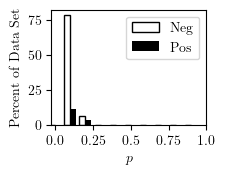


Plot_Prediction()
RFC_5_Fold_Hard_Test
./Images/RFC_5_Fold_Hard_Test_Pred_Wide.png


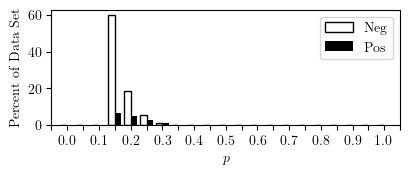


ROC()
RFC_5_Fold_Hard_Test

len(fpr/tpr) =  248307
[[0.         0.        ]
 [0.         0.00001853]
 [0.         0.00005558]
 [0.00000165 0.00005558]
 [0.00000165 0.00006484]
 [0.0000066  0.00006484]
 [0.0000066  0.00008337]
 [0.00000826 0.00009263]
 [0.00000826 0.00012042]
 [0.00000991 0.00012042]]
[[0.         0.        ]
 [0.         0.00001853]
 [0.         0.00005558]
 [0.00000165 0.00005558]
 [0.00000165 0.00006484]
 [0.0000066  0.00006484]
 [0.0000066  0.00008337]
 [0.00000826 0.00009263]
 [0.00000826 0.00012042]
 [0.00000991 0.00012042]]
Unique fpr/tpr =  248307

p_values =  []
./Images/RFC_5_Fold_Hard_Test_ROC.png


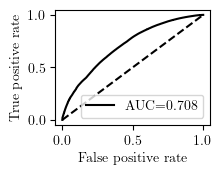


Linear_Transform_y_proba()

a = 0.106, b = 0.311

Analyze_Prediction()
RFC_5_Fold_Hard_Test_Transformed_100
Value_Counts_y_proba
713566 458530
422852
Finished
Plot_Prediction()
RFC_5_Fold_Hard_Test_Transformed_100
./Images/RFC_5_Fold_Hard_Test_Transformed_100_Pred.png


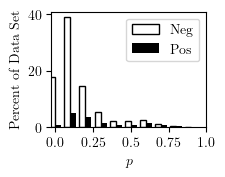


Plot_Prediction()
RFC_5_Fold_Hard_Test_Transformed_100
./Images/RFC_5_Fold_Hard_Test_Transformed_100_Pred_Wide.png


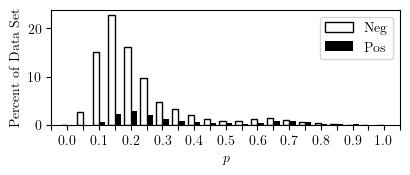


ROC()
RFC_5_Fold_Hard_Test_Transformed_100

len(fpr/tpr) =  248307
[[0.         0.        ]
 [0.         0.00001853]
 [0.         0.00005558]
 [0.00000165 0.00005558]
 [0.00000165 0.00006484]
 [0.0000066  0.00006484]
 [0.0000066  0.00008337]
 [0.00000826 0.00009263]
 [0.00000826 0.00012042]
 [0.00000991 0.00012042]]
[[0.         0.        ]
 [0.         0.00001853]
 [0.         0.00005558]
 [0.00000165 0.00005558]
 [0.00000165 0.00006484]
 [0.0000066  0.00006484]
 [0.0000066  0.00008337]
 [0.00000826 0.00009263]
 [0.00000826 0.00012042]
 [0.00000991 0.00012042]]
Unique fpr/tpr =  248307

p_values =  []
./Images/RFC_5_Fold_Hard_Test_Transformed_100_ROC.png


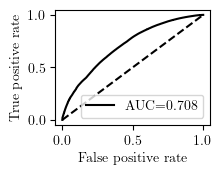


Linear_Transform_y_proba()

a = 0.111, b = 0.286

Analyze_Prediction()
RFC_5_Fold_Hard_Test_Transformed_98
Value_Counts_y_proba
713566 455540
419862
Finished
Plot_Prediction()
RFC_5_Fold_Hard_Test_Transformed_98
./Images/RFC_5_Fold_Hard_Test_Transformed_98_Pred.png


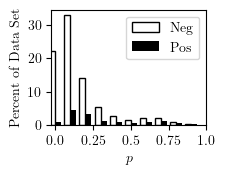


Plot_Prediction()
RFC_5_Fold_Hard_Test_Transformed_98
./Images/RFC_5_Fold_Hard_Test_Transformed_98_Pred_Wide.png


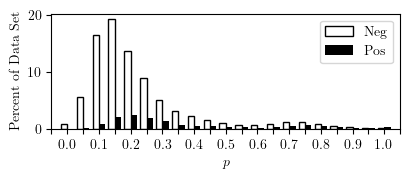


ROC()
RFC_5_Fold_Hard_Test_Transformed_98

len(fpr/tpr) =  246466
[[0.         0.        ]
 [0.00070673 0.01000408]
 [0.00070673 0.01001334]
 [0.00070838 0.01001334]
 [0.00070838 0.01003186]
 [0.00071003 0.01003186]
 [0.00071003 0.01009671]
 [0.00071168 0.01009671]
 [0.00071168 0.01013376]
 [0.00071168 0.01015228]]
[[0.         0.        ]
 [0.00070673 0.01000408]
 [0.00070673 0.01001334]
 [0.00070838 0.01001334]
 [0.00070838 0.01003186]
 [0.00071003 0.01003186]
 [0.00071003 0.01009671]
 [0.00071168 0.01009671]
 [0.00071168 0.01013376]
 [0.00071168 0.01015228]]
Unique fpr/tpr =  246466

p_values =  []
./Images/RFC_5_Fold_Hard_Test_Transformed_98_ROC.png


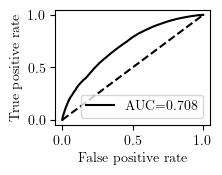


Linear_Transform_y_proba()

a = 0.115, b = 0.273

Analyze_Prediction()
RFC_5_Fold_Hard_Test_Transformed_95
Value_Counts_y_proba
713566 448935
413257
Finished
Plot_Prediction()
RFC_5_Fold_Hard_Test_Transformed_95
./Images/RFC_5_Fold_Hard_Test_Transformed_95_Pred.png


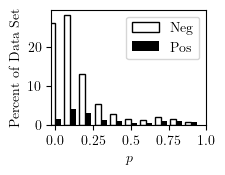


Plot_Prediction()
RFC_5_Fold_Hard_Test_Transformed_95
./Images/RFC_5_Fold_Hard_Test_Transformed_95_Pred_Wide.png


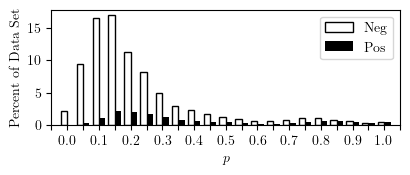


ROC()
RFC_5_Fold_Hard_Test_Transformed_95

len(fpr/tpr) =  242718
[[0.         0.        ]
 [0.00245372 0.02500093]
 [0.00245372 0.02502872]
 [0.00246363 0.02502872]
 [0.00246363 0.02503798]
 [0.00246528 0.02503798]
 [0.00246528 0.02504724]
 [0.00246693 0.02504724]
 [0.00246693 0.0250565 ]
 [0.00246859 0.0250565 ]]
[[0.         0.        ]
 [0.00245372 0.02500093]
 [0.00245372 0.02502872]
 [0.00246363 0.02502872]
 [0.00246363 0.02503798]
 [0.00246528 0.02503798]
 [0.00246528 0.02504724]
 [0.00246693 0.02504724]
 [0.00246693 0.0250565 ]
 [0.00246859 0.0250565 ]]
Unique fpr/tpr =  242718

p_values =  []
./Images/RFC_5_Fold_Hard_Test_Transformed_95_ROC.png


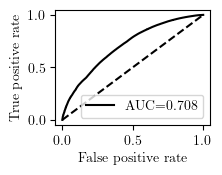





------------------------

BRFC_5_Fold_alpha_0_5_Hard

K-fold iteration =  0
K-fold iteration =  1
K-fold iteration =  2
K-fold iteration =  3
K-fold iteration =  4
Analyze_Prediction()
BRFC_5_Fold_alpha_0_5_Hard_Test
Value_Counts_y_proba
713566 3969
152
Finished
Plot_Prediction()
BRFC_5_Fold_alpha_0_5_Hard_Test
./Images/BRFC_5_Fold_alpha_0_5_Hard_Test_Pred.png


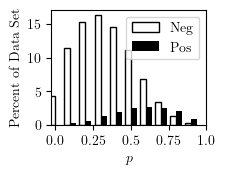


Plot_Prediction()
BRFC_5_Fold_alpha_0_5_Hard_Test
./Images/BRFC_5_Fold_alpha_0_5_Hard_Test_Pred_Wide.png


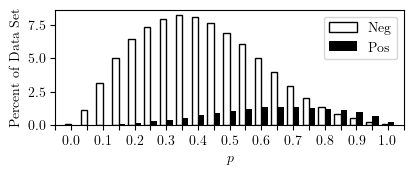


ROC()
BRFC_5_Fold_alpha_0_5_Hard_Test

len(fpr/tpr) =  3319
[[0.         0.        ]
 [0.00001486 0.00107451]
 [0.00001486 0.0011023 ]
 [0.00001486 0.00111156]
 [0.00001486 0.00113009]
 [0.00001486 0.00113935]
 [0.00006275 0.00271407]
 [0.00006275 0.00272333]
 [0.00006275 0.00276038]
 [0.0000644  0.00278817]]
[[0.         0.        ]
 [0.00001486 0.00107451]
 [0.00001486 0.0011023 ]
 [0.00001486 0.00111156]
 [0.00001486 0.00113009]
 [0.00001486 0.00113935]
 [0.00006275 0.00271407]
 [0.00006275 0.00272333]
 [0.00006275 0.00276038]
 [0.0000644  0.00278817]]
Unique fpr/tpr =  3319

p_values =  []
./Images/BRFC_5_Fold_alpha_0_5_Hard_Test_ROC.png


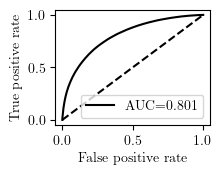


Linear_Transform_y_proba()

a = 0.000, b = 1.000

Analyze_Prediction()
BRFC_5_Fold_alpha_0_5_Hard_Test_Transformed_100
Value_Counts_y_proba
713566 3969
152
Finished
Plot_Prediction()
BRFC_5_Fold_alpha_0_5_Hard_Test_Transformed_100
./Images/BRFC_5_Fold_alpha_0_5_Hard_Test_Transformed_100_Pred.png


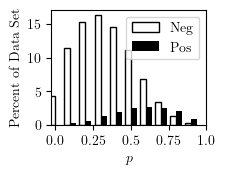


Plot_Prediction()
BRFC_5_Fold_alpha_0_5_Hard_Test_Transformed_100
./Images/BRFC_5_Fold_alpha_0_5_Hard_Test_Transformed_100_Pred_Wide.png


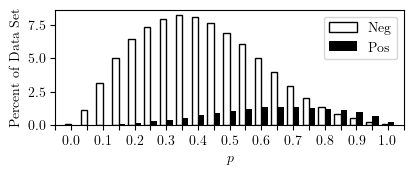


ROC()
BRFC_5_Fold_alpha_0_5_Hard_Test_Transformed_100

len(fpr/tpr) =  3319
[[0.         0.        ]
 [0.00001486 0.00107451]
 [0.00001486 0.0011023 ]
 [0.00001486 0.00111156]
 [0.00001486 0.00113009]
 [0.00001486 0.00113935]
 [0.00006275 0.00271407]
 [0.00006275 0.00272333]
 [0.00006275 0.00276038]
 [0.0000644  0.00278817]]
[[0.         0.        ]
 [0.00001486 0.00107451]
 [0.00001486 0.0011023 ]
 [0.00001486 0.00111156]
 [0.00001486 0.00113009]
 [0.00001486 0.00113935]
 [0.00006275 0.00271407]
 [0.00006275 0.00272333]
 [0.00006275 0.00276038]
 [0.0000644  0.00278817]]
Unique fpr/tpr =  3319

p_values =  []
./Images/BRFC_5_Fold_alpha_0_5_Hard_Test_Transformed_100_ROC.png


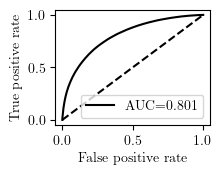


Linear_Transform_y_proba()

a = 0.040, b = 0.960

Analyze_Prediction()
BRFC_5_Fold_alpha_0_5_Hard_Test_Transformed_98
Value_Counts_y_proba
713566 3914
144
Finished
Plot_Prediction()
BRFC_5_Fold_alpha_0_5_Hard_Test_Transformed_98
./Images/BRFC_5_Fold_alpha_0_5_Hard_Test_Transformed_98_Pred.png


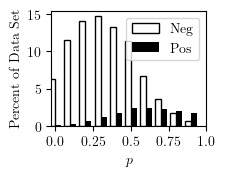


Plot_Prediction()
BRFC_5_Fold_alpha_0_5_Hard_Test_Transformed_98
./Images/BRFC_5_Fold_alpha_0_5_Hard_Test_Transformed_98_Pred_Wide.png


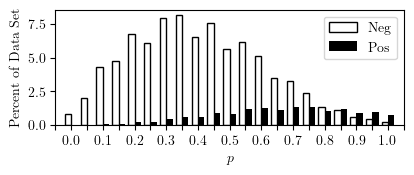


ROC()
BRFC_5_Fold_alpha_0_5_Hard_Test_Transformed_98

len(fpr/tpr) =  3272
[[0.         0.        ]
 [0.00069186 0.01510801]
 [0.00069186 0.01512653]
 [0.00069352 0.01512653]
 [0.00069352 0.01514506]
 [0.00069352 0.01517285]
 [0.00069517 0.01518211]
 [0.00070177 0.01524695]
 [0.00070177 0.01526548]
 [0.00070177 0.015284  ]]
[[0.         0.        ]
 [0.00069186 0.01510801]
 [0.00069186 0.01512653]
 [0.00069352 0.01512653]
 [0.00069352 0.01514506]
 [0.00069352 0.01517285]
 [0.00069517 0.01518211]
 [0.00070177 0.01524695]
 [0.00070177 0.01526548]
 [0.00070177 0.015284  ]]
Unique fpr/tpr =  3272

p_values =  []
./Images/BRFC_5_Fold_alpha_0_5_Hard_Test_Transformed_98_ROC.png


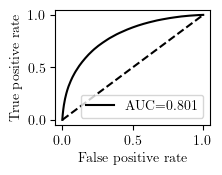


Linear_Transform_y_proba()

a = 0.070, b = 0.940

Analyze_Prediction()
BRFC_5_Fold_alpha_0_5_Hard_Test_Transformed_95
Value_Counts_y_proba
713566 3739
137
Finished
Plot_Prediction()
BRFC_5_Fold_alpha_0_5_Hard_Test_Transformed_95
./Images/BRFC_5_Fold_alpha_0_5_Hard_Test_Transformed_95_Pred.png


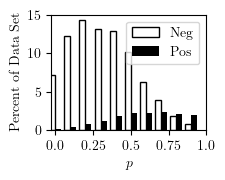


Plot_Prediction()
BRFC_5_Fold_alpha_0_5_Hard_Test_Transformed_95
./Images/BRFC_5_Fold_alpha_0_5_Hard_Test_Transformed_95_Pred_Wide.png


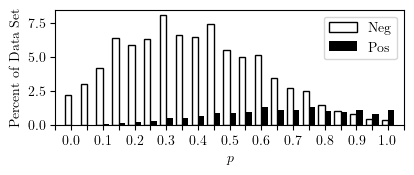


ROC()
BRFC_5_Fold_alpha_0_5_Hard_Test_Transformed_95

len(fpr/tpr) =  3149
[[0.         0.        ]
 [0.00158518 0.0305958 ]
 [0.00158848 0.0305958 ]
 [0.00159013 0.0305958 ]
 [0.00159013 0.03061432]
 [0.00159013 0.03063285]
 [0.00159013 0.0306699 ]
 [0.00159013 0.03071622]
 [0.00159013 0.03072548]
 [0.00159178 0.03075327]]
[[0.         0.        ]
 [0.00158518 0.0305958 ]
 [0.00158848 0.0305958 ]
 [0.00159013 0.0305958 ]
 [0.00159013 0.03061432]
 [0.00159013 0.03063285]
 [0.00159013 0.0306699 ]
 [0.00159013 0.03071622]
 [0.00159013 0.03072548]
 [0.00159178 0.03075327]]
Unique fpr/tpr =  3149

p_values =  []
./Images/BRFC_5_Fold_alpha_0_5_Hard_Test_Transformed_95_ROC.png


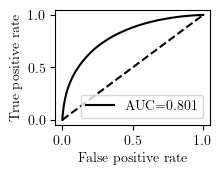





------------------------

BRFC_5_Fold_alpha_balanced_Hard

K-fold iteration =  0
K-fold iteration =  1
K-fold iteration =  2
K-fold iteration =  3
K-fold iteration =  4
Analyze_Prediction()
BRFC_5_Fold_alpha_balanced_Hard_Test
Value_Counts_y_proba
713566 6027
158
Finished
Plot_Prediction()
BRFC_5_Fold_alpha_balanced_Hard_Test
./Images/BRFC_5_Fold_alpha_balanced_Hard_Test_Pred.png


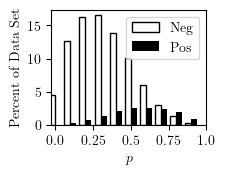


Plot_Prediction()
BRFC_5_Fold_alpha_balanced_Hard_Test
./Images/BRFC_5_Fold_alpha_balanced_Hard_Test_Pred_Wide.png


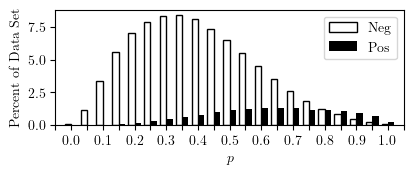


ROC()
BRFC_5_Fold_alpha_balanced_Hard_Test

len(fpr/tpr) =  4440
[[0.         0.        ]
 [0.00001486 0.00101893]
 [0.00001486 0.00103746]
 [0.00001651 0.00106525]
 [0.00001981 0.00106525]
 [0.00001981 0.00108377]
 [0.00008752 0.00276965]
 [0.00008752 0.00278817]
 [0.00008752 0.0028067 ]
 [0.00008752 0.00283449]]
[[0.         0.        ]
 [0.00001486 0.00101893]
 [0.00001486 0.00103746]
 [0.00001651 0.00106525]
 [0.00001981 0.00106525]
 [0.00001981 0.00108377]
 [0.00008752 0.00276965]
 [0.00008752 0.00278817]
 [0.00008752 0.0028067 ]
 [0.00008752 0.00283449]]
Unique fpr/tpr =  4440

p_values =  []
./Images/BRFC_5_Fold_alpha_balanced_Hard_Test_ROC.png


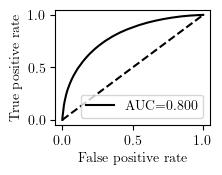


Linear_Transform_y_proba()

a = 0.000, b = 1.000

Analyze_Prediction()
BRFC_5_Fold_alpha_balanced_Hard_Test_Transformed_100
Value_Counts_y_proba
713566 6027
158
Finished
Plot_Prediction()
BRFC_5_Fold_alpha_balanced_Hard_Test_Transformed_100
./Images/BRFC_5_Fold_alpha_balanced_Hard_Test_Transformed_100_Pred.png


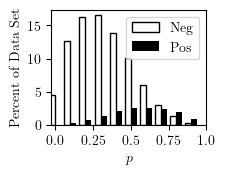


Plot_Prediction()
BRFC_5_Fold_alpha_balanced_Hard_Test_Transformed_100
./Images/BRFC_5_Fold_alpha_balanced_Hard_Test_Transformed_100_Pred_Wide.png


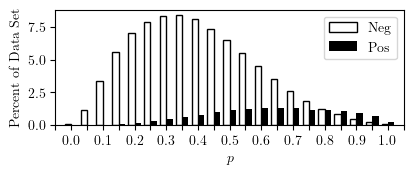


ROC()
BRFC_5_Fold_alpha_balanced_Hard_Test_Transformed_100

len(fpr/tpr) =  4440
[[0.         0.        ]
 [0.00001486 0.00101893]
 [0.00001486 0.00103746]
 [0.00001651 0.00106525]
 [0.00001981 0.00106525]
 [0.00001981 0.00108377]
 [0.00008752 0.00276965]
 [0.00008752 0.00278817]
 [0.00008752 0.0028067 ]
 [0.00008752 0.00283449]]
[[0.         0.        ]
 [0.00001486 0.00101893]
 [0.00001486 0.00103746]
 [0.00001651 0.00106525]
 [0.00001981 0.00106525]
 [0.00001981 0.00108377]
 [0.00008752 0.00276965]
 [0.00008752 0.00278817]
 [0.00008752 0.0028067 ]
 [0.00008752 0.00283449]]
Unique fpr/tpr =  4440

p_values =  []
./Images/BRFC_5_Fold_alpha_balanced_Hard_Test_Transformed_100_ROC.png


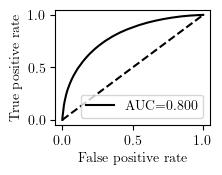


Linear_Transform_y_proba()

a = 0.047, b = 0.961

Analyze_Prediction()
BRFC_5_Fold_alpha_balanced_Hard_Test_Transformed_98
Value_Counts_y_proba
713566 5950
150
Finished
Plot_Prediction()
BRFC_5_Fold_alpha_balanced_Hard_Test_Transformed_98
./Images/BRFC_5_Fold_alpha_balanced_Hard_Test_Transformed_98_Pred.png


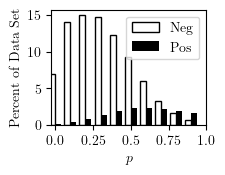


Plot_Prediction()
BRFC_5_Fold_alpha_balanced_Hard_Test_Transformed_98
./Images/BRFC_5_Fold_alpha_balanced_Hard_Test_Transformed_98_Pred_Wide.png


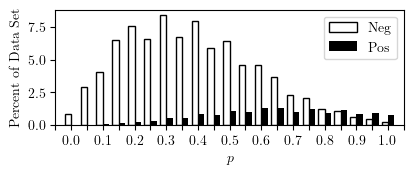


ROC()
BRFC_5_Fold_alpha_balanced_Hard_Test_Transformed_98

len(fpr/tpr) =  4383
[[0.         0.        ]
 [0.00042271 0.01000408]
 [0.00071003 0.01497832]
 [0.00071003 0.01498759]
 [0.00071003 0.01500611]
 [0.00071003 0.0150339 ]
 [0.00071003 0.01504317]
 [0.00071498 0.01508948]
 [0.00071663 0.01508948]
 [0.00071663 0.01510801]]
[[0.         0.        ]
 [0.00042271 0.01000408]
 [0.00071003 0.01497832]
 [0.00071003 0.01498759]
 [0.00071003 0.01500611]
 [0.00071003 0.0150339 ]
 [0.00071003 0.01504317]
 [0.00071498 0.01508948]
 [0.00071663 0.01508948]
 [0.00071663 0.01510801]]
Unique fpr/tpr =  4383

p_values =  []
./Images/BRFC_5_Fold_alpha_balanced_Hard_Test_Transformed_98_ROC.png


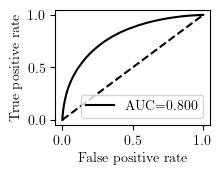


Linear_Transform_y_proba()

a = 0.070, b = 0.940

Analyze_Prediction()
BRFC_5_Fold_alpha_balanced_Hard_Test_Transformed_95
Value_Counts_y_proba
713566 5803
143
Finished
Plot_Prediction()
BRFC_5_Fold_alpha_balanced_Hard_Test_Transformed_95
./Images/BRFC_5_Fold_alpha_balanced_Hard_Test_Transformed_95_Pred.png


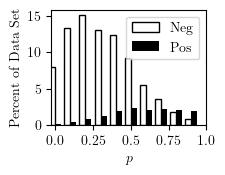


Plot_Prediction()
BRFC_5_Fold_alpha_balanced_Hard_Test_Transformed_95
./Images/BRFC_5_Fold_alpha_balanced_Hard_Test_Transformed_95_Pred_Wide.png


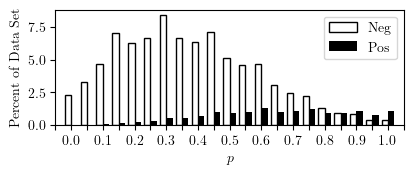


ROC()
BRFC_5_Fold_alpha_balanced_Hard_Test_Transformed_95

len(fpr/tpr) =  4279
[[0.         0.        ]
 [0.00164297 0.03023454]
 [0.00164462 0.0302438 ]
 [0.00164627 0.03028086]
 [0.00164793 0.03032717]
 [0.00164793 0.0303457 ]
 [0.00164793 0.03035496]
 [0.00165123 0.03035496]
 [0.00165783 0.0304939 ]
 [0.00165783 0.03051243]]
[[0.         0.        ]
 [0.00164297 0.03023454]
 [0.00164462 0.0302438 ]
 [0.00164627 0.03028086]
 [0.00164793 0.03032717]
 [0.00164793 0.0303457 ]
 [0.00164793 0.03035496]
 [0.00165123 0.03035496]
 [0.00165783 0.0304939 ]
 [0.00165783 0.03051243]]
Unique fpr/tpr =  4279

p_values =  []
./Images/BRFC_5_Fold_alpha_balanced_Hard_Test_Transformed_95_ROC.png


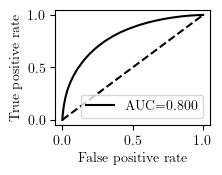





------------------------

LogReg_5_Fold_alpha_0_5_Hard

K-fold iteration =  0
K-fold iteration =  1
K-fold iteration =  2
K-fold iteration =  3
K-fold iteration =  4
Analyze_Prediction()
LogReg_5_Fold_alpha_0_5_Hard_Test
Value_Counts_y_proba
713566 706940
671262
Finished
Plot_Prediction()
LogReg_5_Fold_alpha_0_5_Hard_Test
./Images/LogReg_5_Fold_alpha_0_5_Hard_Test_Pred.png


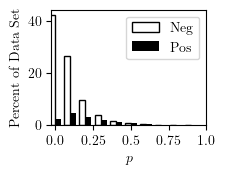


Plot_Prediction()
LogReg_5_Fold_alpha_0_5_Hard_Test
./Images/LogReg_5_Fold_alpha_0_5_Hard_Test_Pred_Wide.png


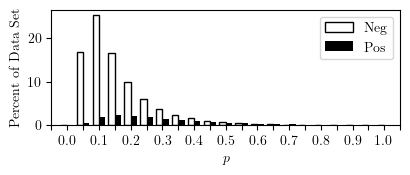


ROC()
LogReg_5_Fold_alpha_0_5_Hard_Test

len(fpr/tpr) =  169761
[[0.         0.        ]
 [0.         0.00000926]
 [0.         0.00002779]
 [0.00000165 0.00002779]
 [0.00000165 0.00005558]
 [0.0000033  0.00005558]
 [0.0000033  0.0000741 ]
 [0.0000066  0.0000741 ]
 [0.0000066  0.00018526]
 [0.00000826 0.00018526]]
[[0.         0.        ]
 [0.         0.00000926]
 [0.         0.00002779]
 [0.00000165 0.00002779]
 [0.00000165 0.00005558]
 [0.0000033  0.00005558]
 [0.0000033  0.0000741 ]
 [0.0000066  0.0000741 ]
 [0.0000066  0.00018526]
 [0.00000826 0.00018526]]
Unique fpr/tpr =  169761

p_values =  []
./Images/LogReg_5_Fold_alpha_0_5_Hard_Test_ROC.png


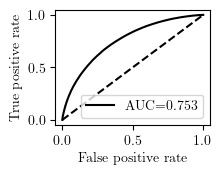


Linear_Transform_y_proba()

a = 0.004, b = 0.915

Analyze_Prediction()
LogReg_5_Fold_alpha_0_5_Hard_Test_Transformed_100
Value_Counts_y_proba
713566 706940
671262
Finished
Plot_Prediction()
LogReg_5_Fold_alpha_0_5_Hard_Test_Transformed_100
./Images/LogReg_5_Fold_alpha_0_5_Hard_Test_Transformed_100_Pred.png


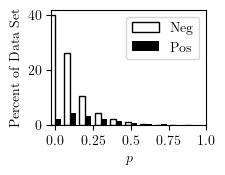


Plot_Prediction()
LogReg_5_Fold_alpha_0_5_Hard_Test_Transformed_100
./Images/LogReg_5_Fold_alpha_0_5_Hard_Test_Transformed_100_Pred_Wide.png


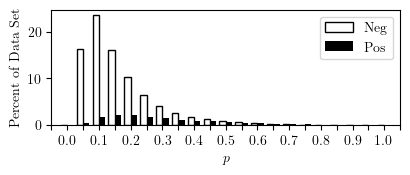


ROC()
LogReg_5_Fold_alpha_0_5_Hard_Test_Transformed_100

len(fpr/tpr) =  169761
[[0.         0.        ]
 [0.         0.00000926]
 [0.         0.00002779]
 [0.00000165 0.00002779]
 [0.00000165 0.00005558]
 [0.0000033  0.00005558]
 [0.0000033  0.0000741 ]
 [0.0000066  0.0000741 ]
 [0.0000066  0.00018526]
 [0.00000826 0.00018526]]
[[0.         0.        ]
 [0.         0.00000926]
 [0.         0.00002779]
 [0.00000165 0.00002779]
 [0.00000165 0.00005558]
 [0.0000033  0.00005558]
 [0.0000033  0.0000741 ]
 [0.0000066  0.0000741 ]
 [0.0000066  0.00018526]
 [0.00000826 0.00018526]]
Unique fpr/tpr =  169761

p_values =  []
./Images/LogReg_5_Fold_alpha_0_5_Hard_Test_Transformed_100_ROC.png


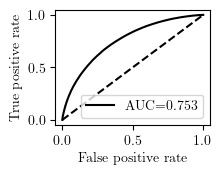


Linear_Transform_y_proba()

a = 0.015, b = 0.754

Analyze_Prediction()
LogReg_5_Fold_alpha_0_5_Hard_Test_Transformed_98
Value_Counts_y_proba
713566 699347
663669
Finished
Plot_Prediction()
LogReg_5_Fold_alpha_0_5_Hard_Test_Transformed_98
./Images/LogReg_5_Fold_alpha_0_5_Hard_Test_Transformed_98_Pred.png


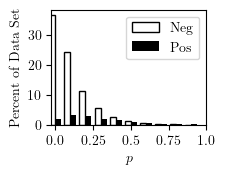


Plot_Prediction()
LogReg_5_Fold_alpha_0_5_Hard_Test_Transformed_98
./Images/LogReg_5_Fold_alpha_0_5_Hard_Test_Transformed_98_Pred_Wide.png


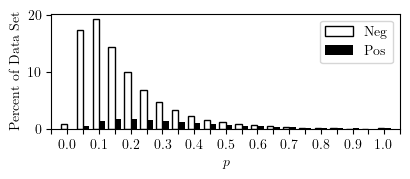


ROC()
LogReg_5_Fold_alpha_0_5_Hard_Test_Transformed_98

len(fpr/tpr) =  168957
[[0.         0.        ]
 [0.00072654 0.01000408]
 [0.00072654 0.0100226 ]
 [0.00072819 0.0100226 ]
 [0.00072819 0.01009671]
 [0.00073149 0.01009671]
 [0.00073149 0.01011523]
 [0.00073315 0.01011523]
 [0.00073315 0.0101245 ]
 [0.00073645 0.0101245 ]]
[[0.         0.        ]
 [0.00072654 0.01000408]
 [0.00072654 0.0100226 ]
 [0.00072819 0.0100226 ]
 [0.00072819 0.01009671]
 [0.00073149 0.01009671]
 [0.00073149 0.01011523]
 [0.00073315 0.01011523]
 [0.00073315 0.0101245 ]
 [0.00073645 0.0101245 ]]
Unique fpr/tpr =  168957

p_values =  []
./Images/LogReg_5_Fold_alpha_0_5_Hard_Test_Transformed_98_ROC.png


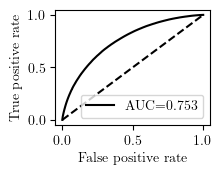


Linear_Transform_y_proba()

a = 0.020, b = 0.671

Analyze_Prediction()
LogReg_5_Fold_alpha_0_5_Hard_Test_Transformed_95
Value_Counts_y_proba
713566 687609
651931
Finished
Plot_Prediction()
LogReg_5_Fold_alpha_0_5_Hard_Test_Transformed_95
./Images/LogReg_5_Fold_alpha_0_5_Hard_Test_Transformed_95_Pred.png


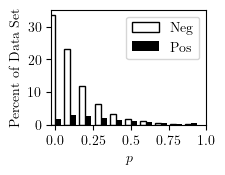


Plot_Prediction()
LogReg_5_Fold_alpha_0_5_Hard_Test_Transformed_95
./Images/LogReg_5_Fold_alpha_0_5_Hard_Test_Transformed_95_Pred_Wide.png


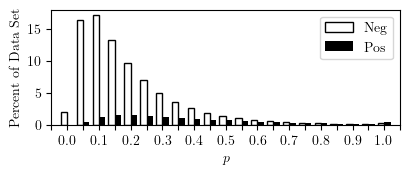


ROC()
LogReg_5_Fold_alpha_0_5_Hard_Test_Transformed_95

len(fpr/tpr) =  167352
[[0.         0.        ]
 [0.00237777 0.02500093]
 [0.00237777 0.02502872]
 [0.00237942 0.02502872]
 [0.00237942 0.02503798]
 [0.00238437 0.02503798]
 [0.00238437 0.0250565 ]
 [0.00238602 0.0250565 ]
 [0.00238602 0.02506577]
 [0.00238768 0.02506577]]
[[0.         0.        ]
 [0.00237777 0.02500093]
 [0.00237777 0.02502872]
 [0.00237942 0.02502872]
 [0.00237942 0.02503798]
 [0.00238437 0.02503798]
 [0.00238437 0.0250565 ]
 [0.00238602 0.0250565 ]
 [0.00238602 0.02506577]
 [0.00238768 0.02506577]]
Unique fpr/tpr =  167352

p_values =  []
./Images/LogReg_5_Fold_alpha_0_5_Hard_Test_Transformed_95_ROC.png


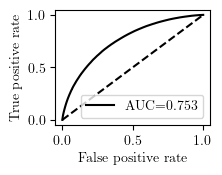





------------------------

LogReg_5_Fold_alpha_balanced_Hard

K-fold iteration =  0
K-fold iteration =  1
K-fold iteration =  2
K-fold iteration =  3
K-fold iteration =  4
Analyze_Prediction()
LogReg_5_Fold_alpha_balanced_Hard_Test
Value_Counts_y_proba
713566 706940
671262
Finished
Plot_Prediction()
LogReg_5_Fold_alpha_balanced_Hard_Test
./Images/LogReg_5_Fold_alpha_balanced_Hard_Test_Pred.png


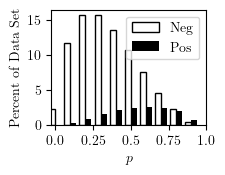


Plot_Prediction()
LogReg_5_Fold_alpha_balanced_Hard_Test
./Images/LogReg_5_Fold_alpha_balanced_Hard_Test_Pred_Wide.png


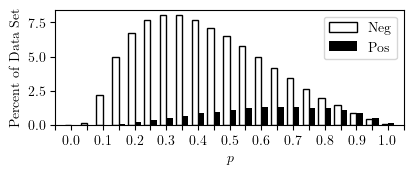


ROC()
LogReg_5_Fold_alpha_balanced_Hard_Test

len(fpr/tpr) =  169693
[[0.         0.        ]
 [0.         0.00000926]
 [0.0000033  0.00000926]
 [0.0000033  0.00003705]
 [0.00000495 0.00003705]
 [0.00000495 0.00010189]
 [0.0000066  0.00010189]
 [0.0000066  0.00018526]
 [0.00000991 0.00018526]
 [0.00000991 0.00024084]]
[[0.         0.        ]
 [0.         0.00000926]
 [0.0000033  0.00000926]
 [0.0000033  0.00003705]
 [0.00000495 0.00003705]
 [0.00000495 0.00010189]
 [0.0000066  0.00010189]
 [0.0000066  0.00018526]
 [0.00000991 0.00018526]
 [0.00000991 0.00024084]]
Unique fpr/tpr =  169693

p_values =  []
./Images/LogReg_5_Fold_alpha_balanced_Hard_Test_ROC.png


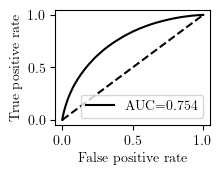


Linear_Transform_y_proba()

a = 0.017, b = 0.989

Analyze_Prediction()
LogReg_5_Fold_alpha_balanced_Hard_Test_Transformed_100
Value_Counts_y_proba
713566 706940
671262
Finished
Plot_Prediction()
LogReg_5_Fold_alpha_balanced_Hard_Test_Transformed_100
./Images/LogReg_5_Fold_alpha_balanced_Hard_Test_Transformed_100_Pred.png


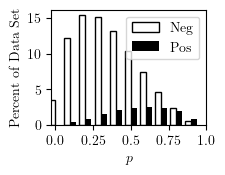


Plot_Prediction()
LogReg_5_Fold_alpha_balanced_Hard_Test_Transformed_100
./Images/LogReg_5_Fold_alpha_balanced_Hard_Test_Transformed_100_Pred_Wide.png


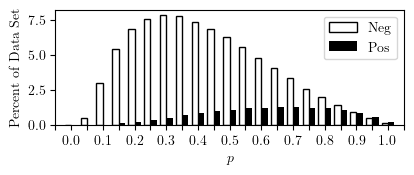


ROC()
LogReg_5_Fold_alpha_balanced_Hard_Test_Transformed_100

len(fpr/tpr) =  169693
[[0.         0.        ]
 [0.         0.00000926]
 [0.0000033  0.00000926]
 [0.0000033  0.00003705]
 [0.00000495 0.00003705]
 [0.00000495 0.00010189]
 [0.0000066  0.00010189]
 [0.0000066  0.00018526]
 [0.00000991 0.00018526]
 [0.00000991 0.00024084]]
[[0.         0.        ]
 [0.         0.00000926]
 [0.0000033  0.00000926]
 [0.0000033  0.00003705]
 [0.00000495 0.00003705]
 [0.00000495 0.00010189]
 [0.0000066  0.00010189]
 [0.0000066  0.00018526]
 [0.00000991 0.00018526]
 [0.00000991 0.00024084]]
Unique fpr/tpr =  169693

p_values =  []
./Images/LogReg_5_Fold_alpha_balanced_Hard_Test_Transformed_100_ROC.png


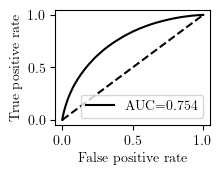


Linear_Transform_y_proba()

a = 0.074, b = 0.950

Analyze_Prediction()
LogReg_5_Fold_alpha_balanced_Hard_Test_Transformed_98
Value_Counts_y_proba
713566 699298
663620
Finished
Plot_Prediction()
LogReg_5_Fold_alpha_balanced_Hard_Test_Transformed_98
./Images/LogReg_5_Fold_alpha_balanced_Hard_Test_Transformed_98_Pred.png


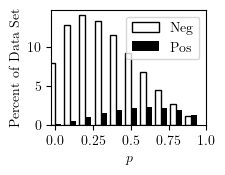


Plot_Prediction()
LogReg_5_Fold_alpha_balanced_Hard_Test_Transformed_98
./Images/LogReg_5_Fold_alpha_balanced_Hard_Test_Transformed_98_Pred_Wide.png


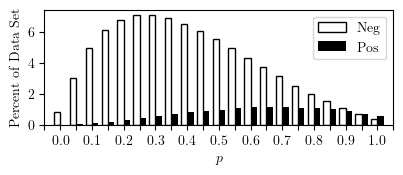


ROC()
LogReg_5_Fold_alpha_balanced_Hard_Test_Transformed_98

len(fpr/tpr) =  168873
[[0.         0.        ]
 [0.0008025  0.01000408]
 [0.00080415 0.01000408]
 [0.00080415 0.0100226 ]
 [0.0008091  0.0100226 ]
 [0.0008091  0.01006892]
 [0.0008124  0.01006892]
 [0.0008124  0.01008744]
 [0.00081406 0.01008744]
 [0.00081406 0.01009671]]
[[0.         0.        ]
 [0.0008025  0.01000408]
 [0.00080415 0.01000408]
 [0.00080415 0.0100226 ]
 [0.0008091  0.0100226 ]
 [0.0008091  0.01006892]
 [0.0008124  0.01006892]
 [0.0008124  0.01008744]
 [0.00081406 0.01008744]
 [0.00081406 0.01009671]]
Unique fpr/tpr =  168873

p_values =  []
./Images/LogReg_5_Fold_alpha_balanced_Hard_Test_Transformed_98_ROC.png


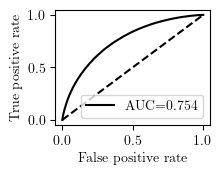


Linear_Transform_y_proba()

a = 0.097, b = 0.926

Analyze_Prediction()
LogReg_5_Fold_alpha_balanced_Hard_Test_Transformed_95
Value_Counts_y_proba
713566 687481
651803
Finished
Plot_Prediction()
LogReg_5_Fold_alpha_balanced_Hard_Test_Transformed_95
./Images/LogReg_5_Fold_alpha_balanced_Hard_Test_Transformed_95_Pred.png


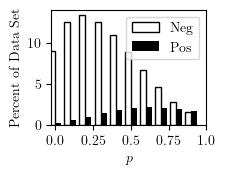


Plot_Prediction()
LogReg_5_Fold_alpha_balanced_Hard_Test_Transformed_95
./Images/LogReg_5_Fold_alpha_balanced_Hard_Test_Transformed_95_Pred_Wide.png


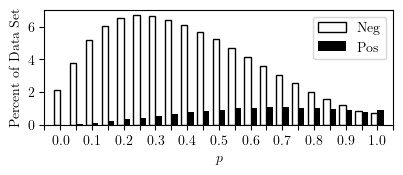


ROC()
LogReg_5_Fold_alpha_balanced_Hard_Test_Transformed_95

len(fpr/tpr) =  167244
[[0.         0.        ]
 [0.00258913 0.02500093]
 [0.00258913 0.02501019]
 [0.00259573 0.02501019]
 [0.00259573 0.02501945]
 [0.00259738 0.02501945]
 [0.00259738 0.0250565 ]
 [0.00260233 0.0250565 ]
 [0.00260233 0.02506577]
 [0.00260399 0.02506577]]
[[0.         0.        ]
 [0.00258913 0.02500093]
 [0.00258913 0.02501019]
 [0.00259573 0.02501019]
 [0.00259573 0.02501945]
 [0.00259738 0.02501945]
 [0.00259738 0.0250565 ]
 [0.00260233 0.0250565 ]
 [0.00260233 0.02506577]
 [0.00260399 0.02506577]]
Unique fpr/tpr =  167244

p_values =  []
./Images/LogReg_5_Fold_alpha_balanced_Hard_Test_Transformed_95_ROC.png


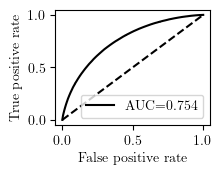





------------------------

AdaBoost_5_Fold_Hard

K-fold iteration =  0
K-fold iteration =  1
K-fold iteration =  2
K-fold iteration =  3
K-fold iteration =  4
Analyze_Prediction()
AdaBoost_5_Fold_Hard_Test
Value_Counts_y_proba
713566 705474
669796
Finished
Plot_Prediction()
AdaBoost_5_Fold_Hard_Test
./Images/AdaBoost_5_Fold_Hard_Test_Pred.png


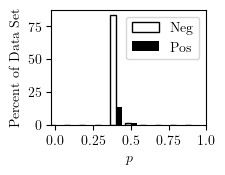


Plot_Prediction()
AdaBoost_5_Fold_Hard_Test
./Images/AdaBoost_5_Fold_Hard_Test_Pred_Wide.png


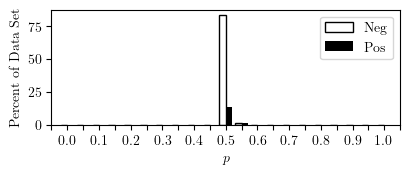


ROC()
AdaBoost_5_Fold_Hard_Test

len(fpr/tpr) =  172309
[[0.         0.        ]
 [0.         0.00000926]
 [0.0000033  0.00000926]
 [0.0000033  0.00004632]
 [0.00000495 0.00005558]
 [0.00000495 0.00008337]
 [0.0000066  0.00008337]
 [0.0000066  0.00010189]
 [0.00000826 0.00010189]
 [0.00000826 0.00027789]]
[[0.         0.        ]
 [0.         0.00000926]
 [0.0000033  0.00000926]
 [0.0000033  0.00004632]
 [0.00000495 0.00005558]
 [0.00000495 0.00008337]
 [0.0000066  0.00008337]
 [0.0000066  0.00010189]
 [0.00000826 0.00010189]
 [0.00000826 0.00027789]]
Unique fpr/tpr =  172309

p_values =  []
./Images/AdaBoost_5_Fold_Hard_Test_ROC.png


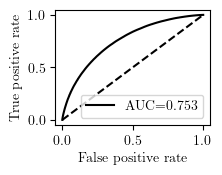


Linear_Transform_y_proba()

a = 0.486, b = 0.507

Analyze_Prediction()
AdaBoost_5_Fold_Hard_Test_Transformed_100
Value_Counts_y_proba
713566 705474
669796
Finished
Plot_Prediction()
AdaBoost_5_Fold_Hard_Test_Transformed_100
./Images/AdaBoost_5_Fold_Hard_Test_Transformed_100_Pred.png


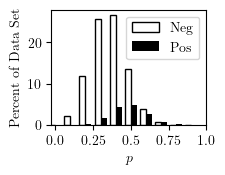


Plot_Prediction()
AdaBoost_5_Fold_Hard_Test_Transformed_100
./Images/AdaBoost_5_Fold_Hard_Test_Transformed_100_Pred_Wide.png


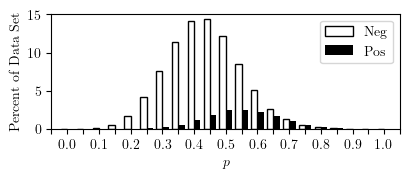


ROC()
AdaBoost_5_Fold_Hard_Test_Transformed_100

len(fpr/tpr) =  172309
[[0.         0.        ]
 [0.         0.00000926]
 [0.0000033  0.00000926]
 [0.0000033  0.00004632]
 [0.00000495 0.00005558]
 [0.00000495 0.00008337]
 [0.0000066  0.00008337]
 [0.0000066  0.00010189]
 [0.00000826 0.00010189]
 [0.00000826 0.00027789]]
[[0.         0.        ]
 [0.         0.00000926]
 [0.0000033  0.00000926]
 [0.0000033  0.00004632]
 [0.00000495 0.00005558]
 [0.00000495 0.00008337]
 [0.0000066  0.00008337]
 [0.0000066  0.00010189]
 [0.00000826 0.00010189]
 [0.00000826 0.00027789]]
Unique fpr/tpr =  172309

p_values =  []
./Images/AdaBoost_5_Fold_Hard_Test_Transformed_100_ROC.png


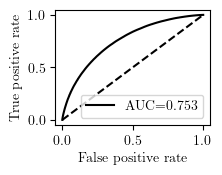


Linear_Transform_y_proba()

a = 0.489, b = 0.503

Analyze_Prediction()
AdaBoost_5_Fold_Hard_Test_Transformed_98
Value_Counts_y_proba
713566 697842
662164
Finished
Plot_Prediction()
AdaBoost_5_Fold_Hard_Test_Transformed_98
./Images/AdaBoost_5_Fold_Hard_Test_Transformed_98_Pred.png


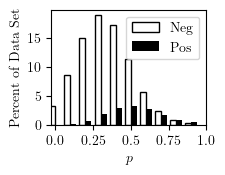


Plot_Prediction()
AdaBoost_5_Fold_Hard_Test_Transformed_98
./Images/AdaBoost_5_Fold_Hard_Test_Transformed_98_Pred_Wide.png


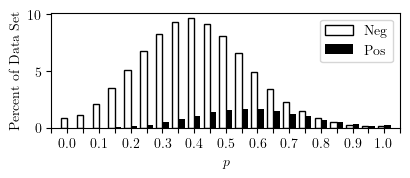


ROC()
AdaBoost_5_Fold_Hard_Test_Transformed_98

len(fpr/tpr) =  171314
[[0.         0.        ]
 [0.0008735  0.01000408]
 [0.0008735  0.01001334]
 [0.00087515 0.01001334]
 [0.00087515 0.01006892]
 [0.0008768  0.01006892]
 [0.0008768  0.01011523]
 [0.00087845 0.01011523]
 [0.00087845 0.01015228]
 [0.0008801  0.01015228]]
[[0.         0.        ]
 [0.0008735  0.01000408]
 [0.0008735  0.01001334]
 [0.00087515 0.01001334]
 [0.00087515 0.01006892]
 [0.0008768  0.01006892]
 [0.0008768  0.01011523]
 [0.00087845 0.01011523]
 [0.00087845 0.01015228]
 [0.0008801  0.01015228]]
Unique fpr/tpr =  171314

p_values =  []
./Images/AdaBoost_5_Fold_Hard_Test_Transformed_98_ROC.png


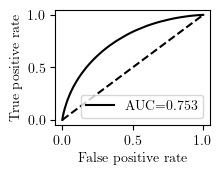


Linear_Transform_y_proba()

a = 0.490, b = 0.502

Analyze_Prediction()
AdaBoost_5_Fold_Hard_Test_Transformed_95
Value_Counts_y_proba
713566 686055
650377
Finished
Plot_Prediction()
AdaBoost_5_Fold_Hard_Test_Transformed_95
./Images/AdaBoost_5_Fold_Hard_Test_Transformed_95_Pred.png


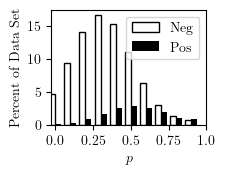


Plot_Prediction()
AdaBoost_5_Fold_Hard_Test_Transformed_95
./Images/AdaBoost_5_Fold_Hard_Test_Transformed_95_Pred_Wide.png


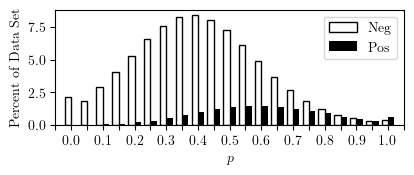


ROC()
AdaBoost_5_Fold_Hard_Test_Transformed_95

len(fpr/tpr) =  169505
[[0.         0.        ]
 [0.00268985 0.02500093]
 [0.00268985 0.02501019]
 [0.0026915  0.02501019]
 [0.0026915  0.02502872]
 [0.0026948  0.02502872]
 [0.0026948  0.02503798]
 [0.00269811 0.02503798]
 [0.00269811 0.0250565 ]
 [0.00269976 0.0250565 ]]
[[0.         0.        ]
 [0.00268985 0.02500093]
 [0.00268985 0.02501019]
 [0.0026915  0.02501019]
 [0.0026915  0.02502872]
 [0.0026948  0.02502872]
 [0.0026948  0.02503798]
 [0.00269811 0.02503798]
 [0.00269811 0.0250565 ]
 [0.00269976 0.0250565 ]]
Unique fpr/tpr =  169505

p_values =  []
./Images/AdaBoost_5_Fold_Hard_Test_Transformed_95_ROC.png


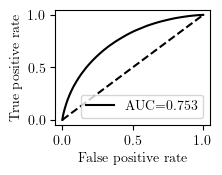





------------------------

BalBag_5_Fold_Hard

K-fold iteration =  0
K-fold iteration =  1
K-fold iteration =  2
K-fold iteration =  3
K-fold iteration =  4
Analyze_Prediction()
BalBag_5_Fold_Hard_Test
Value_Counts_y_proba
713566 260
9
Finished
Plot_Prediction()
BalBag_5_Fold_Hard_Test
./Images/BalBag_5_Fold_Hard_Test_Pred.png


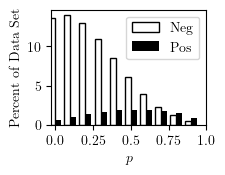


Plot_Prediction()
BalBag_5_Fold_Hard_Test
./Images/BalBag_5_Fold_Hard_Test_Pred_Wide.png


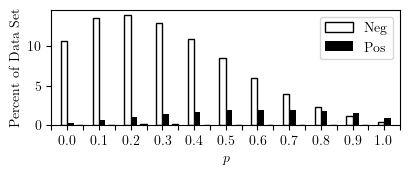


ROC()
BalBag_5_Fold_Hard_Test

len(fpr/tpr) =  243
[[0.         0.        ]
 [0.00531695 0.06102486]
 [0.00531695 0.06103413]
 [0.00532191 0.0610897 ]
 [0.00533347 0.06118233]
 [0.00533512 0.06118233]
 [0.00534502 0.0612657 ]
 [0.00536319 0.06133981]
 [0.00536484 0.06133981]
 [0.00536649 0.06134907]]
[[0.         0.        ]
 [0.00531695 0.06102486]
 [0.00531695 0.06103413]
 [0.00532191 0.0610897 ]
 [0.00533347 0.06118233]
 [0.00533512 0.06118233]
 [0.00534502 0.0612657 ]
 [0.00536319 0.06133981]
 [0.00536484 0.06133981]
 [0.00536649 0.06134907]]
Unique fpr/tpr =  243

p_values =  []
./Images/BalBag_5_Fold_Hard_Test_ROC.png


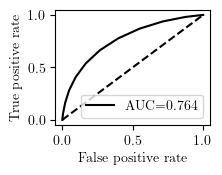


Linear_Transform_y_proba()

a = 0.000, b = 1.000

Analyze_Prediction()
BalBag_5_Fold_Hard_Test_Transformed_100
Value_Counts_y_proba
713566 260
9
Finished
Plot_Prediction()
BalBag_5_Fold_Hard_Test_Transformed_100
./Images/BalBag_5_Fold_Hard_Test_Transformed_100_Pred.png


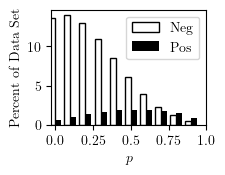


Plot_Prediction()
BalBag_5_Fold_Hard_Test_Transformed_100
./Images/BalBag_5_Fold_Hard_Test_Transformed_100_Pred_Wide.png


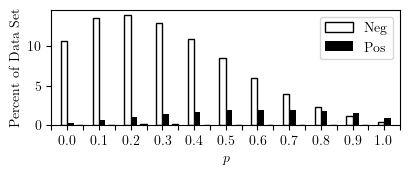


ROC()
BalBag_5_Fold_Hard_Test_Transformed_100

len(fpr/tpr) =  243
[[0.         0.        ]
 [0.00531695 0.06102486]
 [0.00531695 0.06103413]
 [0.00532191 0.0610897 ]
 [0.00533347 0.06118233]
 [0.00533512 0.06118233]
 [0.00534502 0.0612657 ]
 [0.00536319 0.06133981]
 [0.00536484 0.06133981]
 [0.00536649 0.06134907]]
[[0.         0.        ]
 [0.00531695 0.06102486]
 [0.00531695 0.06103413]
 [0.00532191 0.0610897 ]
 [0.00533347 0.06118233]
 [0.00533512 0.06118233]
 [0.00534502 0.0612657 ]
 [0.00536319 0.06133981]
 [0.00536484 0.06133981]
 [0.00536649 0.06134907]]
Unique fpr/tpr =  243

p_values =  []
./Images/BalBag_5_Fold_Hard_Test_Transformed_100_ROC.png


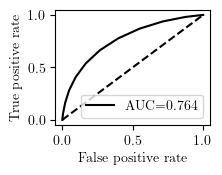


Linear_Transform_y_proba()

a = 0.000, b = 1.000

Analyze_Prediction()
BalBag_5_Fold_Hard_Test_Transformed_98
Value_Counts_y_proba
713566 260
9
Finished
Plot_Prediction()
BalBag_5_Fold_Hard_Test_Transformed_98
./Images/BalBag_5_Fold_Hard_Test_Transformed_98_Pred.png


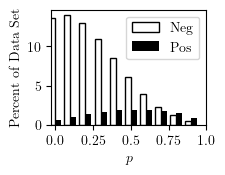


Plot_Prediction()
BalBag_5_Fold_Hard_Test_Transformed_98
./Images/BalBag_5_Fold_Hard_Test_Transformed_98_Pred_Wide.png


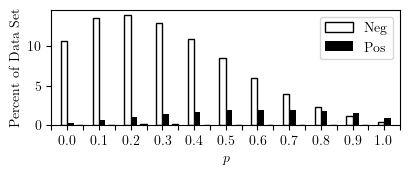


ROC()
BalBag_5_Fold_Hard_Test_Transformed_98

len(fpr/tpr) =  243
[[0.         0.        ]
 [0.00531695 0.06102486]
 [0.00531695 0.06103413]
 [0.00532191 0.0610897 ]
 [0.00533347 0.06118233]
 [0.00533512 0.06118233]
 [0.00534502 0.0612657 ]
 [0.00536319 0.06133981]
 [0.00536484 0.06133981]
 [0.00536649 0.06134907]]
[[0.         0.        ]
 [0.00531695 0.06102486]
 [0.00531695 0.06103413]
 [0.00532191 0.0610897 ]
 [0.00533347 0.06118233]
 [0.00533512 0.06118233]
 [0.00534502 0.0612657 ]
 [0.00536319 0.06133981]
 [0.00536484 0.06133981]
 [0.00536649 0.06134907]]
Unique fpr/tpr =  243

p_values =  []
./Images/BalBag_5_Fold_Hard_Test_Transformed_98_ROC.png


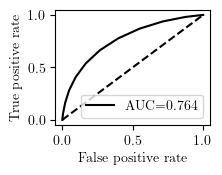


Linear_Transform_y_proba()

a = 0.000, b = 1.000

Analyze_Prediction()
BalBag_5_Fold_Hard_Test_Transformed_95
Value_Counts_y_proba
713566 260
9
Finished
Plot_Prediction()
BalBag_5_Fold_Hard_Test_Transformed_95
./Images/BalBag_5_Fold_Hard_Test_Transformed_95_Pred.png


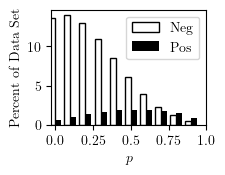


Plot_Prediction()
BalBag_5_Fold_Hard_Test_Transformed_95
./Images/BalBag_5_Fold_Hard_Test_Transformed_95_Pred_Wide.png


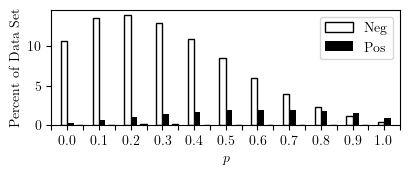


ROC()
BalBag_5_Fold_Hard_Test_Transformed_95

len(fpr/tpr) =  243
[[0.         0.        ]
 [0.00531695 0.06102486]
 [0.00531695 0.06103413]
 [0.00532191 0.0610897 ]
 [0.00533347 0.06118233]
 [0.00533512 0.06118233]
 [0.00534502 0.0612657 ]
 [0.00536319 0.06133981]
 [0.00536484 0.06133981]
 [0.00536649 0.06134907]]
[[0.         0.        ]
 [0.00531695 0.06102486]
 [0.00531695 0.06103413]
 [0.00532191 0.0610897 ]
 [0.00533347 0.06118233]
 [0.00533512 0.06118233]
 [0.00534502 0.0612657 ]
 [0.00536319 0.06133981]
 [0.00536484 0.06133981]
 [0.00536649 0.06134907]]
Unique fpr/tpr =  243

p_values =  []
./Images/BalBag_5_Fold_Hard_Test_Transformed_95_ROC.png


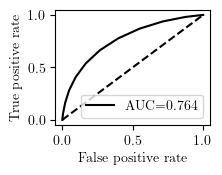





------------------------

EEC_5_Fold_Hard

K-fold iteration =  0
K-fold iteration =  1
K-fold iteration =  2
K-fold iteration =  3
K-fold iteration =  4
Analyze_Prediction()
EEC_5_Fold_Hard_Test
Value_Counts_y_proba
713566 2880
1071
Finished
Plot_Prediction()
EEC_5_Fold_Hard_Test
./Images/EEC_5_Fold_Hard_Test_Pred.png


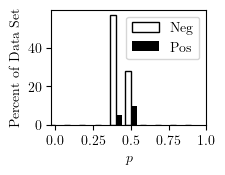


Plot_Prediction()
EEC_5_Fold_Hard_Test
./Images/EEC_5_Fold_Hard_Test_Pred_Wide.png


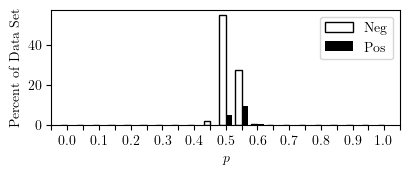


ROC()
EEC_5_Fold_Hard_Test

len(fpr/tpr) =  2853
[[0.         0.        ]
 [0.00000165 0.00001853]
 [0.00000991 0.00003705]
 [0.00001486 0.0000741 ]
 [0.00002477 0.00015747]
 [0.00003137 0.00022231]
 [0.00003798 0.00023158]
 [0.00004623 0.00024084]
 [0.00004789 0.00024084]
 [0.00004954 0.00026863]]
[[0.         0.        ]
 [0.00000165 0.00001853]
 [0.00000991 0.00003705]
 [0.00001486 0.0000741 ]
 [0.00002477 0.00015747]
 [0.00003137 0.00022231]
 [0.00003798 0.00023158]
 [0.00004623 0.00024084]
 [0.00004789 0.00024084]
 [0.00004954 0.00026863]]
Unique fpr/tpr =  2853

p_values =  []
./Images/EEC_5_Fold_Hard_Test_ROC.png


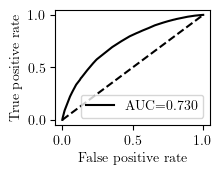


Linear_Transform_y_proba()

a = 0.437, b = 0.592

Analyze_Prediction()
EEC_5_Fold_Hard_Test_Transformed_100
Value_Counts_y_proba
713566 2880
1071
Finished
Plot_Prediction()
EEC_5_Fold_Hard_Test_Transformed_100
./Images/EEC_5_Fold_Hard_Test_Transformed_100_Pred.png


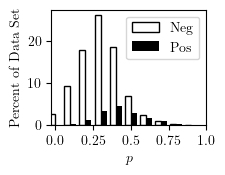


Plot_Prediction()
EEC_5_Fold_Hard_Test_Transformed_100
./Images/EEC_5_Fold_Hard_Test_Transformed_100_Pred_Wide.png


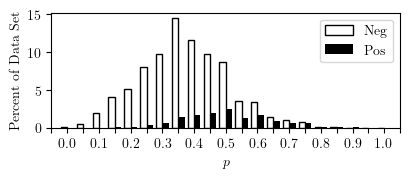


ROC()
EEC_5_Fold_Hard_Test_Transformed_100

len(fpr/tpr) =  2853
[[0.         0.        ]
 [0.00000165 0.00001853]
 [0.00000991 0.00003705]
 [0.00001486 0.0000741 ]
 [0.00002477 0.00015747]
 [0.00003137 0.00022231]
 [0.00003798 0.00023158]
 [0.00004623 0.00024084]
 [0.00004789 0.00024084]
 [0.00004954 0.00026863]]
[[0.         0.        ]
 [0.00000165 0.00001853]
 [0.00000991 0.00003705]
 [0.00001486 0.0000741 ]
 [0.00002477 0.00015747]
 [0.00003137 0.00022231]
 [0.00003798 0.00023158]
 [0.00004623 0.00024084]
 [0.00004789 0.00024084]
 [0.00004954 0.00026863]]
Unique fpr/tpr =  2853

p_values =  []
./Images/EEC_5_Fold_Hard_Test_Transformed_100_ROC.png


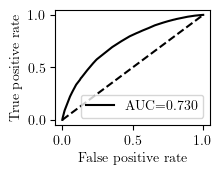


Linear_Transform_y_proba()

a = 0.445, b = 0.568

Analyze_Prediction()
EEC_5_Fold_Hard_Test_Transformed_98
Value_Counts_y_proba
713566 2810
1041
Finished
Plot_Prediction()
EEC_5_Fold_Hard_Test_Transformed_98
./Images/EEC_5_Fold_Hard_Test_Transformed_98_Pred.png


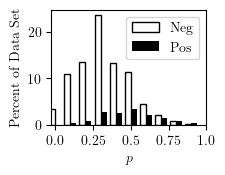


Plot_Prediction()
EEC_5_Fold_Hard_Test_Transformed_98
./Images/EEC_5_Fold_Hard_Test_Transformed_98_Pred_Wide.png


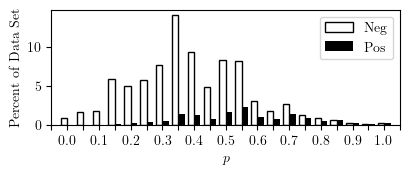


ROC()
EEC_5_Fold_Hard_Test_Transformed_98

len(fpr/tpr) =  2783
[[0.         0.        ]
 [0.0012087  0.00997629]
 [0.00123347 0.01017081]
 [0.00123512 0.01018007]
 [0.00123677 0.01018007]
 [0.00124007 0.01018934]
 [0.00124668 0.01021713]
 [0.00143492 0.01166216]
 [0.00143987 0.01170847]
 [0.00144813 0.01175479]]
[[0.         0.        ]
 [0.0012087  0.00997629]
 [0.00123347 0.01017081]
 [0.00123512 0.01018007]
 [0.00123677 0.01018007]
 [0.00124007 0.01018934]
 [0.00124668 0.01021713]
 [0.00143492 0.01166216]
 [0.00143987 0.01170847]
 [0.00144813 0.01175479]]
Unique fpr/tpr =  2783

p_values =  []
./Images/EEC_5_Fold_Hard_Test_Transformed_98_ROC.png


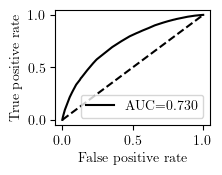


Linear_Transform_y_proba()

a = 0.451, b = 0.558

Analyze_Prediction()
EEC_5_Fold_Hard_Test_Transformed_95
Value_Counts_y_proba
713566 2705
1000
Finished
Plot_Prediction()
EEC_5_Fold_Hard_Test_Transformed_95
./Images/EEC_5_Fold_Hard_Test_Transformed_95_Pred.png


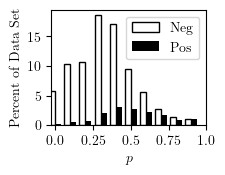


Plot_Prediction()
EEC_5_Fold_Hard_Test_Transformed_95
./Images/EEC_5_Fold_Hard_Test_Transformed_95_Pred_Wide.png


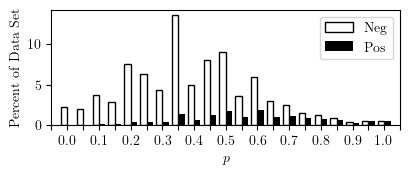


ROC()
EEC_5_Fold_Hard_Test_Transformed_95

len(fpr/tpr) =  2680
[[0.         0.        ]
 [0.00363765 0.02488977]
 [0.00366573 0.02501945]
 [0.00366573 0.02502872]
 [0.00373673 0.02512135]
 [0.00374664 0.0251584 ]
 [0.00374829 0.0251584 ]
 [0.00375489 0.02518619]
 [0.0038358  0.02529734]
 [0.00391176 0.02555671]]
[[0.         0.        ]
 [0.00363765 0.02488977]
 [0.00366573 0.02501945]
 [0.00366573 0.02502872]
 [0.00373673 0.02512135]
 [0.00374664 0.0251584 ]
 [0.00374829 0.0251584 ]
 [0.00375489 0.02518619]
 [0.0038358  0.02529734]
 [0.00391176 0.02555671]]
Unique fpr/tpr =  2680

p_values =  []
./Images/EEC_5_Fold_Hard_Test_Transformed_95_ROC.png


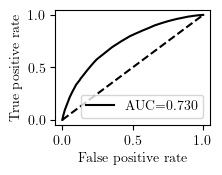





------------------------

RUSBoost_5_Fold_Hard

K-fold iteration =  0
K-fold iteration =  1
K-fold iteration =  2
K-fold iteration =  3
K-fold iteration =  4
Analyze_Prediction()
RUSBoost_5_Fold_Hard_Test
Value_Counts_y_proba
713566 706940
671262
Finished
Plot_Prediction()
RUSBoost_5_Fold_Hard_Test
./Images/RUSBoost_5_Fold_Hard_Test_Pred.png


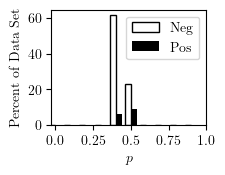


Plot_Prediction()
RUSBoost_5_Fold_Hard_Test
./Images/RUSBoost_5_Fold_Hard_Test_Pred_Wide.png


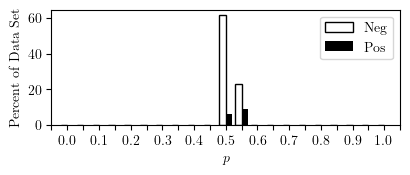


ROC()
RUSBoost_5_Fold_Hard_Test

len(fpr/tpr) =  174932
[[0.         0.        ]
 [0.         0.00000926]
 [0.00001486 0.00000926]
 [0.00001486 0.00001853]
 [0.00001651 0.00001853]
 [0.00001816 0.00002779]
 [0.00001816 0.00004632]
 [0.00002147 0.00004632]
 [0.00002147 0.00005558]
 [0.00002477 0.00005558]]
[[0.         0.        ]
 [0.         0.00000926]
 [0.00001486 0.00000926]
 [0.00001486 0.00001853]
 [0.00001651 0.00001853]
 [0.00001816 0.00002779]
 [0.00001816 0.00004632]
 [0.00002147 0.00004632]
 [0.00002147 0.00005558]
 [0.00002477 0.00005558]]
Unique fpr/tpr =  174932

p_values =  []
./Images/RUSBoost_5_Fold_Hard_Test_ROC.png


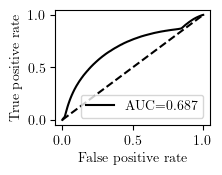


Linear_Transform_y_proba()

a = 0.488, b = 0.520

Analyze_Prediction()
RUSBoost_5_Fold_Hard_Test_Transformed_100
Value_Counts_y_proba
713566 706940
671262
Finished
Plot_Prediction()
RUSBoost_5_Fold_Hard_Test_Transformed_100
./Images/RUSBoost_5_Fold_Hard_Test_Transformed_100_Pred.png


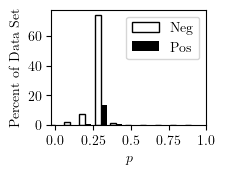


Plot_Prediction()
RUSBoost_5_Fold_Hard_Test_Transformed_100
./Images/RUSBoost_5_Fold_Hard_Test_Transformed_100_Pred_Wide.png


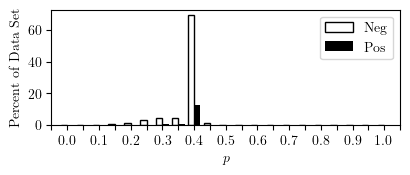


ROC()
RUSBoost_5_Fold_Hard_Test_Transformed_100

len(fpr/tpr) =  174932
[[0.         0.        ]
 [0.         0.00000926]
 [0.00001486 0.00000926]
 [0.00001486 0.00001853]
 [0.00001651 0.00001853]
 [0.00001816 0.00002779]
 [0.00001816 0.00004632]
 [0.00002147 0.00004632]
 [0.00002147 0.00005558]
 [0.00002477 0.00005558]]
[[0.         0.        ]
 [0.         0.00000926]
 [0.00001486 0.00000926]
 [0.00001486 0.00001853]
 [0.00001651 0.00001853]
 [0.00001816 0.00002779]
 [0.00001816 0.00004632]
 [0.00002147 0.00004632]
 [0.00002147 0.00005558]
 [0.00002477 0.00005558]]
Unique fpr/tpr =  174932

p_values =  []
./Images/RUSBoost_5_Fold_Hard_Test_Transformed_100_ROC.png


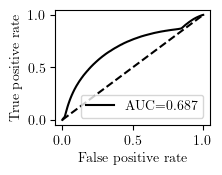


Linear_Transform_y_proba()

a = 0.494, b = 0.502

Analyze_Prediction()
RUSBoost_5_Fold_Hard_Test_Transformed_98
Value_Counts_y_proba
713566 696309
660631
Finished
Plot_Prediction()
RUSBoost_5_Fold_Hard_Test_Transformed_98
./Images/RUSBoost_5_Fold_Hard_Test_Transformed_98_Pred.png


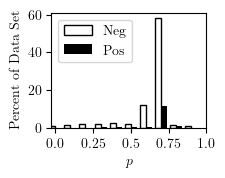


Plot_Prediction()
RUSBoost_5_Fold_Hard_Test_Transformed_98
./Images/RUSBoost_5_Fold_Hard_Test_Transformed_98_Pred_Wide.png


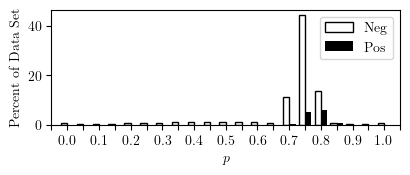


ROC()
RUSBoost_5_Fold_Hard_Test_Transformed_98

len(fpr/tpr) =  172439
[[0.         0.        ]
 [0.00532191 0.01000408]
 [0.00532356 0.01000408]
 [0.00532356 0.01001334]
 [0.00533842 0.01001334]
 [0.00533842 0.0100226 ]
 [0.00534998 0.0100226 ]
 [0.00534998 0.01003186]
 [0.00535328 0.01003186]
 [0.00535328 0.01004113]]
[[0.         0.        ]
 [0.00532191 0.01000408]
 [0.00532356 0.01000408]
 [0.00532356 0.01001334]
 [0.00533842 0.01001334]
 [0.00533842 0.0100226 ]
 [0.00534998 0.0100226 ]
 [0.00534998 0.01003186]
 [0.00535328 0.01003186]
 [0.00535328 0.01004113]]
Unique fpr/tpr =  172439

p_values =  []
./Images/RUSBoost_5_Fold_Hard_Test_Transformed_98_ROC.png


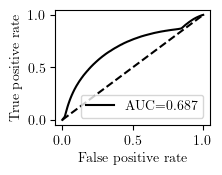


Linear_Transform_y_proba()

a = 0.495, b = 0.501

Analyze_Prediction()
RUSBoost_5_Fold_Hard_Test_Transformed_95
Value_Counts_y_proba
713566 679417
643739
Finished
Plot_Prediction()
RUSBoost_5_Fold_Hard_Test_Transformed_95
./Images/RUSBoost_5_Fold_Hard_Test_Transformed_95_Pred.png


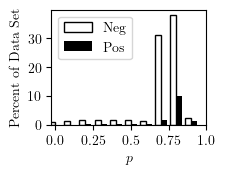


Plot_Prediction()
RUSBoost_5_Fold_Hard_Test_Transformed_95
./Images/RUSBoost_5_Fold_Hard_Test_Transformed_95_Pred_Wide.png


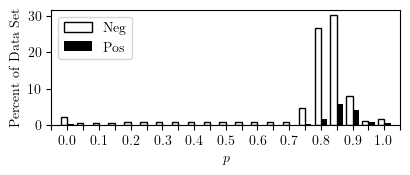


ROC()
RUSBoost_5_Fold_Hard_Test_Transformed_95

len(fpr/tpr) =  168190
[[0.         0.        ]
 [0.01439375 0.02500093]
 [0.01439871 0.02500093]
 [0.01439871 0.02501019]
 [0.01442843 0.02501019]
 [0.01442843 0.02501945]
 [0.0144598  0.02501945]
 [0.0144598  0.02502872]
 [0.01447136 0.02502872]
 [0.01447136 0.02504724]]
[[0.         0.        ]
 [0.01439375 0.02500093]
 [0.01439871 0.02500093]
 [0.01439871 0.02501019]
 [0.01442843 0.02501019]
 [0.01442843 0.02501945]
 [0.0144598  0.02501945]
 [0.0144598  0.02502872]
 [0.01447136 0.02502872]
 [0.01447136 0.02504724]]
Unique fpr/tpr =  168190

p_values =  []
./Images/RUSBoost_5_Fold_Hard_Test_Transformed_95_ROC.png


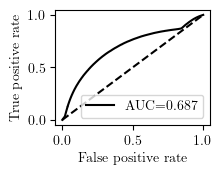





------------------------

KBFC_5_Fold_alpha_0_5_gamma_0_0_Hard



K-fold iteration =  0
len(train_index) =  570852
[     0      2      5 ... 713563 713564 713565]
len(test_index) =  142714
[     1      3      4 ... 713557 713558 713559]

train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
5,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
6,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
7,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713561,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
713562,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713563,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713564,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0



test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
14,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
18,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713539,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
713550,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713557,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713558,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


type(test_fold) =  <class 'pandas.core.frame.DataFrame'>
type(y_test_fold) =  <class 'pandas.core.series.Series'>
len(X_train_fold) =  570852
len(X_test_fold) =  142714
len(y_train_fold) =  570852
len(y_test_fold) =  142714

data.shape =  (713566, 175) 175


2023-12-18 17:45:27.746970: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


X_train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
0,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
5,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
6,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0
7,0,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0


y_train_fold


0    0
2    0
5    0
6    0
7    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_train_fold.value_counts()


0    484488
1     86364
Name: HOSPITAL, dtype: int64

X_test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
1,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
14,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
18,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0


y_test_fold


1     0
3     0
4     0
14    0
18    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_test_fold.value_counts()


0    121122
1     21592
Name: HOSPITAL, dtype: int64

y_proba_fold
[0.078507744, 0.10474317, 0.0077609215, 0.030511206, 0.13555446, 0.04698225, 0.06339526, 0.09879505, 0.042954654, 0.134837]


K-fold iteration =  1
len(train_index) =  570853
[     0      1      3 ... 713561 713562 713563]
len(test_index) =  142713
[     2      6     35 ... 713556 713564 713565]

train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713559,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713560,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713561,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
713562,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0



test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
2,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
6,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
35,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
37,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
38,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713549,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
713552,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713556,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
713564,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


type(test_fold) =  <class 'pandas.core.frame.DataFrame'>
type(y_test_fold) =  <class 'pandas.core.series.Series'>
len(X_train_fold) =  570853
len(X_test_fold) =  142713
len(y_train_fold) =  570853
len(y_test_fold) =  142713

data.shape =  (713566, 175) 175
X_train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
0,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
5,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0


y_train_fold


0    0
1    0
3    0
4    0
5    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_train_fold.value_counts()


0    484488
1     86365
Name: HOSPITAL, dtype: int64

X_test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
2,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
6,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0
35,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
37,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
38,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0


y_test_fold


2     0
6     0
35    1
37    0
38    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_test_fold.value_counts()


0    121122
1     21591
Name: HOSPITAL, dtype: int64

y_proba_fold
[0.0038449285, 0.09735569, 0.20190588, 0.15250231, 0.23264961, 0.061064232, 0.06632007, 0.01944865, 0.009358529, 0.07908043]


K-fold iteration =  2
len(train_index) =  570853
[     1      2      3 ... 713563 713564 713565]
len(test_index) =  142713
[     0     10     12 ... 713542 713543 713553]

train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713561,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
713562,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713563,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713564,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0



test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
10,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
12,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
13,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
21,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713529,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
713535,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
713542,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
713543,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


type(test_fold) =  <class 'pandas.core.frame.DataFrame'>
type(y_test_fold) =  <class 'pandas.core.series.Series'>
len(X_train_fold) =  570853
len(X_test_fold) =  142713
len(y_train_fold) =  570853
len(y_test_fold) =  142713

data.shape =  (713566, 175) 175
X_train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
1,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
2,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
5,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0


y_train_fold


1    0
2    0
3    0
4    0
5    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_train_fold.value_counts()


0    484488
1     86365
Name: HOSPITAL, dtype: int64

X_test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
0,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
10,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
12,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
13,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
21,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0


y_test_fold


0     0
10    0
12    0
13    0
21    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_test_fold.value_counts()


0    121122
1     21591
Name: HOSPITAL, dtype: int64

y_proba_fold
[0.12774487, 0.038963255, 0.034832284, 0.21875091, 0.084391095, 0.08364518, 0.10737971, 0.13806991, 0.017112004, 0.14338793]


K-fold iteration =  3
len(train_index) =  570853
[     0      1      2 ... 713563 713564 713565]
len(test_index) =  142713
[     7      9     15 ... 713555 713560 713562]

train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713559,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713561,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
713563,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713564,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0



test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
7,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
9,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
15,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
19,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
23,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713547,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713554,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
713555,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713560,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


type(test_fold) =  <class 'pandas.core.frame.DataFrame'>
type(y_test_fold) =  <class 'pandas.core.series.Series'>
len(X_train_fold) =  570853
len(X_test_fold) =  142713
len(y_train_fold) =  570853
len(y_test_fold) =  142713

data.shape =  (713566, 175) 175
X_train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
0,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
2,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0


y_train_fold


0    0
1    0
2    0
3    0
4    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_train_fold.value_counts()


0    484488
1     86365
Name: HOSPITAL, dtype: int64

X_test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
7,0,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
9,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
15,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
19,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
23,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1


y_test_fold


7     0
9     0
15    0
19    0
23    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_test_fold.value_counts()


0    121122
1     21591
Name: HOSPITAL, dtype: int64

y_proba_fold
[0.032228325, 0.08751958, 0.024636434, 0.20755129, 0.09273867, 0.086610466, 0.061384767, 0.3343137, 0.0549149, 0.12516305]


K-fold iteration =  4
len(train_index) =  570853
[     0      1      2 ... 713562 713564 713565]
len(test_index) =  142713
[     5      8     11 ... 713551 713561 713563]

train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713559,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713560,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713562,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713564,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0



test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
5,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
8,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
11,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
16,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
17,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713524,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713548,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713551,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
713561,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


type(test_fold) =  <class 'pandas.core.frame.DataFrame'>
type(y_test_fold) =  <class 'pandas.core.series.Series'>
len(X_train_fold) =  570853
len(X_test_fold) =  142713
len(y_train_fold) =  570853
len(y_test_fold) =  142713

data.shape =  (713566, 175) 175
X_train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
0,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
2,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0


y_train_fold


0    0
1    0
2    0
3    0
4    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_train_fold.value_counts()


0    484488
1     86365
Name: HOSPITAL, dtype: int64

X_test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
5,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
8,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
11,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
16,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0
17,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0


y_test_fold


5     0
8     0
11    0
16    0
17    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_test_fold.value_counts()


0    121122
1     21591
Name: HOSPITAL, dtype: int64

y_proba_fold
[0.03828921, 0.091979615, 0.015217577, 0.03457773, 0.04726865, 0.064450234, 0.115579516, 0.16122255, 0.13427764, 0.13098398]
Analyze_Prediction()
KBFC_5_Fold_alpha_0_5_gamma_0_0_Hard_Test
Value_Counts_y_proba
713566 694823
659145
Finished
Plot_Prediction()
KBFC_5_Fold_alpha_0_5_gamma_0_0_Hard_Test
./Images/KBFC_5_Fold_alpha_0_5_gamma_0_0_Hard_Test_Pred.png


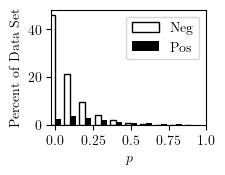


Plot_Prediction()
KBFC_5_Fold_alpha_0_5_gamma_0_0_Hard_Test
./Images/KBFC_5_Fold_alpha_0_5_gamma_0_0_Hard_Test_Pred_Wide.png


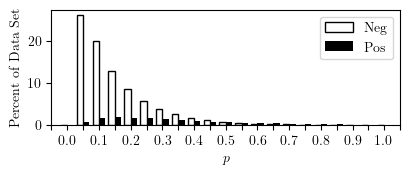


ROC()
KBFC_5_Fold_alpha_0_5_gamma_0_0_Hard_Test

len(fpr/tpr) =  179082
[[0.         0.        ]
 [0.         0.00001853]
 [0.         0.00003705]
 [0.         0.0000741 ]
 [0.         0.00009263]
 [0.         0.00012042]
 [0.         0.00013895]
 [0.         0.00014821]
 [0.00000165 0.00014821]
 [0.00000165 0.00015747]]
[[0.         0.        ]
 [0.         0.00001853]
 [0.         0.00003705]
 [0.         0.0000741 ]
 [0.         0.00009263]
 [0.         0.00012042]
 [0.         0.00013895]
 [0.         0.00014821]
 [0.00000165 0.00014821]
 [0.00000165 0.00015747]]
Unique fpr/tpr =  179082

p_values =  []
./Images/KBFC_5_Fold_alpha_0_5_gamma_0_0_Hard_Test_ROC.png


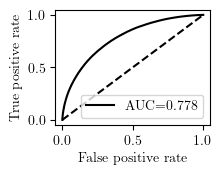


Linear_Transform_y_proba()

a = 0.000, b = 0.998

Analyze_Prediction()
KBFC_5_Fold_alpha_0_5_gamma_0_0_Hard_Test_Transformed_100
Value_Counts_y_proba
713566 694821
659143
Finished
Plot_Prediction()
KBFC_5_Fold_alpha_0_5_gamma_0_0_Hard_Test_Transformed_100
./Images/KBFC_5_Fold_alpha_0_5_gamma_0_0_Hard_Test_Transformed_100_Pred.png


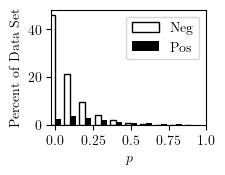


Plot_Prediction()
KBFC_5_Fold_alpha_0_5_gamma_0_0_Hard_Test_Transformed_100
./Images/KBFC_5_Fold_alpha_0_5_gamma_0_0_Hard_Test_Transformed_100_Pred_Wide.png


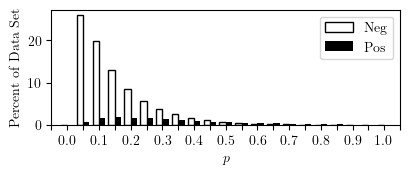


ROC()
KBFC_5_Fold_alpha_0_5_gamma_0_0_Hard_Test_Transformed_100

len(fpr/tpr) =  179082
[[0.         0.        ]
 [0.         0.00001853]
 [0.         0.00003705]
 [0.         0.0000741 ]
 [0.         0.00009263]
 [0.         0.00012042]
 [0.         0.00013895]
 [0.         0.00014821]
 [0.00000165 0.00014821]
 [0.00000165 0.00015747]]
[[0.         0.        ]
 [0.         0.00001853]
 [0.         0.00003705]
 [0.         0.0000741 ]
 [0.         0.00009263]
 [0.         0.00012042]
 [0.         0.00013895]
 [0.         0.00014821]
 [0.00000165 0.00014821]
 [0.00000165 0.00015747]]
Unique fpr/tpr =  179082

p_values =  []
./Images/KBFC_5_Fold_alpha_0_5_gamma_0_0_Hard_Test_Transformed_100_ROC.png


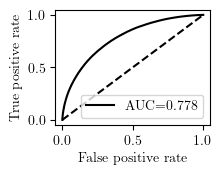


Linear_Transform_y_proba()

a = 0.004, b = 0.839

Analyze_Prediction()
KBFC_5_Fold_alpha_0_5_gamma_0_0_Hard_Test_Transformed_98
Value_Counts_y_proba
713566 687247
651569
Finished
Plot_Prediction()
KBFC_5_Fold_alpha_0_5_gamma_0_0_Hard_Test_Transformed_98
./Images/KBFC_5_Fold_alpha_0_5_gamma_0_0_Hard_Test_Transformed_98_Pred.png


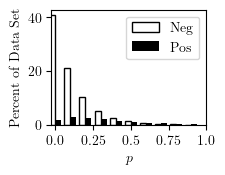


Plot_Prediction()
KBFC_5_Fold_alpha_0_5_gamma_0_0_Hard_Test_Transformed_98
./Images/KBFC_5_Fold_alpha_0_5_gamma_0_0_Hard_Test_Transformed_98_Pred_Wide.png


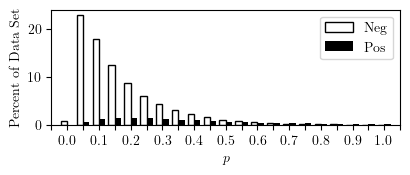


ROC()
KBFC_5_Fold_alpha_0_5_gamma_0_0_Hard_Test_Transformed_98

len(fpr/tpr) =  178558
[[0.         0.        ]
 [0.00050858 0.01000408]
 [0.00050858 0.0100226 ]
 [0.00051188 0.0100226 ]
 [0.00051188 0.01005039]
 [0.00051353 0.01005039]
 [0.00051353 0.01007818]
 [0.00051518 0.01007818]
 [0.00051518 0.0101245 ]
 [0.00051683 0.0101245 ]]
[[0.         0.        ]
 [0.00050858 0.01000408]
 [0.00050858 0.0100226 ]
 [0.00051188 0.0100226 ]
 [0.00051188 0.01005039]
 [0.00051353 0.01005039]
 [0.00051353 0.01007818]
 [0.00051518 0.01007818]
 [0.00051518 0.0101245 ]
 [0.00051683 0.0101245 ]]
Unique fpr/tpr =  178558

p_values =  []
./Images/KBFC_5_Fold_alpha_0_5_gamma_0_0_Hard_Test_Transformed_98_ROC.png


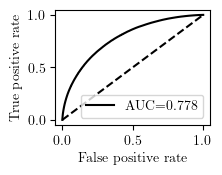


Linear_Transform_y_proba()

a = 0.007, b = 0.781

Analyze_Prediction()
KBFC_5_Fold_alpha_0_5_gamma_0_0_Hard_Test_Transformed_95
Value_Counts_y_proba
713566 675943
640265
Finished
Plot_Prediction()
KBFC_5_Fold_alpha_0_5_gamma_0_0_Hard_Test_Transformed_95
./Images/KBFC_5_Fold_alpha_0_5_gamma_0_0_Hard_Test_Transformed_95_Pred.png


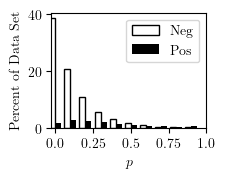


Plot_Prediction()
KBFC_5_Fold_alpha_0_5_gamma_0_0_Hard_Test_Transformed_95
./Images/KBFC_5_Fold_alpha_0_5_gamma_0_0_Hard_Test_Transformed_95_Pred_Wide.png


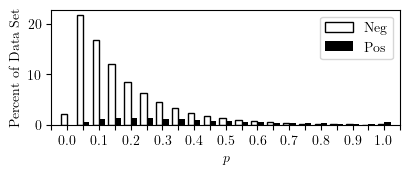


ROC()
KBFC_5_Fold_alpha_0_5_gamma_0_0_Hard_Test_Transformed_95

len(fpr/tpr) =  177220
[[0.         0.        ]
 [0.00154885 0.02500093]
 [0.00154885 0.02509356]
 [0.0015505  0.02509356]
 [0.0015505  0.02510282]
 [0.00155215 0.02510282]
 [0.00155215 0.02513061]
 [0.00155381 0.02513061]
 [0.00155381 0.02518619]
 [0.00155546 0.02518619]]
[[0.         0.        ]
 [0.00154885 0.02500093]
 [0.00154885 0.02509356]
 [0.0015505  0.02509356]
 [0.0015505  0.02510282]
 [0.00155215 0.02510282]
 [0.00155215 0.02513061]
 [0.00155381 0.02513061]
 [0.00155381 0.02518619]
 [0.00155546 0.02518619]]
Unique fpr/tpr =  177220

p_values =  []
./Images/KBFC_5_Fold_alpha_0_5_gamma_0_0_Hard_Test_Transformed_95_ROC.png


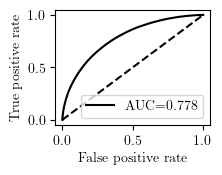





------------------------

KBFC_5_Fold_alpha_balanced_gamma_0_0_Hard



K-fold iteration =  0
len(train_index) =  570852
[     0      2      5 ... 713563 713564 713565]
len(test_index) =  142714
[     1      3      4 ... 713557 713558 713559]

train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
5,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
6,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
7,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713561,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
713562,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713563,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713564,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0



test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
14,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
18,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713539,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
713550,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713557,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713558,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


type(test_fold) =  <class 'pandas.core.frame.DataFrame'>
type(y_test_fold) =  <class 'pandas.core.series.Series'>
len(X_train_fold) =  570852
len(X_test_fold) =  142714
len(y_train_fold) =  570852
len(y_test_fold) =  142714

data.shape =  (713566, 175) 175
X_train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
0,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
5,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
6,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0
7,0,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0


y_train_fold


0    0
2    0
5    0
6    0
7    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_train_fold.value_counts()


0    484488
1     86364
Name: HOSPITAL, dtype: int64

X_test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
1,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
14,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
18,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0


y_test_fold


1     0
3     0
4     0
14    0
18    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_test_fold.value_counts()


0    121122
1     21592
Name: HOSPITAL, dtype: int64

y_proba_fold
[0.30984026, 0.58141875, 0.0032433404, 0.08314631, 0.3400582, 0.19074737, 0.21348837, 0.3595147, 0.22700687, 0.44173914]


K-fold iteration =  1
len(train_index) =  570853
[     0      1      3 ... 713561 713562 713563]
len(test_index) =  142713
[     2      6     35 ... 713556 713564 713565]

train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713559,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713560,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713561,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
713562,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0



test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
2,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
6,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
35,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
37,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
38,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713549,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
713552,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713556,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
713564,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


type(test_fold) =  <class 'pandas.core.frame.DataFrame'>
type(y_test_fold) =  <class 'pandas.core.series.Series'>
len(X_train_fold) =  570853
len(X_test_fold) =  142713
len(y_train_fold) =  570853
len(y_test_fold) =  142713

data.shape =  (713566, 175) 175
X_train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
0,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
5,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0


y_train_fold


0    0
1    0
3    0
4    0
5    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_train_fold.value_counts()


0    484488
1     86365
Name: HOSPITAL, dtype: int64

X_test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
2,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
6,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0
35,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
37,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
38,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0


y_test_fold


2     0
6     0
35    1
37    0
38    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_test_fold.value_counts()


0    121122
1     21591
Name: HOSPITAL, dtype: int64

y_proba_fold
[0.008901833, 0.26306862, 0.54070216, 0.42403364, 0.5738798, 0.2347231, 0.44226065, 0.112685435, 0.067590095, 0.23892228]


K-fold iteration =  2
len(train_index) =  570853
[     1      2      3 ... 713563 713564 713565]
len(test_index) =  142713
[     0     10     12 ... 713542 713543 713553]

train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713561,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
713562,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713563,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713564,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0



test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
10,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
12,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
13,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
21,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713529,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
713535,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
713542,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
713543,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


type(test_fold) =  <class 'pandas.core.frame.DataFrame'>
type(y_test_fold) =  <class 'pandas.core.series.Series'>
len(X_train_fold) =  570853
len(X_test_fold) =  142713
len(y_train_fold) =  570853
len(y_test_fold) =  142713

data.shape =  (713566, 175) 175
X_train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
1,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
2,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
5,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0


y_train_fold


1    0
2    0
3    0
4    0
5    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_train_fold.value_counts()


0    484488
1     86365
Name: HOSPITAL, dtype: int64

X_test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
0,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
10,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
12,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
13,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
21,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0


y_test_fold


0     0
10    0
12    0
13    0
21    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_test_fold.value_counts()


0    121122
1     21591
Name: HOSPITAL, dtype: int64

y_proba_fold
[0.46913967, 0.27440065, 0.13429321, 0.6138441, 0.3694767, 0.17161378, 0.25002104, 0.41868696, 0.06183932, 0.39727417]


K-fold iteration =  3
len(train_index) =  570853
[     0      1      2 ... 713563 713564 713565]
len(test_index) =  142713
[     7      9     15 ... 713555 713560 713562]

train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713559,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713561,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
713563,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713564,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0



test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
7,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
9,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
15,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
19,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
23,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713547,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713554,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
713555,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713560,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


type(test_fold) =  <class 'pandas.core.frame.DataFrame'>
type(y_test_fold) =  <class 'pandas.core.series.Series'>
len(X_train_fold) =  570853
len(X_test_fold) =  142713
len(y_train_fold) =  570853
len(y_test_fold) =  142713

data.shape =  (713566, 175) 175
X_train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
0,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
2,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0


y_train_fold


0    0
1    0
2    0
3    0
4    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_train_fold.value_counts()


0    484488
1     86365
Name: HOSPITAL, dtype: int64

X_test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
7,0,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
9,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
15,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
19,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
23,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1


y_test_fold


7     0
9     0
15    0
19    0
23    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_test_fold.value_counts()


0    121122
1     21591
Name: HOSPITAL, dtype: int64

y_proba_fold
[0.15838552, 0.5024715, 0.10280849, 0.48615763, 0.36441785, 0.52914786, 0.2948419, 0.83576685, 0.33053064, 0.50877106]


K-fold iteration =  4
len(train_index) =  570853
[     0      1      2 ... 713562 713564 713565]
len(test_index) =  142713
[     5      8     11 ... 713551 713561 713563]

train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713559,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713560,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713562,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713564,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0



test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
5,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
8,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
11,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
16,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
17,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713524,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713548,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713551,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
713561,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


type(test_fold) =  <class 'pandas.core.frame.DataFrame'>
type(y_test_fold) =  <class 'pandas.core.series.Series'>
len(X_train_fold) =  570853
len(X_test_fold) =  142713
len(y_train_fold) =  570853
len(y_test_fold) =  142713

data.shape =  (713566, 175) 175
X_train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
0,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
2,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0


y_train_fold


0    0
1    0
2    0
3    0
4    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_train_fold.value_counts()


0    484488
1     86365
Name: HOSPITAL, dtype: int64

X_test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
5,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
8,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
11,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
16,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0
17,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0


y_test_fold


5     0
8     0
11    0
16    0
17    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_test_fold.value_counts()


0    121122
1     21591
Name: HOSPITAL, dtype: int64

y_proba_fold
[0.1890884, 0.3142037, 0.09029172, 0.14061025, 0.18638997, 0.45672384, 0.49914023, 0.666328, 0.6573719, 0.40278822]
Analyze_Prediction()
KBFC_5_Fold_alpha_balanced_gamma_0_0_Hard_Test
Value_Counts_y_proba
713566 695089
659411
Finished
Plot_Prediction()
KBFC_5_Fold_alpha_balanced_gamma_0_0_Hard_Test
./Images/KBFC_5_Fold_alpha_balanced_gamma_0_0_Hard_Test_Pred.png


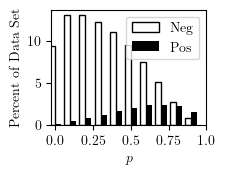


Plot_Prediction()
KBFC_5_Fold_alpha_balanced_gamma_0_0_Hard_Test
./Images/KBFC_5_Fold_alpha_balanced_gamma_0_0_Hard_Test_Pred_Wide.png


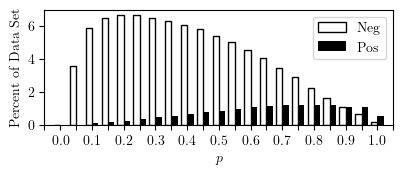


ROC()
KBFC_5_Fold_alpha_balanced_gamma_0_0_Hard_Test

len(fpr/tpr) =  177499
[[0.         0.        ]
 [0.00000165 0.        ]
 [0.00000165 0.00011116]
 [0.00000495 0.00011116]
 [0.00000495 0.00012968]
 [0.0000066  0.00012968]
 [0.0000066  0.00013895]
 [0.00000826 0.00013895]
 [0.00000826 0.0002501 ]
 [0.00001156 0.0002501 ]]
[[0.         0.        ]
 [0.00000165 0.        ]
 [0.00000165 0.00011116]
 [0.00000495 0.00011116]
 [0.00000495 0.00012968]
 [0.0000066  0.00012968]
 [0.0000066  0.00013895]
 [0.00000826 0.00013895]
 [0.00000826 0.0002501 ]
 [0.00001156 0.0002501 ]]
Unique fpr/tpr =  177499

p_values =  []
./Images/KBFC_5_Fold_alpha_balanced_gamma_0_0_Hard_Test_ROC.png


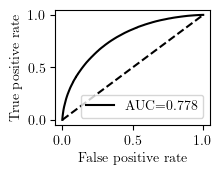


Linear_Transform_y_proba()

a = 0.000, b = 0.993

Analyze_Prediction()
KBFC_5_Fold_alpha_balanced_gamma_0_0_Hard_Test_Transformed_100
Value_Counts_y_proba
713566 695051
659373
Finished
Plot_Prediction()
KBFC_5_Fold_alpha_balanced_gamma_0_0_Hard_Test_Transformed_100
./Images/KBFC_5_Fold_alpha_balanced_gamma_0_0_Hard_Test_Transformed_100_Pred.png


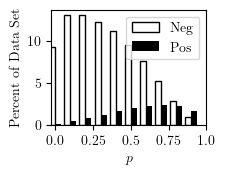


Plot_Prediction()
KBFC_5_Fold_alpha_balanced_gamma_0_0_Hard_Test_Transformed_100
./Images/KBFC_5_Fold_alpha_balanced_gamma_0_0_Hard_Test_Transformed_100_Pred_Wide.png


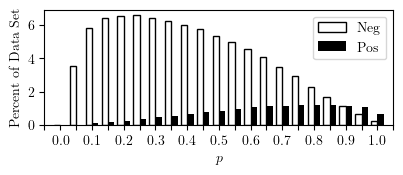


ROC()
KBFC_5_Fold_alpha_balanced_gamma_0_0_Hard_Test_Transformed_100

len(fpr/tpr) =  177536
[[0.         0.        ]
 [0.00000165 0.00000926]
 [0.00000165 0.00011116]
 [0.00000495 0.00011116]
 [0.00000495 0.00012968]
 [0.0000066  0.00012968]
 [0.0000066  0.00013895]
 [0.00000826 0.00013895]
 [0.00000826 0.0002501 ]
 [0.00001156 0.0002501 ]]
[[0.         0.        ]
 [0.00000165 0.00000926]
 [0.00000165 0.00011116]
 [0.00000495 0.00011116]
 [0.00000495 0.00012968]
 [0.0000066  0.00012968]
 [0.0000066  0.00013895]
 [0.00000826 0.00013895]
 [0.00000826 0.0002501 ]
 [0.00001156 0.0002501 ]]
Unique fpr/tpr =  177536

p_values =  []
./Images/KBFC_5_Fold_alpha_balanced_gamma_0_0_Hard_Test_Transformed_100_ROC.png


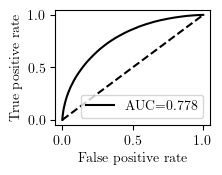


Linear_Transform_y_proba()

a = 0.019, b = 0.970

Analyze_Prediction()
KBFC_5_Fold_alpha_balanced_gamma_0_0_Hard_Test_Transformed_98
Value_Counts_y_proba
713566 683566
647888
Finished
Plot_Prediction()
KBFC_5_Fold_alpha_balanced_gamma_0_0_Hard_Test_Transformed_98
./Images/KBFC_5_Fold_alpha_balanced_gamma_0_0_Hard_Test_Transformed_98_Pred.png


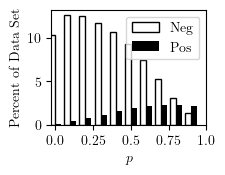


Plot_Prediction()
KBFC_5_Fold_alpha_balanced_gamma_0_0_Hard_Test_Transformed_98
./Images/KBFC_5_Fold_alpha_balanced_gamma_0_0_Hard_Test_Transformed_98_Pred_Wide.png


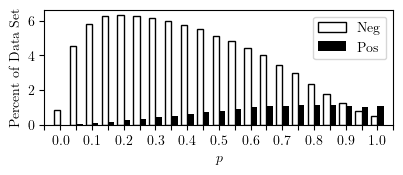


ROC()
KBFC_5_Fold_alpha_balanced_gamma_0_0_Hard_Test_Transformed_98

len(fpr/tpr) =  179878
[[0.         0.        ]
 [0.00053004 0.01001334]
 [0.00053004 0.01005039]
 [0.0005317  0.01005039]
 [0.0005317  0.01005965]
 [0.00053335 0.01005965]
 [0.00053335 0.01006892]
 [0.0005383  0.01006892]
 [0.0005383  0.0101245 ]
 [0.00053995 0.0101245 ]]
[[0.         0.        ]
 [0.00053004 0.01001334]
 [0.00053004 0.01005039]
 [0.0005317  0.01005039]
 [0.0005317  0.01005965]
 [0.00053335 0.01005965]
 [0.00053335 0.01006892]
 [0.0005383  0.01006892]
 [0.0005383  0.0101245 ]
 [0.00053995 0.0101245 ]]
Unique fpr/tpr =  179878

p_values =  []
./Images/KBFC_5_Fold_alpha_balanced_gamma_0_0_Hard_Test_Transformed_98_ROC.png


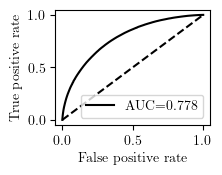


Linear_Transform_y_proba()

a = 0.035, b = 0.957

Analyze_Prediction()
KBFC_5_Fold_alpha_balanced_gamma_0_0_Hard_Test_Transformed_95
Value_Counts_y_proba
713566 676428
640750
Finished
Plot_Prediction()
KBFC_5_Fold_alpha_balanced_gamma_0_0_Hard_Test_Transformed_95
./Images/KBFC_5_Fold_alpha_balanced_gamma_0_0_Hard_Test_Transformed_95_Pred.png


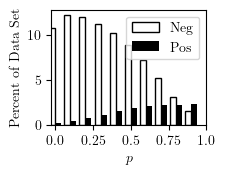


Plot_Prediction()
KBFC_5_Fold_alpha_balanced_gamma_0_0_Hard_Test_Transformed_95
./Images/KBFC_5_Fold_alpha_balanced_gamma_0_0_Hard_Test_Transformed_95_Pred_Wide.png


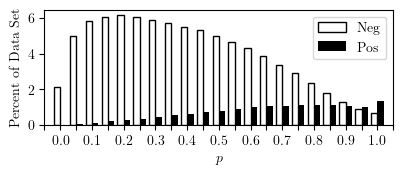


ROC()
KBFC_5_Fold_alpha_balanced_gamma_0_0_Hard_Test_Transformed_95

len(fpr/tpr) =  175483
[[0.         0.        ]
 [0.00153729 0.02500093]
 [0.00153729 0.02502872]
 [0.00154225 0.02502872]
 [0.00154225 0.02508429]
 [0.0015472  0.02508429]
 [0.0015472  0.02510282]
 [0.0015472  0.02511208]
 [0.00154885 0.02511208]
 [0.00154885 0.02512135]]
[[0.         0.        ]
 [0.00153729 0.02500093]
 [0.00153729 0.02502872]
 [0.00154225 0.02502872]
 [0.00154225 0.02508429]
 [0.0015472  0.02508429]
 [0.0015472  0.02510282]
 [0.0015472  0.02511208]
 [0.00154885 0.02511208]
 [0.00154885 0.02512135]]
Unique fpr/tpr =  175483

p_values =  []
./Images/KBFC_5_Fold_alpha_balanced_gamma_0_0_Hard_Test_Transformed_95_ROC.png


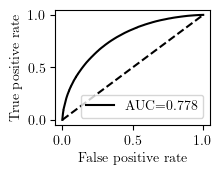





------------------------

KBFC_5_Fold_alpha_0_5_gamma_1_0_Hard



K-fold iteration =  0
len(train_index) =  570852
[     0      2      5 ... 713563 713564 713565]
len(test_index) =  142714
[     1      3      4 ... 713557 713558 713559]

train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
5,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
6,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
7,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713561,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
713562,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713563,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713564,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0



test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
14,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
18,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713539,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
713550,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713557,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713558,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


type(test_fold) =  <class 'pandas.core.frame.DataFrame'>
type(y_test_fold) =  <class 'pandas.core.series.Series'>
len(X_train_fold) =  570852
len(X_test_fold) =  142714
len(y_train_fold) =  570852
len(y_test_fold) =  142714

data.shape =  (713566, 175) 175
X_train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
0,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
5,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
6,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0
7,0,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0


y_train_fold


0    0
2    0
5    0
6    0
7    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_train_fold.value_counts()


0    484488
1     86364
Name: HOSPITAL, dtype: int64

X_test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
1,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
14,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
18,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0


y_test_fold


1     0
3     0
4     0
14    0
18    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_test_fold.value_counts()


0    121122
1     21592
Name: HOSPITAL, dtype: int64

y_proba_fold
[0.22515982, 0.29618457, 0.033668276, 0.07622271, 0.26747888, 0.2085185, 0.17982551, 0.21506974, 0.123701856, 0.20484953]


K-fold iteration =  1
len(train_index) =  570853
[     0      1      3 ... 713561 713562 713563]
len(test_index) =  142713
[     2      6     35 ... 713556 713564 713565]

train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713559,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713560,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713561,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
713562,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0



test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
2,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
6,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
35,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
37,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
38,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713549,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
713552,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713556,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
713564,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


type(test_fold) =  <class 'pandas.core.frame.DataFrame'>
type(y_test_fold) =  <class 'pandas.core.series.Series'>
len(X_train_fold) =  570853
len(X_test_fold) =  142713
len(y_train_fold) =  570853
len(y_test_fold) =  142713

data.shape =  (713566, 175) 175
X_train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
0,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
5,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0


y_train_fold


0    0
1    0
3    0
4    0
5    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_train_fold.value_counts()


0    484488
1     86365
Name: HOSPITAL, dtype: int64

X_test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
2,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
6,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0
35,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
37,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
38,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0


y_test_fold


2     0
6     0
35    1
37    0
38    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_test_fold.value_counts()


0    121122
1     21591
Name: HOSPITAL, dtype: int64

y_proba_fold
[0.027166458, 0.21722484, 0.28557822, 0.2219018, 0.28962037, 0.15369907, 0.22615726, 0.07789894, 0.08991715, 0.19462633]


K-fold iteration =  2
len(train_index) =  570853
[     1      2      3 ... 713563 713564 713565]
len(test_index) =  142713
[     0     10     12 ... 713542 713543 713553]

train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713561,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
713562,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713563,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713564,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0



test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
10,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
12,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
13,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
21,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713529,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
713535,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
713542,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
713543,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


type(test_fold) =  <class 'pandas.core.frame.DataFrame'>
type(y_test_fold) =  <class 'pandas.core.series.Series'>
len(X_train_fold) =  570853
len(X_test_fold) =  142713
len(y_train_fold) =  570853
len(y_test_fold) =  142713

data.shape =  (713566, 175) 175
X_train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
1,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
2,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
5,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0


y_train_fold


1    0
2    0
3    0
4    0
5    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_train_fold.value_counts()


0    484488
1     86365
Name: HOSPITAL, dtype: int64

X_test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
0,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
10,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
12,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
13,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
21,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0


y_test_fold


0     0
10    0
12    0
13    0
21    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_test_fold.value_counts()


0    121122
1     21591
Name: HOSPITAL, dtype: int64

y_proba_fold
[0.2823773, 0.15568297, 0.15084367, 0.22575846, 0.18075529, 0.17399354, 0.18874721, 0.2785064, 0.11585918, 0.36362064]


K-fold iteration =  3
len(train_index) =  570853
[     0      1      2 ... 713563 713564 713565]
len(test_index) =  142713
[     7      9     15 ... 713555 713560 713562]

train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713559,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713561,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
713563,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713564,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0



test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
7,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
9,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
15,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
19,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
23,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713547,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713554,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
713555,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713560,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


type(test_fold) =  <class 'pandas.core.frame.DataFrame'>
type(y_test_fold) =  <class 'pandas.core.series.Series'>
len(X_train_fold) =  570853
len(X_test_fold) =  142713
len(y_train_fold) =  570853
len(y_test_fold) =  142713

data.shape =  (713566, 175) 175
X_train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
0,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
2,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0


y_train_fold


0    0
1    0
2    0
3    0
4    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_train_fold.value_counts()


0    484488
1     86365
Name: HOSPITAL, dtype: int64

X_test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
7,0,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
9,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
15,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
19,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
23,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1


y_test_fold


7     0
9     0
15    0
19    0
23    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_test_fold.value_counts()


0    121122
1     21591
Name: HOSPITAL, dtype: int64

y_proba_fold
[0.16933005, 0.24460009, 0.11058648, 0.33276284, 0.20763807, 0.25856027, 0.18746805, 0.44538194, 0.25810492, 0.2849502]


K-fold iteration =  4
len(train_index) =  570853
[     0      1      2 ... 713562 713564 713565]
len(test_index) =  142713
[     5      8     11 ... 713551 713561 713563]

train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713559,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713560,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713562,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713564,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0



test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
5,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
8,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
11,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
16,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
17,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713524,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713548,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713551,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
713561,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


type(test_fold) =  <class 'pandas.core.frame.DataFrame'>
type(y_test_fold) =  <class 'pandas.core.series.Series'>
len(X_train_fold) =  570853
len(X_test_fold) =  142713
len(y_train_fold) =  570853
len(y_test_fold) =  142713

data.shape =  (713566, 175) 175
X_train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
0,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
2,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0


y_train_fold


0    0
1    0
2    0
3    0
4    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_train_fold.value_counts()


0    484488
1     86365
Name: HOSPITAL, dtype: int64

X_test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
5,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
8,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
11,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
16,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0
17,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0


y_test_fold


5     0
8     0
11    0
16    0
17    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_test_fold.value_counts()


0    121122
1     21591
Name: HOSPITAL, dtype: int64

y_proba_fold
[0.16131762, 0.19867992, 0.09025147, 0.14072496, 0.11056471, 0.25440884, 0.25420484, 0.2834716, 0.25225252, 0.21125941]
Analyze_Prediction()
KBFC_5_Fold_alpha_0_5_gamma_1_0_Hard_Test
Value_Counts_y_proba
713566 689951
654273
Finished
Plot_Prediction()
KBFC_5_Fold_alpha_0_5_gamma_1_0_Hard_Test
./Images/KBFC_5_Fold_alpha_0_5_gamma_1_0_Hard_Test_Pred.png


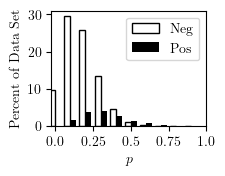


Plot_Prediction()
KBFC_5_Fold_alpha_0_5_gamma_1_0_Hard_Test
./Images/KBFC_5_Fold_alpha_0_5_gamma_1_0_Hard_Test_Pred_Wide.png


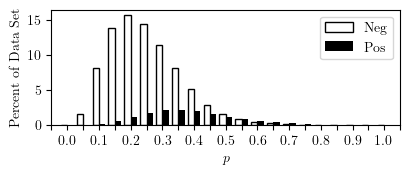


ROC()
KBFC_5_Fold_alpha_0_5_gamma_1_0_Hard_Test

len(fpr/tpr) =  184043
[[0.         0.        ]
 [0.         0.00000926]
 [0.         0.00003705]
 [0.         0.00005558]
 [0.         0.00008337]
 [0.         0.00010189]
 [0.         0.00012968]
 [0.         0.00013895]
 [0.         0.000176  ]
 [0.         0.00022231]]
[[0.         0.        ]
 [0.         0.00000926]
 [0.         0.00003705]
 [0.         0.00005558]
 [0.         0.00008337]
 [0.         0.00010189]
 [0.         0.00012968]
 [0.         0.00013895]
 [0.         0.000176  ]
 [0.         0.00022231]]
Unique fpr/tpr =  184043

p_values =  []
./Images/KBFC_5_Fold_alpha_0_5_gamma_1_0_Hard_Test_ROC.png


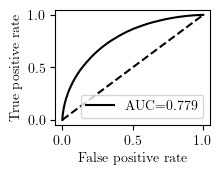


Linear_Transform_y_proba()

a = 0.000, b = 0.998

Analyze_Prediction()
KBFC_5_Fold_alpha_0_5_gamma_1_0_Hard_Test_Transformed_100
Value_Counts_y_proba
713566 689945
654267
Finished
Plot_Prediction()
KBFC_5_Fold_alpha_0_5_gamma_1_0_Hard_Test_Transformed_100
./Images/KBFC_5_Fold_alpha_0_5_gamma_1_0_Hard_Test_Transformed_100_Pred.png


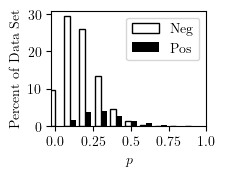


Plot_Prediction()
KBFC_5_Fold_alpha_0_5_gamma_1_0_Hard_Test_Transformed_100
./Images/KBFC_5_Fold_alpha_0_5_gamma_1_0_Hard_Test_Transformed_100_Pred_Wide.png


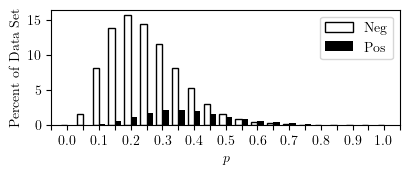


ROC()
KBFC_5_Fold_alpha_0_5_gamma_1_0_Hard_Test_Transformed_100

len(fpr/tpr) =  184052
[[0.         0.        ]
 [0.         0.00000926]
 [0.         0.00003705]
 [0.         0.00005558]
 [0.         0.00008337]
 [0.         0.00010189]
 [0.         0.00012968]
 [0.         0.00013895]
 [0.         0.000176  ]
 [0.         0.00022231]]
[[0.         0.        ]
 [0.         0.00000926]
 [0.         0.00003705]
 [0.         0.00005558]
 [0.         0.00008337]
 [0.         0.00010189]
 [0.         0.00012968]
 [0.         0.00013895]
 [0.         0.000176  ]
 [0.         0.00022231]]
Unique fpr/tpr =  184052

p_values =  []
./Images/KBFC_5_Fold_alpha_0_5_gamma_1_0_Hard_Test_Transformed_100_ROC.png


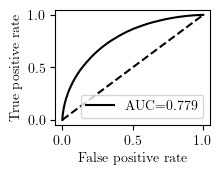


Linear_Transform_y_proba()

a = 0.040, b = 0.723

Analyze_Prediction()
KBFC_5_Fold_alpha_0_5_gamma_1_0_Hard_Test_Transformed_98
Value_Counts_y_proba
713566 681827
646149
Finished
Plot_Prediction()
KBFC_5_Fold_alpha_0_5_gamma_1_0_Hard_Test_Transformed_98
./Images/KBFC_5_Fold_alpha_0_5_gamma_1_0_Hard_Test_Transformed_98_Pred.png


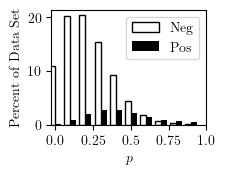


Plot_Prediction()
KBFC_5_Fold_alpha_0_5_gamma_1_0_Hard_Test_Transformed_98
./Images/KBFC_5_Fold_alpha_0_5_gamma_1_0_Hard_Test_Transformed_98_Pred_Wide.png


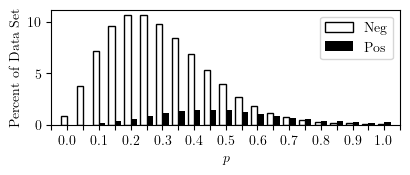


ROC()
KBFC_5_Fold_alpha_0_5_gamma_1_0_Hard_Test_Transformed_98

len(fpr/tpr) =  184127
[[0.         0.        ]
 [0.00048381 0.01000408]
 [0.00048381 0.0100226 ]
 [0.00048546 0.0100226 ]
 [0.00048546 0.01009671]
 [0.00048711 0.01009671]
 [0.00048711 0.01020786]
 [0.00048876 0.01020786]
 [0.00048876 0.01025418]
 [0.00049207 0.01025418]]
[[0.         0.        ]
 [0.00048381 0.01000408]
 [0.00048381 0.0100226 ]
 [0.00048546 0.0100226 ]
 [0.00048546 0.01009671]
 [0.00048711 0.01009671]
 [0.00048711 0.01020786]
 [0.00048876 0.01020786]
 [0.00048876 0.01025418]
 [0.00049207 0.01025418]]
Unique fpr/tpr =  184127

p_values =  []
./Images/KBFC_5_Fold_alpha_0_5_gamma_1_0_Hard_Test_Transformed_98_ROC.png


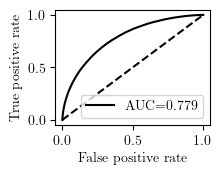


Linear_Transform_y_proba()

a = 0.055, b = 0.680

Analyze_Prediction()
KBFC_5_Fold_alpha_0_5_gamma_1_0_Hard_Test_Transformed_95
Value_Counts_y_proba
713566 669589
633911
Finished
Plot_Prediction()
KBFC_5_Fold_alpha_0_5_gamma_1_0_Hard_Test_Transformed_95
./Images/KBFC_5_Fold_alpha_0_5_gamma_1_0_Hard_Test_Transformed_95_Pred.png


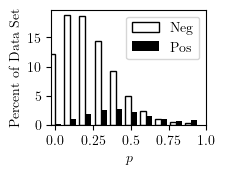


Plot_Prediction()
KBFC_5_Fold_alpha_0_5_gamma_1_0_Hard_Test_Transformed_95
./Images/KBFC_5_Fold_alpha_0_5_gamma_1_0_Hard_Test_Transformed_95_Pred_Wide.png


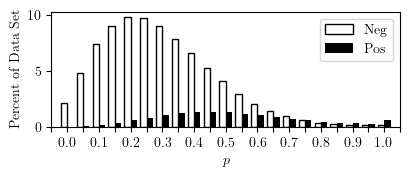


ROC()
KBFC_5_Fold_alpha_0_5_gamma_1_0_Hard_Test_Transformed_95

len(fpr/tpr) =  184150
[[0.         0.        ]
 [0.00142501 0.02500093]
 [0.00142501 0.02501945]
 [0.00142666 0.02501945]
 [0.00142666 0.02502872]
 [0.00142831 0.02502872]
 [0.00142831 0.02509356]
 [0.00142996 0.02509356]
 [0.00142996 0.02526029]
 [0.00143161 0.02526029]]
[[0.         0.        ]
 [0.00142501 0.02500093]
 [0.00142501 0.02501945]
 [0.00142666 0.02501945]
 [0.00142666 0.02502872]
 [0.00142831 0.02502872]
 [0.00142831 0.02509356]
 [0.00142996 0.02509356]
 [0.00142996 0.02526029]
 [0.00143161 0.02526029]]
Unique fpr/tpr =  184150

p_values =  []
./Images/KBFC_5_Fold_alpha_0_5_gamma_1_0_Hard_Test_Transformed_95_ROC.png


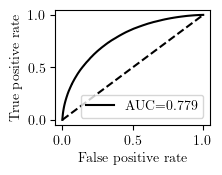





------------------------

KBFC_5_Fold_alpha_0_5_gamma_2_0_Hard



K-fold iteration =  0
len(train_index) =  570852
[     0      2      5 ... 713563 713564 713565]
len(test_index) =  142714
[     1      3      4 ... 713557 713558 713559]

train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
5,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
6,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
7,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713561,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
713562,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713563,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713564,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0



test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
14,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
18,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713539,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
713550,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713557,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713558,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


type(test_fold) =  <class 'pandas.core.frame.DataFrame'>
type(y_test_fold) =  <class 'pandas.core.series.Series'>
len(X_train_fold) =  570852
len(X_test_fold) =  142714
len(y_train_fold) =  570852
len(y_test_fold) =  142714

data.shape =  (713566, 175) 175
X_train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
0,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
5,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
6,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0
7,0,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0


y_train_fold


0    0
2    0
5    0
6    0
7    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_train_fold.value_counts()


0    484488
1     86364
Name: HOSPITAL, dtype: int64

X_test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
1,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
14,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
18,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0


y_test_fold


1     0
3     0
4     0
14    0
18    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_test_fold.value_counts()


0    121122
1     21592
Name: HOSPITAL, dtype: int64

y_proba_fold
[0.3057272, 0.29990453, 0.050936162, 0.13832952, 0.3228467, 0.21252684, 0.23796181, 0.21711932, 0.23028174, 0.32811192]


K-fold iteration =  1
len(train_index) =  570853
[     0      1      3 ... 713561 713562 713563]
len(test_index) =  142713
[     2      6     35 ... 713556 713564 713565]

train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713559,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713560,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713561,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
713562,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0



test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
2,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
6,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
35,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
37,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
38,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713549,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
713552,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713556,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
713564,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


type(test_fold) =  <class 'pandas.core.frame.DataFrame'>
type(y_test_fold) =  <class 'pandas.core.series.Series'>
len(X_train_fold) =  570853
len(X_test_fold) =  142713
len(y_train_fold) =  570853
len(y_test_fold) =  142713

data.shape =  (713566, 175) 175
X_train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
0,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
5,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0


y_train_fold


0    0
1    0
3    0
4    0
5    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_train_fold.value_counts()


0    484488
1     86365
Name: HOSPITAL, dtype: int64

X_test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
2,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
6,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0
35,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
37,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
38,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0


y_test_fold


2     0
6     0
35    1
37    0
38    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_test_fold.value_counts()


0    121122
1     21591
Name: HOSPITAL, dtype: int64

y_proba_fold
[0.065460235, 0.2843054, 0.34422722, 0.26132387, 0.3491888, 0.26915443, 0.30484048, 0.224811, 0.16201864, 0.23126714]


K-fold iteration =  2
len(train_index) =  570853
[     1      2      3 ... 713563 713564 713565]
len(test_index) =  142713
[     0     10     12 ... 713542 713543 713553]

train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713561,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
713562,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713563,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713564,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0



test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
10,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
12,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
13,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
21,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713529,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
713535,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
713542,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
713543,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


type(test_fold) =  <class 'pandas.core.frame.DataFrame'>
type(y_test_fold) =  <class 'pandas.core.series.Series'>
len(X_train_fold) =  570853
len(X_test_fold) =  142713
len(y_train_fold) =  570853
len(y_test_fold) =  142713

data.shape =  (713566, 175) 175
X_train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
1,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
2,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
5,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0


y_train_fold


1    0
2    0
3    0
4    0
5    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_train_fold.value_counts()


0    484488
1     86365
Name: HOSPITAL, dtype: int64

X_test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
0,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
10,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
12,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
13,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
21,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0


y_test_fold


0     0
10    0
12    0
13    0
21    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_test_fold.value_counts()


0    121122
1     21591
Name: HOSPITAL, dtype: int64

y_proba_fold
[0.33232805, 0.20434444, 0.218745, 0.27382046, 0.23243316, 0.2147569, 0.23543954, 0.29156303, 0.17027448, 0.32076687]


K-fold iteration =  3
len(train_index) =  570853
[     0      1      2 ... 713563 713564 713565]
len(test_index) =  142713
[     7      9     15 ... 713555 713560 713562]

train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713559,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713561,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
713563,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713564,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0



test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
7,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
9,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
15,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
19,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
23,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713547,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713554,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
713555,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713560,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


type(test_fold) =  <class 'pandas.core.frame.DataFrame'>
type(y_test_fold) =  <class 'pandas.core.series.Series'>
len(X_train_fold) =  570853
len(X_test_fold) =  142713
len(y_train_fold) =  570853
len(y_test_fold) =  142713

data.shape =  (713566, 175) 175
X_train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
0,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
2,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0


y_train_fold


0    0
1    0
2    0
3    0
4    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_train_fold.value_counts()


0    484488
1     86365
Name: HOSPITAL, dtype: int64

X_test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
7,0,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
9,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
15,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
19,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
23,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1


y_test_fold


7     0
9     0
15    0
19    0
23    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_test_fold.value_counts()


0    121122
1     21591
Name: HOSPITAL, dtype: int64

y_proba_fold
[0.23665068, 0.32466456, 0.19540523, 0.3687215, 0.27374884, 0.30788782, 0.24344511, 0.41229737, 0.254634, 0.31378397]


K-fold iteration =  4
len(train_index) =  570853
[     0      1      2 ... 713562 713564 713565]
len(test_index) =  142713
[     5      8     11 ... 713551 713561 713563]

train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713559,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713560,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713562,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713564,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0



test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
5,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
8,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
11,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
16,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
17,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713524,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713548,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713551,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
713561,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


type(test_fold) =  <class 'pandas.core.frame.DataFrame'>
type(y_test_fold) =  <class 'pandas.core.series.Series'>
len(X_train_fold) =  570853
len(X_test_fold) =  142713
len(y_train_fold) =  570853
len(y_test_fold) =  142713

data.shape =  (713566, 175) 175
X_train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
0,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
2,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0


y_train_fold


0    0
1    0
2    0
3    0
4    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_train_fold.value_counts()


0    484488
1     86365
Name: HOSPITAL, dtype: int64

X_test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SCH_BUS_0_x_0,AGE_x_SCH_BUS_0_x_1,AGE_x_SCH_BUS_1_x_0,AGE_x_SCH_BUS_1_x_1,AGE_x_SCH_BUS_2_x_0,...,WRK_ZONE_0,WRK_ZONE_1,WRK_ZONE_2,WRK_ZONE_3,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
5,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
8,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
11,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
16,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0
17,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0


y_test_fold


5     0
8     0
11    0
16    0
17    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_test_fold.value_counts()


0    121122
1     21591
Name: HOSPITAL, dtype: int64

y_proba_fold
[0.28785157, 0.29180998, 0.17724936, 0.21834837, 0.20054919, 0.3504947, 0.33018124, 0.40649942, 0.41728187, 0.29114634]
Analyze_Prediction()
KBFC_5_Fold_alpha_0_5_gamma_2_0_Hard_Test
Value_Counts_y_proba
713566 681837
646159
Finished
Plot_Prediction()
KBFC_5_Fold_alpha_0_5_gamma_2_0_Hard_Test
./Images/KBFC_5_Fold_alpha_0_5_gamma_2_0_Hard_Test_Pred.png


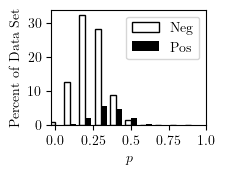


Plot_Prediction()
KBFC_5_Fold_alpha_0_5_gamma_2_0_Hard_Test
./Images/KBFC_5_Fold_alpha_0_5_gamma_2_0_Hard_Test_Pred_Wide.png


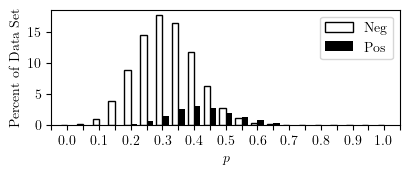


ROC()
KBFC_5_Fold_alpha_0_5_gamma_2_0_Hard_Test

len(fpr/tpr) =  193341
[[0.         0.        ]
 [0.         0.00000926]
 [0.         0.00002779]
 [0.         0.00004632]
 [0.         0.0000741 ]
 [0.         0.00010189]
 [0.         0.00011116]
 [0.         0.00014821]
 [0.         0.00015747]
 [0.         0.00018526]]
[[0.         0.        ]
 [0.         0.00000926]
 [0.         0.00002779]
 [0.         0.00004632]
 [0.         0.0000741 ]
 [0.         0.00010189]
 [0.         0.00011116]
 [0.         0.00014821]
 [0.         0.00015747]
 [0.         0.00018526]]
Unique fpr/tpr =  193341

p_values =  []
./Images/KBFC_5_Fold_alpha_0_5_gamma_2_0_Hard_Test_ROC.png


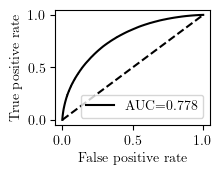


Linear_Transform_y_proba()

a = 0.000, b = 0.978

Analyze_Prediction()
KBFC_5_Fold_alpha_0_5_gamma_2_0_Hard_Test_Transformed_100
Value_Counts_y_proba
713566 681662
645984
Finished
Plot_Prediction()
KBFC_5_Fold_alpha_0_5_gamma_2_0_Hard_Test_Transformed_100
./Images/KBFC_5_Fold_alpha_0_5_gamma_2_0_Hard_Test_Transformed_100_Pred.png


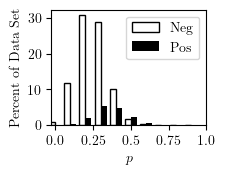


Plot_Prediction()
KBFC_5_Fold_alpha_0_5_gamma_2_0_Hard_Test_Transformed_100
./Images/KBFC_5_Fold_alpha_0_5_gamma_2_0_Hard_Test_Transformed_100_Pred_Wide.png


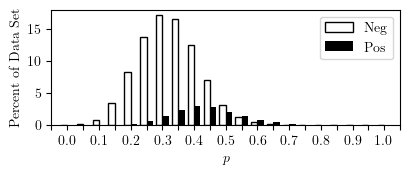


ROC()
KBFC_5_Fold_alpha_0_5_gamma_2_0_Hard_Test_Transformed_100

len(fpr/tpr) =  193553
[[0.         0.        ]
 [0.         0.00000926]
 [0.         0.00002779]
 [0.         0.00004632]
 [0.         0.0000741 ]
 [0.         0.00010189]
 [0.         0.00011116]
 [0.         0.00014821]
 [0.         0.00015747]
 [0.         0.00018526]]
[[0.         0.        ]
 [0.         0.00000926]
 [0.         0.00002779]
 [0.         0.00004632]
 [0.         0.0000741 ]
 [0.         0.00010189]
 [0.         0.00011116]
 [0.         0.00014821]
 [0.         0.00015747]
 [0.         0.00018526]]
Unique fpr/tpr =  193553

p_values =  []
./Images/KBFC_5_Fold_alpha_0_5_gamma_2_0_Hard_Test_Transformed_100_ROC.png


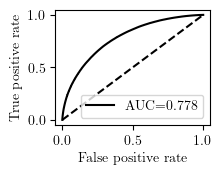


Linear_Transform_y_proba()

a = 0.094, b = 0.641

Analyze_Prediction()
KBFC_5_Fold_alpha_0_5_gamma_2_0_Hard_Test_Transformed_98
Value_Counts_y_proba
713566 673375
637697
Finished
Plot_Prediction()
KBFC_5_Fold_alpha_0_5_gamma_2_0_Hard_Test_Transformed_98
./Images/KBFC_5_Fold_alpha_0_5_gamma_2_0_Hard_Test_Transformed_98_Pred.png


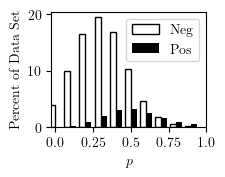


Plot_Prediction()
KBFC_5_Fold_alpha_0_5_gamma_2_0_Hard_Test_Transformed_98
./Images/KBFC_5_Fold_alpha_0_5_gamma_2_0_Hard_Test_Transformed_98_Pred_Wide.png


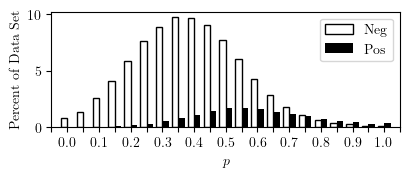


ROC()
KBFC_5_Fold_alpha_0_5_gamma_2_0_Hard_Test_Transformed_98

len(fpr/tpr) =  193782
[[0.         0.        ]
 [0.00055977 0.01000408]
 [0.00055977 0.01005965]
 [0.00056142 0.01005965]
 [0.00056142 0.01007818]
 [0.00056307 0.01007818]
 [0.00056307 0.01013376]
 [0.00056637 0.01013376]
 [0.00056637 0.01014302]
 [0.00056967 0.01014302]]
[[0.         0.        ]
 [0.00055977 0.01000408]
 [0.00055977 0.01005965]
 [0.00056142 0.01005965]
 [0.00056142 0.01007818]
 [0.00056307 0.01007818]
 [0.00056307 0.01013376]
 [0.00056637 0.01013376]
 [0.00056637 0.01014302]
 [0.00056967 0.01014302]]
Unique fpr/tpr =  193782

p_values =  []
./Images/KBFC_5_Fold_alpha_0_5_gamma_2_0_Hard_Test_Transformed_98_ROC.png


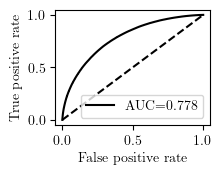


Linear_Transform_y_proba()

a = 0.121, b = 0.608

Analyze_Prediction()
KBFC_5_Fold_alpha_0_5_gamma_2_0_Hard_Test_Transformed_95
Value_Counts_y_proba
713566 663164
627486
Finished
Plot_Prediction()
KBFC_5_Fold_alpha_0_5_gamma_2_0_Hard_Test_Transformed_95
./Images/KBFC_5_Fold_alpha_0_5_gamma_2_0_Hard_Test_Transformed_95_Pred.png


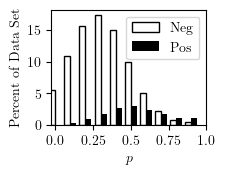


Plot_Prediction()
KBFC_5_Fold_alpha_0_5_gamma_2_0_Hard_Test_Transformed_95
./Images/KBFC_5_Fold_alpha_0_5_gamma_2_0_Hard_Test_Transformed_95_Pred_Wide.png


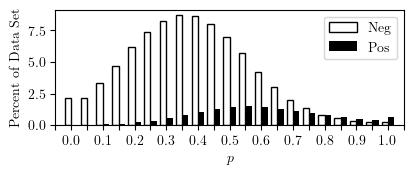


ROC()
KBFC_5_Fold_alpha_0_5_gamma_2_0_Hard_Test_Transformed_95

len(fpr/tpr) =  191396
[[0.         0.        ]
 [0.00151583 0.02500093]
 [0.00151583 0.02501019]
 [0.00151748 0.02501019]
 [0.00151748 0.02504724]
 [0.00151913 0.02504724]
 [0.00151913 0.0250565 ]
 [0.00152078 0.0250565 ]
 [0.00152078 0.02506577]
 [0.00152573 0.02506577]]
[[0.         0.        ]
 [0.00151583 0.02500093]
 [0.00151583 0.02501019]
 [0.00151748 0.02501019]
 [0.00151748 0.02504724]
 [0.00151913 0.02504724]
 [0.00151913 0.0250565 ]
 [0.00152078 0.0250565 ]
 [0.00152078 0.02506577]
 [0.00152573 0.02506577]]
Unique fpr/tpr =  191396

p_values =  []
./Images/KBFC_5_Fold_alpha_0_5_gamma_2_0_Hard_Test_Transformed_95_ROC.png


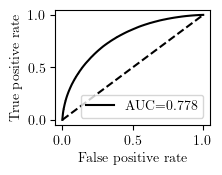




CPU times: user 4h 46min 20s, sys: 7min, total: 4h 53min 21s
Wall time: 4h 33min 18s


In [41]:
%%time
Run_with_Hard_Features()
# CPU times: user 4h 45min 20s, sys: 7min 22s, total: 4h 52min 43s
# Wall time: 4h 30min 47s

Get_Data()
data.shape:  (713566, 78)
End Get_Data()

Feature_Engineering_Cross_Two

Thin_to_Medium_Features()
data.shape:  (713566, 22)
End Thin_to_Medium_Features()

Get_Dummies

p =  5.609785468153692
alpha_balanced =  0.84870915934896

------------------------

BRFC_5_Fold_alpha_0_5_Medium

K-fold iteration =  0
K-fold iteration =  1
K-fold iteration =  2
K-fold iteration =  3
K-fold iteration =  4
Analyze_Prediction()
BRFC_5_Fold_alpha_0_5_Medium_Test
Value_Counts_y_proba
713566 39509
12870
Finished
Plot_Prediction()
BRFC_5_Fold_alpha_0_5_Medium_Test
./Images/BRFC_5_Fold_alpha_0_5_Medium_Test_Pred.png


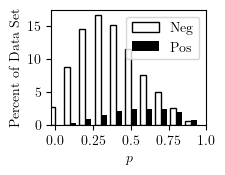


Plot_Prediction()
BRFC_5_Fold_alpha_0_5_Medium_Test
./Images/BRFC_5_Fold_alpha_0_5_Medium_Test_Pred_Wide.png


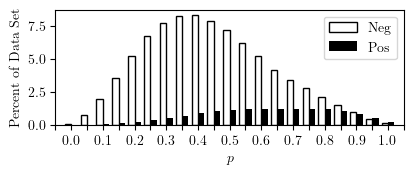


ROC()
BRFC_5_Fold_alpha_0_5_Medium_Test

len(fpr/tpr) =  31688
[[0.         0.        ]
 [0.00009412 0.00150987]
 [0.00009742 0.00150987]
 [0.00009742 0.0015284 ]
 [0.00010072 0.00153766]
 [0.00010733 0.00159324]
 [0.00011063 0.00159324]
 [0.00011063 0.00163029]
 [0.00011393 0.00163029]
 [0.00025924 0.003557  ]]
[[0.         0.        ]
 [0.00009412 0.00150987]
 [0.00009742 0.00150987]
 [0.00009742 0.0015284 ]
 [0.00010072 0.00153766]
 [0.00010733 0.00159324]
 [0.00011063 0.00159324]
 [0.00011063 0.00163029]
 [0.00011393 0.00163029]
 [0.00025924 0.003557  ]]
Unique fpr/tpr =  31688

p_values =  []
./Images/BRFC_5_Fold_alpha_0_5_Medium_Test_ROC.png


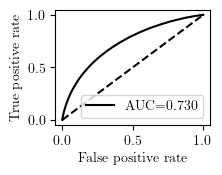


Linear_Transform_y_proba()

a = 0.000, b = 1.000

Analyze_Prediction()
BRFC_5_Fold_alpha_0_5_Medium_Test_Transformed_100
Value_Counts_y_proba
713566 39509
12870
Finished
Plot_Prediction()
BRFC_5_Fold_alpha_0_5_Medium_Test_Transformed_100
./Images/BRFC_5_Fold_alpha_0_5_Medium_Test_Transformed_100_Pred.png


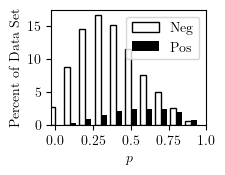


Plot_Prediction()
BRFC_5_Fold_alpha_0_5_Medium_Test_Transformed_100
./Images/BRFC_5_Fold_alpha_0_5_Medium_Test_Transformed_100_Pred_Wide.png


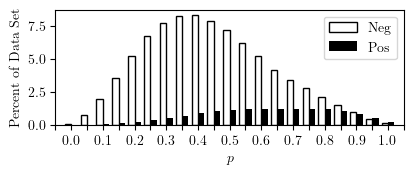


ROC()
BRFC_5_Fold_alpha_0_5_Medium_Test_Transformed_100

len(fpr/tpr) =  31688
[[0.         0.        ]
 [0.00009412 0.00150987]
 [0.00009742 0.00150987]
 [0.00009742 0.0015284 ]
 [0.00010072 0.00153766]
 [0.00010733 0.00159324]
 [0.00011063 0.00159324]
 [0.00011063 0.00163029]
 [0.00011393 0.00163029]
 [0.00025924 0.003557  ]]
[[0.         0.        ]
 [0.00009412 0.00150987]
 [0.00009742 0.00150987]
 [0.00009742 0.0015284 ]
 [0.00010072 0.00153766]
 [0.00010733 0.00159324]
 [0.00011063 0.00159324]
 [0.00011063 0.00163029]
 [0.00011393 0.00163029]
 [0.00025924 0.003557  ]]
Unique fpr/tpr =  31688

p_values =  []
./Images/BRFC_5_Fold_alpha_0_5_Medium_Test_Transformed_100_ROC.png


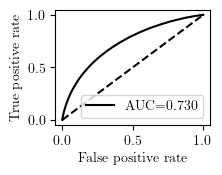


Linear_Transform_y_proba()

a = 0.053, b = 0.969

Analyze_Prediction()
BRFC_5_Fold_alpha_0_5_Medium_Test_Transformed_98
Value_Counts_y_proba
713566 38873
12444
Finished
Plot_Prediction()
BRFC_5_Fold_alpha_0_5_Medium_Test_Transformed_98
./Images/BRFC_5_Fold_alpha_0_5_Medium_Test_Transformed_98_Pred.png


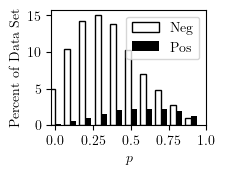


Plot_Prediction()
BRFC_5_Fold_alpha_0_5_Medium_Test_Transformed_98
./Images/BRFC_5_Fold_alpha_0_5_Medium_Test_Transformed_98_Pred_Wide.png


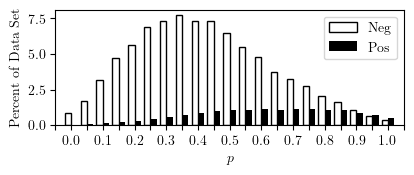


ROC()
BRFC_5_Fold_alpha_0_5_Medium_Test_Transformed_98

len(fpr/tpr) =  31189
[[0.         0.        ]
 [0.00090983 0.01000408]
 [0.00091148 0.01000408]
 [0.00091148 0.0100226 ]
 [0.00091643 0.01003186]
 [0.00091808 0.01003186]
 [0.00091808 0.01004113]
 [0.00091973 0.01004113]
 [0.00092634 0.01008744]
 [0.00092799 0.01008744]]
[[0.         0.        ]
 [0.00090983 0.01000408]
 [0.00091148 0.01000408]
 [0.00091148 0.0100226 ]
 [0.00091643 0.01003186]
 [0.00091808 0.01003186]
 [0.00091808 0.01004113]
 [0.00091973 0.01004113]
 [0.00092634 0.01008744]
 [0.00092799 0.01008744]]
Unique fpr/tpr =  31189

p_values =  []
./Images/BRFC_5_Fold_alpha_0_5_Medium_Test_Transformed_98_ROC.png


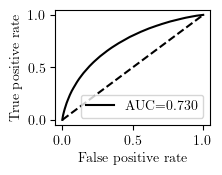


Linear_Transform_y_proba()

a = 0.090, b = 0.938

Analyze_Prediction()
BRFC_5_Fold_alpha_0_5_Medium_Test_Transformed_95
Value_Counts_y_proba
713566 37329
11542
Finished
Plot_Prediction()
BRFC_5_Fold_alpha_0_5_Medium_Test_Transformed_95
./Images/BRFC_5_Fold_alpha_0_5_Medium_Test_Transformed_95_Pred.png


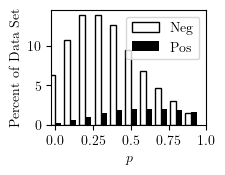


Plot_Prediction()
BRFC_5_Fold_alpha_0_5_Medium_Test_Transformed_95
./Images/BRFC_5_Fold_alpha_0_5_Medium_Test_Transformed_95_Pred_Wide.png


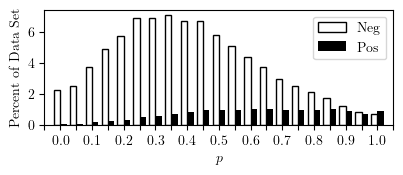


ROC()
BRFC_5_Fold_alpha_0_5_Medium_Test_Transformed_95

len(fpr/tpr) =  30064
[[0.         0.        ]
 [0.00274764 0.02501019]
 [0.00274929 0.02501019]
 [0.00274929 0.02501945]
 [0.0027526  0.02501945]
 [0.00276581 0.02509356]
 [0.00277241 0.02510282]
 [0.00277241 0.02511208]
 [0.00277406 0.02511208]
 [0.00277406 0.02513061]]
[[0.         0.        ]
 [0.00274764 0.02501019]
 [0.00274929 0.02501019]
 [0.00274929 0.02501945]
 [0.0027526  0.02501945]
 [0.00276581 0.02509356]
 [0.00277241 0.02510282]
 [0.00277241 0.02511208]
 [0.00277406 0.02511208]
 [0.00277406 0.02513061]]
Unique fpr/tpr =  30064

p_values =  []
./Images/BRFC_5_Fold_alpha_0_5_Medium_Test_Transformed_95_ROC.png


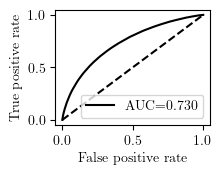





------------------------

BRFC_5_Fold_alpha_balanced_Medium

K-fold iteration =  0
K-fold iteration =  1
K-fold iteration =  2
K-fold iteration =  3
K-fold iteration =  4
Analyze_Prediction()
BRFC_5_Fold_alpha_balanced_Medium_Test
Value_Counts_y_proba
713566 123695
88017
Finished
Plot_Prediction()
BRFC_5_Fold_alpha_balanced_Medium_Test
./Images/BRFC_5_Fold_alpha_balanced_Medium_Test_Pred.png


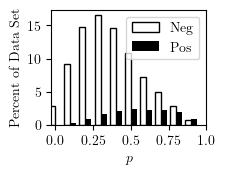


Plot_Prediction()
BRFC_5_Fold_alpha_balanced_Medium_Test
./Images/BRFC_5_Fold_alpha_balanced_Medium_Test_Pred_Wide.png


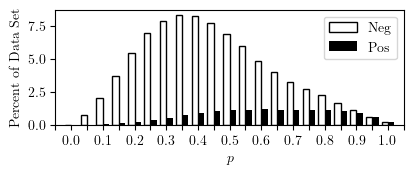


ROC()
BRFC_5_Fold_alpha_balanced_Medium_Test

len(fpr/tpr) =  78850
[[0.         0.        ]
 [0.00009577 0.00134314]
 [0.00009907 0.00134314]
 [0.00010072 0.00137093]
 [0.00010238 0.00137093]
 [0.00010403 0.00138019]
 [0.00011889 0.00144503]
 [0.00011889 0.00146356]
 [0.00012054 0.00146356]
 [0.00012054 0.00147282]]
[[0.         0.        ]
 [0.00009577 0.00134314]
 [0.00009907 0.00134314]
 [0.00010072 0.00137093]
 [0.00010238 0.00137093]
 [0.00010403 0.00138019]
 [0.00011889 0.00144503]
 [0.00011889 0.00146356]
 [0.00012054 0.00146356]
 [0.00012054 0.00147282]]
Unique fpr/tpr =  78850

p_values =  []
./Images/BRFC_5_Fold_alpha_balanced_Medium_Test_ROC.png


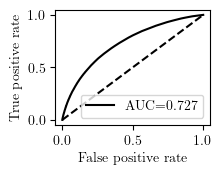


Linear_Transform_y_proba()

a = 0.000, b = 1.000

Analyze_Prediction()
BRFC_5_Fold_alpha_balanced_Medium_Test_Transformed_100
Value_Counts_y_proba
713566 123695
88017
Finished
Plot_Prediction()
BRFC_5_Fold_alpha_balanced_Medium_Test_Transformed_100
./Images/BRFC_5_Fold_alpha_balanced_Medium_Test_Transformed_100_Pred.png


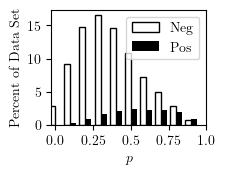


Plot_Prediction()
BRFC_5_Fold_alpha_balanced_Medium_Test_Transformed_100
./Images/BRFC_5_Fold_alpha_balanced_Medium_Test_Transformed_100_Pred_Wide.png


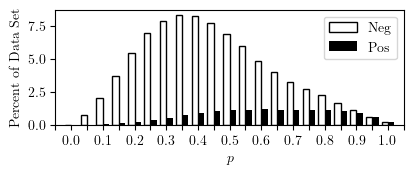


ROC()
BRFC_5_Fold_alpha_balanced_Medium_Test_Transformed_100

len(fpr/tpr) =  78850
[[0.         0.        ]
 [0.00009577 0.00134314]
 [0.00009907 0.00134314]
 [0.00010072 0.00137093]
 [0.00010238 0.00137093]
 [0.00010403 0.00138019]
 [0.00011889 0.00144503]
 [0.00011889 0.00146356]
 [0.00012054 0.00146356]
 [0.00012054 0.00147282]]
[[0.         0.        ]
 [0.00009577 0.00134314]
 [0.00009907 0.00134314]
 [0.00010072 0.00137093]
 [0.00010238 0.00137093]
 [0.00010403 0.00138019]
 [0.00011889 0.00144503]
 [0.00011889 0.00146356]
 [0.00012054 0.00146356]
 [0.00012054 0.00147282]]
Unique fpr/tpr =  78850

p_values =  []
./Images/BRFC_5_Fold_alpha_balanced_Medium_Test_Transformed_100_ROC.png


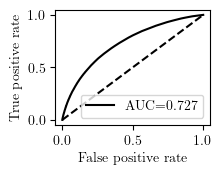


Linear_Transform_y_proba()

a = 0.057, b = 0.970

Analyze_Prediction()
BRFC_5_Fold_alpha_balanced_Medium_Test_Transformed_98
Value_Counts_y_proba
713566 121702
86024
Finished
Plot_Prediction()
BRFC_5_Fold_alpha_balanced_Medium_Test_Transformed_98
./Images/BRFC_5_Fold_alpha_balanced_Medium_Test_Transformed_98_Pred.png


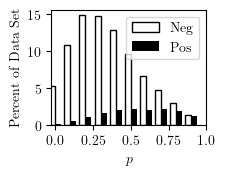


Plot_Prediction()
BRFC_5_Fold_alpha_balanced_Medium_Test_Transformed_98
./Images/BRFC_5_Fold_alpha_balanced_Medium_Test_Transformed_98_Pred_Wide.png


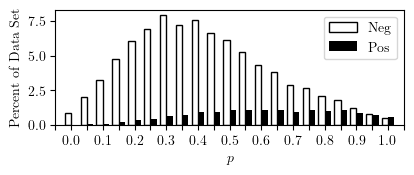


ROC()
BRFC_5_Fold_alpha_balanced_Medium_Test_Transformed_98

len(fpr/tpr) =  77807
[[0.         0.        ]
 [0.00091973 0.00791989]
 [0.00115586 0.0104487 ]
 [0.00115751 0.0104487 ]
 [0.00116081 0.0104487 ]
 [0.00116081 0.01045796]
 [0.00116742 0.01045796]
 [0.00116742 0.01048575]
 [0.00117072 0.01048575]
 [0.00117237 0.01048575]]
[[0.         0.        ]
 [0.00091973 0.00791989]
 [0.00115586 0.0104487 ]
 [0.00115751 0.0104487 ]
 [0.00116081 0.0104487 ]
 [0.00116081 0.01045796]
 [0.00116742 0.01045796]
 [0.00116742 0.01048575]
 [0.00117072 0.01048575]
 [0.00117237 0.01048575]]
Unique fpr/tpr =  77807

p_values =  []
./Images/BRFC_5_Fold_alpha_balanced_Medium_Test_Transformed_98_ROC.png


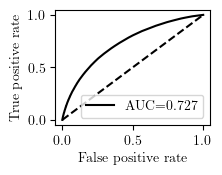


Linear_Transform_y_proba()

a = 0.090, b = 0.940

Analyze_Prediction()
BRFC_5_Fold_alpha_balanced_Medium_Test_Transformed_95
Value_Counts_y_proba
713566 119755
84077
Finished
Plot_Prediction()
BRFC_5_Fold_alpha_balanced_Medium_Test_Transformed_95
./Images/BRFC_5_Fold_alpha_balanced_Medium_Test_Transformed_95_Pred.png


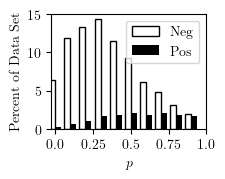


Plot_Prediction()
BRFC_5_Fold_alpha_balanced_Medium_Test_Transformed_95
./Images/BRFC_5_Fold_alpha_balanced_Medium_Test_Transformed_95_Pred_Wide.png


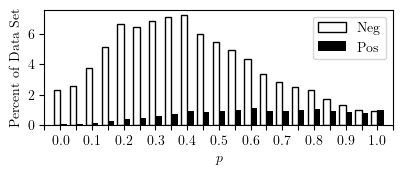


ROC()
BRFC_5_Fold_alpha_balanced_Medium_Test_Transformed_95

len(fpr/tpr) =  76520
[[0.         0.        ]
 [0.00391176 0.02700174]
 [0.00391671 0.02700174]
 [0.00391671 0.027011  ]
 [0.00391836 0.027011  ]
 [0.00391836 0.02702953]
 [0.00392001 0.02702953]
 [0.00392001 0.02706658]
 [0.00392167 0.02706658]
 [0.00392167 0.02707585]]
[[0.         0.        ]
 [0.00391176 0.02700174]
 [0.00391671 0.02700174]
 [0.00391671 0.027011  ]
 [0.00391836 0.027011  ]
 [0.00391836 0.02702953]
 [0.00392001 0.02702953]
 [0.00392001 0.02706658]
 [0.00392167 0.02706658]
 [0.00392167 0.02707585]]
Unique fpr/tpr =  76520

p_values =  []
./Images/BRFC_5_Fold_alpha_balanced_Medium_Test_Transformed_95_ROC.png


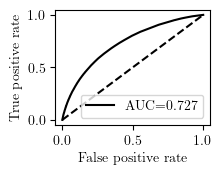





------------------------

LogReg_5_Fold_alpha_0_5_Medium

K-fold iteration =  0
K-fold iteration =  1
K-fold iteration =  2
K-fold iteration =  3
K-fold iteration =  4
Analyze_Prediction()
LogReg_5_Fold_alpha_0_5_Medium_Test
Value_Counts_y_proba
713566 654707
619029
Finished
Plot_Prediction()
LogReg_5_Fold_alpha_0_5_Medium_Test
./Images/LogReg_5_Fold_alpha_0_5_Medium_Test_Pred.png


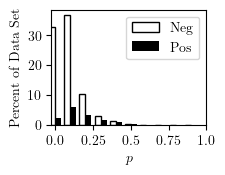


Plot_Prediction()
LogReg_5_Fold_alpha_0_5_Medium_Test
./Images/LogReg_5_Fold_alpha_0_5_Medium_Test_Pred_Wide.png


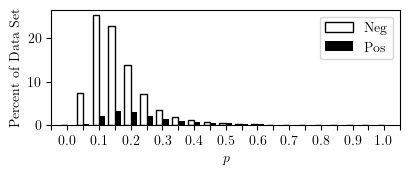


ROC()
LogReg_5_Fold_alpha_0_5_Medium_Test

len(fpr/tpr) =  230679
[[0.         0.        ]
 [0.         0.00000926]
 [0.00000165 0.00000926]
 [0.00000165 0.00003705]
 [0.0000033  0.00003705]
 [0.0000033  0.00006484]
 [0.00000495 0.00006484]
 [0.00000495 0.00012042]
 [0.0000066  0.00012042]
 [0.0000066  0.00013895]]
[[0.         0.        ]
 [0.         0.00000926]
 [0.00000165 0.00000926]
 [0.00000165 0.00003705]
 [0.0000033  0.00003705]
 [0.0000033  0.00006484]
 [0.00000495 0.00006484]
 [0.00000495 0.00012042]
 [0.0000066  0.00012042]
 [0.0000066  0.00013895]]
Unique fpr/tpr =  230679

p_values =  []
./Images/LogReg_5_Fold_alpha_0_5_Medium_Test_ROC.png


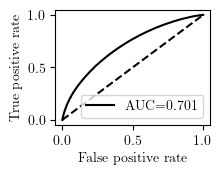


Linear_Transform_y_proba()

a = 0.010, b = 0.825

Analyze_Prediction()
LogReg_5_Fold_alpha_0_5_Medium_Test_Transformed_100
Value_Counts_y_proba
713566 654707
619029
Finished
Plot_Prediction()
LogReg_5_Fold_alpha_0_5_Medium_Test_Transformed_100
./Images/LogReg_5_Fold_alpha_0_5_Medium_Test_Transformed_100_Pred.png


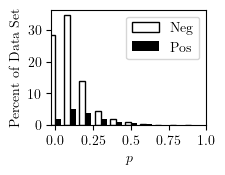


Plot_Prediction()
LogReg_5_Fold_alpha_0_5_Medium_Test_Transformed_100
./Images/LogReg_5_Fold_alpha_0_5_Medium_Test_Transformed_100_Pred_Wide.png


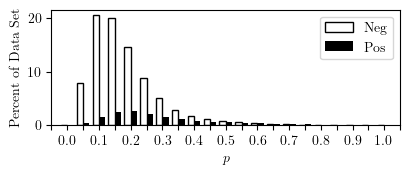


ROC()
LogReg_5_Fold_alpha_0_5_Medium_Test_Transformed_100

len(fpr/tpr) =  230679
[[0.         0.        ]
 [0.         0.00000926]
 [0.00000165 0.00000926]
 [0.00000165 0.00003705]
 [0.0000033  0.00003705]
 [0.0000033  0.00006484]
 [0.00000495 0.00006484]
 [0.00000495 0.00012042]
 [0.0000066  0.00012042]
 [0.0000066  0.00013895]]
[[0.         0.        ]
 [0.         0.00000926]
 [0.00000165 0.00000926]
 [0.00000165 0.00003705]
 [0.0000033  0.00003705]
 [0.0000033  0.00006484]
 [0.00000495 0.00006484]
 [0.00000495 0.00012042]
 [0.0000066  0.00012042]
 [0.0000066  0.00013895]]
Unique fpr/tpr =  230679

p_values =  []
./Images/LogReg_5_Fold_alpha_0_5_Medium_Test_Transformed_100_ROC.png


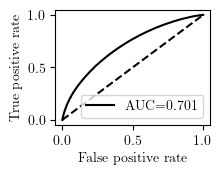


Linear_Transform_y_proba()

a = 0.031, b = 0.595

Analyze_Prediction()
LogReg_5_Fold_alpha_0_5_Medium_Test_Transformed_98
Value_Counts_y_proba
713566 647153
611475
Finished
Plot_Prediction()
LogReg_5_Fold_alpha_0_5_Medium_Test_Transformed_98
./Images/LogReg_5_Fold_alpha_0_5_Medium_Test_Transformed_98_Pred.png


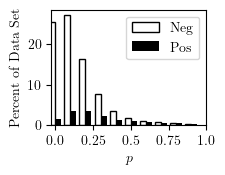


Plot_Prediction()
LogReg_5_Fold_alpha_0_5_Medium_Test_Transformed_98
./Images/LogReg_5_Fold_alpha_0_5_Medium_Test_Transformed_98_Pred_Wide.png


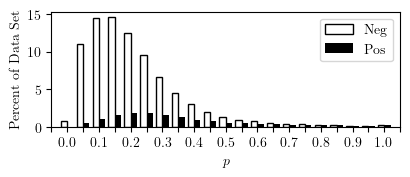


ROC()
LogReg_5_Fold_alpha_0_5_Medium_Test_Transformed_98

len(fpr/tpr) =  228607
[[0.         0.        ]
 [0.00144813 0.01000408]
 [0.00144978 0.01000408]
 [0.00144978 0.01003186]
 [0.00145143 0.01003186]
 [0.00145143 0.01004113]
 [0.00145308 0.01004113]
 [0.00145308 0.01005965]
 [0.00145473 0.01005965]
 [0.00145473 0.01006892]]
[[0.         0.        ]
 [0.00144813 0.01000408]
 [0.00144978 0.01000408]
 [0.00144978 0.01003186]
 [0.00145143 0.01003186]
 [0.00145143 0.01004113]
 [0.00145308 0.01004113]
 [0.00145308 0.01005965]
 [0.00145473 0.01005965]
 [0.00145473 0.01006892]]
Unique fpr/tpr =  228607

p_values =  []
./Images/LogReg_5_Fold_alpha_0_5_Medium_Test_Transformed_98_ROC.png


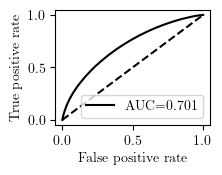


Linear_Transform_y_proba()

a = 0.037, b = 0.539

Analyze_Prediction()
LogReg_5_Fold_alpha_0_5_Medium_Test_Transformed_95
Value_Counts_y_proba
713566 635693
600015
Finished
Plot_Prediction()
LogReg_5_Fold_alpha_0_5_Medium_Test_Transformed_95
./Images/LogReg_5_Fold_alpha_0_5_Medium_Test_Transformed_95_Pred.png


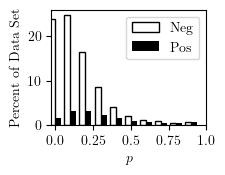


Plot_Prediction()
LogReg_5_Fold_alpha_0_5_Medium_Test_Transformed_95
./Images/LogReg_5_Fold_alpha_0_5_Medium_Test_Transformed_95_Pred_Wide.png


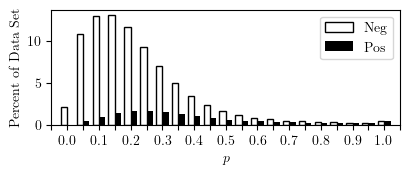


ROC()
LogReg_5_Fold_alpha_0_5_Medium_Test_Transformed_95

len(fpr/tpr) =  225089
[[0.         0.        ]
 [0.00413137 0.02500093]
 [0.00413137 0.02504724]
 [0.00413302 0.02504724]
 [0.00413302 0.0250565 ]
 [0.00413633 0.0250565 ]
 [0.00413633 0.02507503]
 [0.00414458 0.02507503]
 [0.00414458 0.02508429]
 [0.00414623 0.02508429]]
[[0.         0.        ]
 [0.00413137 0.02500093]
 [0.00413137 0.02504724]
 [0.00413302 0.02504724]
 [0.00413302 0.0250565 ]
 [0.00413633 0.0250565 ]
 [0.00413633 0.02507503]
 [0.00414458 0.02507503]
 [0.00414458 0.02508429]
 [0.00414623 0.02508429]]
Unique fpr/tpr =  225089

p_values =  []
./Images/LogReg_5_Fold_alpha_0_5_Medium_Test_Transformed_95_ROC.png


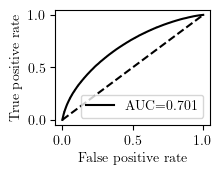





------------------------

LogReg_5_Fold_alpha_balanced_Medium

K-fold iteration =  0
K-fold iteration =  1
K-fold iteration =  2
K-fold iteration =  3
K-fold iteration =  4
Analyze_Prediction()
LogReg_5_Fold_alpha_balanced_Medium_Test
Value_Counts_y_proba
713566 654707
619029
Finished
Plot_Prediction()
LogReg_5_Fold_alpha_balanced_Medium_Test
./Images/LogReg_5_Fold_alpha_balanced_Medium_Test_Pred.png


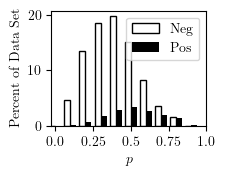


Plot_Prediction()
LogReg_5_Fold_alpha_balanced_Medium_Test
./Images/LogReg_5_Fold_alpha_balanced_Medium_Test_Pred_Wide.png


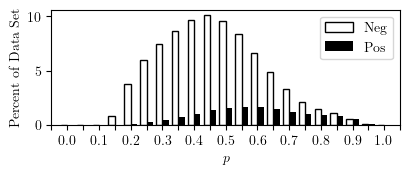


ROC()
LogReg_5_Fold_alpha_balanced_Medium_Test

len(fpr/tpr) =  230499
[[0.         0.        ]
 [0.         0.00000926]
 [0.00000165 0.00000926]
 [0.00000165 0.00003705]
 [0.0000033  0.00003705]
 [0.0000033  0.00005558]
 [0.00000495 0.00005558]
 [0.00000495 0.00006484]
 [0.0000066  0.00006484]
 [0.0000066  0.00013895]]
[[0.         0.        ]
 [0.         0.00000926]
 [0.00000165 0.00000926]
 [0.00000165 0.00003705]
 [0.0000033  0.00003705]
 [0.0000033  0.00005558]
 [0.00000495 0.00005558]
 [0.00000495 0.00006484]
 [0.0000066  0.00006484]
 [0.0000066  0.00013895]]
Unique fpr/tpr =  230499

p_values =  []
./Images/LogReg_5_Fold_alpha_balanced_Medium_Test_ROC.png


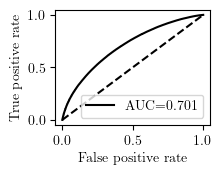


Linear_Transform_y_proba()

a = 0.056, b = 0.964

Analyze_Prediction()
LogReg_5_Fold_alpha_balanced_Medium_Test_Transformed_100
Value_Counts_y_proba
713566 654707
619029
Finished
Plot_Prediction()
LogReg_5_Fold_alpha_balanced_Medium_Test_Transformed_100
./Images/LogReg_5_Fold_alpha_balanced_Medium_Test_Transformed_100_Pred.png


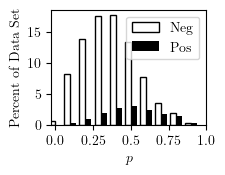


Plot_Prediction()
LogReg_5_Fold_alpha_balanced_Medium_Test_Transformed_100
./Images/LogReg_5_Fold_alpha_balanced_Medium_Test_Transformed_100_Pred_Wide.png


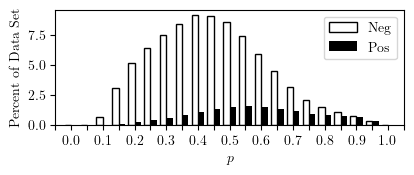


ROC()
LogReg_5_Fold_alpha_balanced_Medium_Test_Transformed_100

len(fpr/tpr) =  230499
[[0.         0.        ]
 [0.         0.00000926]
 [0.00000165 0.00000926]
 [0.00000165 0.00003705]
 [0.0000033  0.00003705]
 [0.0000033  0.00005558]
 [0.00000495 0.00005558]
 [0.00000495 0.00006484]
 [0.0000066  0.00006484]
 [0.0000066  0.00013895]]
[[0.         0.        ]
 [0.         0.00000926]
 [0.00000165 0.00000926]
 [0.00000165 0.00003705]
 [0.0000033  0.00003705]
 [0.0000033  0.00005558]
 [0.00000495 0.00005558]
 [0.00000495 0.00006484]
 [0.0000066  0.00006484]
 [0.0000066  0.00013895]]
Unique fpr/tpr =  230499

p_values =  []
./Images/LogReg_5_Fold_alpha_balanced_Medium_Test_Transformed_100_ROC.png


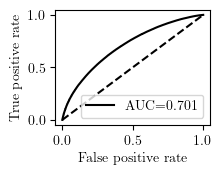


Linear_Transform_y_proba()

a = 0.150, b = 0.896

Analyze_Prediction()
LogReg_5_Fold_alpha_balanced_Medium_Test_Transformed_98
Value_Counts_y_proba
713566 647134
611456
Finished
Plot_Prediction()
LogReg_5_Fold_alpha_balanced_Medium_Test_Transformed_98
./Images/LogReg_5_Fold_alpha_balanced_Medium_Test_Transformed_98_Pred.png


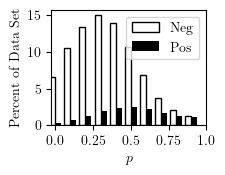


Plot_Prediction()
LogReg_5_Fold_alpha_balanced_Medium_Test_Transformed_98
./Images/LogReg_5_Fold_alpha_balanced_Medium_Test_Transformed_98_Pred_Wide.png


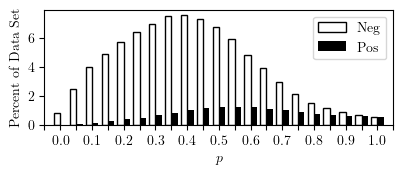


ROC()
LogReg_5_Fold_alpha_balanced_Medium_Test_Transformed_98

len(fpr/tpr) =  228333
[[0.         0.        ]
 [0.00151748 0.01000408]
 [0.00151913 0.01000408]
 [0.00151913 0.01001334]
 [0.00152078 0.01001334]
 [0.00152078 0.0100226 ]
 [0.00152904 0.0100226 ]
 [0.00152904 0.01005039]
 [0.00153234 0.01005039]
 [0.00153234 0.01005965]]
[[0.         0.        ]
 [0.00151748 0.01000408]
 [0.00151913 0.01000408]
 [0.00151913 0.01001334]
 [0.00152078 0.01001334]
 [0.00152078 0.0100226 ]
 [0.00152904 0.0100226 ]
 [0.00152904 0.01005039]
 [0.00153234 0.01005039]
 [0.00153234 0.01005965]]
Unique fpr/tpr =  228333

p_values =  []
./Images/LogReg_5_Fold_alpha_balanced_Medium_Test_Transformed_98_ROC.png


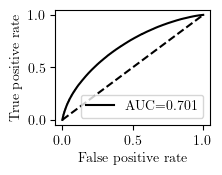


Linear_Transform_y_proba()

a = 0.172, b = 0.872

Analyze_Prediction()
LogReg_5_Fold_alpha_balanced_Medium_Test_Transformed_95
Value_Counts_y_proba
713566 635728
600050
Finished
Plot_Prediction()
LogReg_5_Fold_alpha_balanced_Medium_Test_Transformed_95
./Images/LogReg_5_Fold_alpha_balanced_Medium_Test_Transformed_95_Pred.png


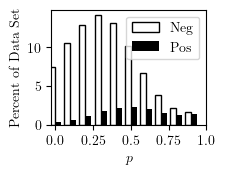


Plot_Prediction()
LogReg_5_Fold_alpha_balanced_Medium_Test_Transformed_95
./Images/LogReg_5_Fold_alpha_balanced_Medium_Test_Transformed_95_Pred_Wide.png


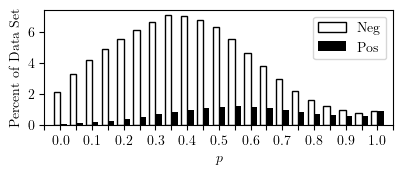


ROC()
LogReg_5_Fold_alpha_balanced_Medium_Test_Transformed_95

len(fpr/tpr) =  224777
[[0.         0.        ]
 [0.00418091 0.02500093]
 [0.00418091 0.02501019]
 [0.00418421 0.02501019]
 [0.00418421 0.02501945]
 [0.00418586 0.02501945]
 [0.00418586 0.02503798]
 [0.00418751 0.02503798]
 [0.00418751 0.02504724]
 [0.00418916 0.02504724]]
[[0.         0.        ]
 [0.00418091 0.02500093]
 [0.00418091 0.02501019]
 [0.00418421 0.02501019]
 [0.00418421 0.02501945]
 [0.00418586 0.02501945]
 [0.00418586 0.02503798]
 [0.00418751 0.02503798]
 [0.00418751 0.02504724]
 [0.00418916 0.02504724]]
Unique fpr/tpr =  224777

p_values =  []
./Images/LogReg_5_Fold_alpha_balanced_Medium_Test_Transformed_95_ROC.png


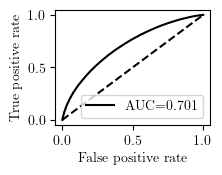





------------------------

AdaBoost_5_Fold_Medium

K-fold iteration =  0
K-fold iteration =  1
K-fold iteration =  2
K-fold iteration =  3
K-fold iteration =  4
Analyze_Prediction()
AdaBoost_5_Fold_Medium_Test
Value_Counts_y_proba
713566 640991
605313
Finished
Plot_Prediction()
AdaBoost_5_Fold_Medium_Test
./Images/AdaBoost_5_Fold_Medium_Test_Pred.png


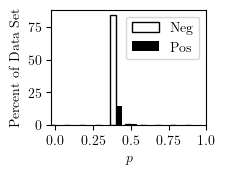


Plot_Prediction()
AdaBoost_5_Fold_Medium_Test
./Images/AdaBoost_5_Fold_Medium_Test_Pred_Wide.png


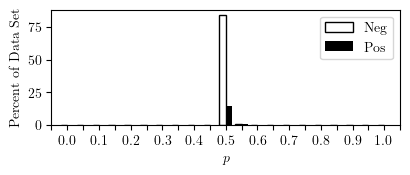


ROC()
AdaBoost_5_Fold_Medium_Test

len(fpr/tpr) =  237872
[[0.         0.        ]
 [0.         0.00000926]
 [0.00000165 0.00000926]
 [0.00000165 0.00004632]
 [0.0000033  0.00004632]
 [0.0000033  0.00008337]
 [0.00000495 0.00008337]
 [0.00000495 0.00009263]
 [0.0000066  0.00009263]
 [0.0000066  0.00012968]]
[[0.         0.        ]
 [0.         0.00000926]
 [0.00000165 0.00000926]
 [0.00000165 0.00004632]
 [0.0000033  0.00004632]
 [0.0000033  0.00008337]
 [0.00000495 0.00008337]
 [0.00000495 0.00009263]
 [0.0000066  0.00009263]
 [0.0000066  0.00012968]]
Unique fpr/tpr =  237872

p_values =  []
./Images/AdaBoost_5_Fold_Medium_Test_ROC.png


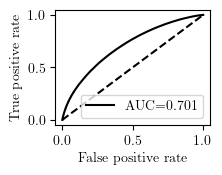


Linear_Transform_y_proba()

a = 0.489, b = 0.504

Analyze_Prediction()
AdaBoost_5_Fold_Medium_Test_Transformed_100
Value_Counts_y_proba
713566 640991
605313
Finished
Plot_Prediction()
AdaBoost_5_Fold_Medium_Test_Transformed_100
./Images/AdaBoost_5_Fold_Medium_Test_Transformed_100_Pred.png


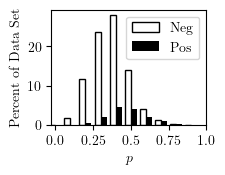


Plot_Prediction()
AdaBoost_5_Fold_Medium_Test_Transformed_100
./Images/AdaBoost_5_Fold_Medium_Test_Transformed_100_Pred_Wide.png


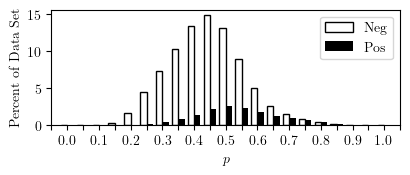


ROC()
AdaBoost_5_Fold_Medium_Test_Transformed_100

len(fpr/tpr) =  237872
[[0.         0.        ]
 [0.         0.00000926]
 [0.00000165 0.00000926]
 [0.00000165 0.00004632]
 [0.0000033  0.00004632]
 [0.0000033  0.00008337]
 [0.00000495 0.00008337]
 [0.00000495 0.00009263]
 [0.0000066  0.00009263]
 [0.0000066  0.00012968]]
[[0.         0.        ]
 [0.         0.00000926]
 [0.00000165 0.00000926]
 [0.00000165 0.00004632]
 [0.0000033  0.00004632]
 [0.0000033  0.00008337]
 [0.00000495 0.00008337]
 [0.00000495 0.00009263]
 [0.0000066  0.00009263]
 [0.0000066  0.00012968]]
Unique fpr/tpr =  237872

p_values =  []
./Images/AdaBoost_5_Fold_Medium_Test_Transformed_100_ROC.png


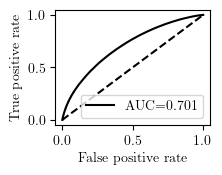


Linear_Transform_y_proba()

a = 0.491, b = 0.501

Analyze_Prediction()
AdaBoost_5_Fold_Medium_Test_Transformed_98
Value_Counts_y_proba
713566 633522
597844
Finished
Plot_Prediction()
AdaBoost_5_Fold_Medium_Test_Transformed_98
./Images/AdaBoost_5_Fold_Medium_Test_Transformed_98_Pred.png


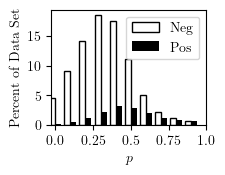


Plot_Prediction()
AdaBoost_5_Fold_Medium_Test_Transformed_98
./Images/AdaBoost_5_Fold_Medium_Test_Transformed_98_Pred_Wide.png


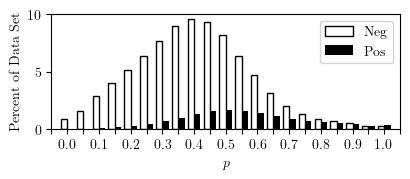


ROC()
AdaBoost_5_Fold_Medium_Test_Transformed_98

len(fpr/tpr) =  235626
[[0.         0.        ]
 [0.0014861  0.01000408]
 [0.0014861  0.01001334]
 [0.0014861  0.01003186]
 [0.0014861  0.01005039]
 [0.00149271 0.01005039]
 [0.00149271 0.01015228]
 [0.00149436 0.01015228]
 [0.00149436 0.01016155]
 [0.00149601 0.01016155]]
[[0.         0.        ]
 [0.0014861  0.01000408]
 [0.0014861  0.01001334]
 [0.0014861  0.01003186]
 [0.0014861  0.01005039]
 [0.00149271 0.01005039]
 [0.00149271 0.01015228]
 [0.00149436 0.01015228]
 [0.00149436 0.01016155]
 [0.00149601 0.01016155]]
Unique fpr/tpr =  235626

p_values =  []
./Images/AdaBoost_5_Fold_Medium_Test_Transformed_98_ROC.png


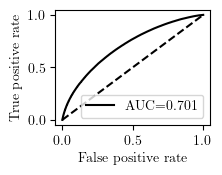


Linear_Transform_y_proba()

a = 0.492, b = 0.500

Analyze_Prediction()
AdaBoost_5_Fold_Medium_Test_Transformed_95
Value_Counts_y_proba
713566 622394
586716
Finished
Plot_Prediction()
AdaBoost_5_Fold_Medium_Test_Transformed_95
./Images/AdaBoost_5_Fold_Medium_Test_Transformed_95_Pred.png


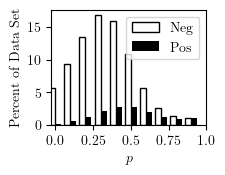


Plot_Prediction()
AdaBoost_5_Fold_Medium_Test_Transformed_95
./Images/AdaBoost_5_Fold_Medium_Test_Transformed_95_Pred_Wide.png


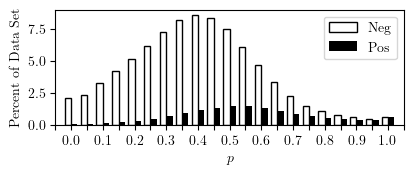


ROC()
AdaBoost_5_Fold_Medium_Test_Transformed_95

len(fpr/tpr) =  231890
[[0.         0.        ]
 [0.00418751 0.02500093]
 [0.00418751 0.02508429]
 [0.00418916 0.02508429]
 [0.00418916 0.02511208]
 [0.00419082 0.02511208]
 [0.00419082 0.02514913]
 [0.00419577 0.02514913]
 [0.00419577 0.02516766]
 [0.00419742 0.02516766]]
[[0.         0.        ]
 [0.00418751 0.02500093]
 [0.00418751 0.02508429]
 [0.00418916 0.02508429]
 [0.00418916 0.02511208]
 [0.00419082 0.02511208]
 [0.00419082 0.02514913]
 [0.00419577 0.02514913]
 [0.00419577 0.02516766]
 [0.00419742 0.02516766]]
Unique fpr/tpr =  231890

p_values =  []
./Images/AdaBoost_5_Fold_Medium_Test_Transformed_95_ROC.png


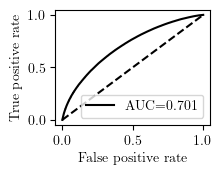





------------------------

BalBag_5_Fold_Medium

K-fold iteration =  0
K-fold iteration =  1
K-fold iteration =  2
K-fold iteration =  3
K-fold iteration =  4
Analyze_Prediction()
BalBag_5_Fold_Medium_Test
Value_Counts_y_proba
713566 2435
59
Finished
Plot_Prediction()
BalBag_5_Fold_Medium_Test
./Images/BalBag_5_Fold_Medium_Test_Pred.png


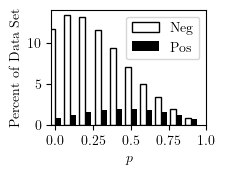


Plot_Prediction()
BalBag_5_Fold_Medium_Test
./Images/BalBag_5_Fold_Medium_Test_Pred_Wide.png


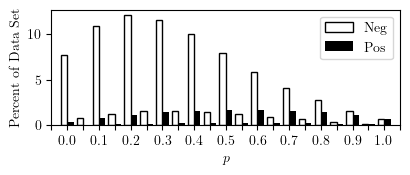


ROC()
BalBag_5_Fold_Medium_Test

len(fpr/tpr) =  2217
[[0.         0.        ]
 [0.00700781 0.04185038]
 [0.00700946 0.04185038]
 [0.00701111 0.04185965]
 [0.00701276 0.04185965]
 [0.00701607 0.04186891]
 [0.00702432 0.04191522]
 [0.007059   0.04198933]
 [0.00708872 0.04205417]
 [0.00710854 0.04208196]]
[[0.         0.        ]
 [0.00700781 0.04185038]
 [0.00700946 0.04185038]
 [0.00701111 0.04185965]
 [0.00701276 0.04185965]
 [0.00701607 0.04186891]
 [0.00702432 0.04191522]
 [0.007059   0.04198933]
 [0.00708872 0.04205417]
 [0.00710854 0.04208196]]
Unique fpr/tpr =  2217

p_values =  []
./Images/BalBag_5_Fold_Medium_Test_ROC.png


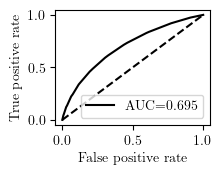


Linear_Transform_y_proba()

a = 0.000, b = 1.000

Analyze_Prediction()
BalBag_5_Fold_Medium_Test_Transformed_100
Value_Counts_y_proba
713566 2435
59
Finished
Plot_Prediction()
BalBag_5_Fold_Medium_Test_Transformed_100
./Images/BalBag_5_Fold_Medium_Test_Transformed_100_Pred.png


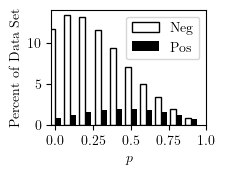


Plot_Prediction()
BalBag_5_Fold_Medium_Test_Transformed_100
./Images/BalBag_5_Fold_Medium_Test_Transformed_100_Pred_Wide.png


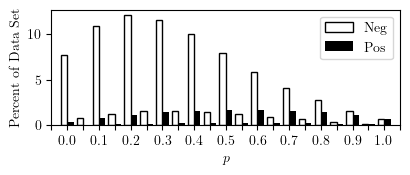


ROC()
BalBag_5_Fold_Medium_Test_Transformed_100

len(fpr/tpr) =  2217
[[0.         0.        ]
 [0.00700781 0.04185038]
 [0.00700946 0.04185038]
 [0.00701111 0.04185965]
 [0.00701276 0.04185965]
 [0.00701607 0.04186891]
 [0.00702432 0.04191522]
 [0.007059   0.04198933]
 [0.00708872 0.04205417]
 [0.00710854 0.04208196]]
[[0.         0.        ]
 [0.00700781 0.04185038]
 [0.00700946 0.04185038]
 [0.00701111 0.04185965]
 [0.00701276 0.04185965]
 [0.00701607 0.04186891]
 [0.00702432 0.04191522]
 [0.007059   0.04198933]
 [0.00708872 0.04205417]
 [0.00710854 0.04208196]]
Unique fpr/tpr =  2217

p_values =  []
./Images/BalBag_5_Fold_Medium_Test_Transformed_100_ROC.png


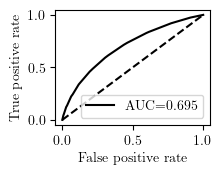


Linear_Transform_y_proba()

a = 0.000, b = 1.000

Analyze_Prediction()
BalBag_5_Fold_Medium_Test_Transformed_98
Value_Counts_y_proba
713566 2435
59
Finished
Plot_Prediction()
BalBag_5_Fold_Medium_Test_Transformed_98
./Images/BalBag_5_Fold_Medium_Test_Transformed_98_Pred.png


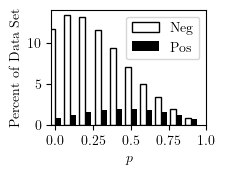


Plot_Prediction()
BalBag_5_Fold_Medium_Test_Transformed_98
./Images/BalBag_5_Fold_Medium_Test_Transformed_98_Pred_Wide.png


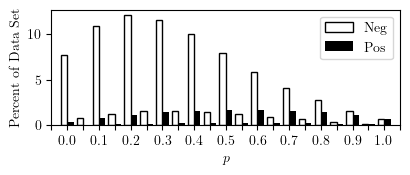


ROC()
BalBag_5_Fold_Medium_Test_Transformed_98

len(fpr/tpr) =  2217
[[0.         0.        ]
 [0.00700781 0.04185038]
 [0.00700946 0.04185038]
 [0.00701111 0.04185965]
 [0.00701276 0.04185965]
 [0.00701607 0.04186891]
 [0.00702432 0.04191522]
 [0.007059   0.04198933]
 [0.00708872 0.04205417]
 [0.00710854 0.04208196]]
[[0.         0.        ]
 [0.00700781 0.04185038]
 [0.00700946 0.04185038]
 [0.00701111 0.04185965]
 [0.00701276 0.04185965]
 [0.00701607 0.04186891]
 [0.00702432 0.04191522]
 [0.007059   0.04198933]
 [0.00708872 0.04205417]
 [0.00710854 0.04208196]]
Unique fpr/tpr =  2217

p_values =  []
./Images/BalBag_5_Fold_Medium_Test_Transformed_98_ROC.png


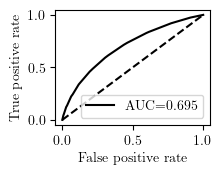


Linear_Transform_y_proba()

a = 0.000, b = 1.000

Analyze_Prediction()
BalBag_5_Fold_Medium_Test_Transformed_95
Value_Counts_y_proba
713566 2435
59
Finished
Plot_Prediction()
BalBag_5_Fold_Medium_Test_Transformed_95
./Images/BalBag_5_Fold_Medium_Test_Transformed_95_Pred.png


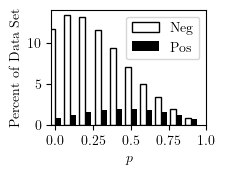


Plot_Prediction()
BalBag_5_Fold_Medium_Test_Transformed_95
./Images/BalBag_5_Fold_Medium_Test_Transformed_95_Pred_Wide.png


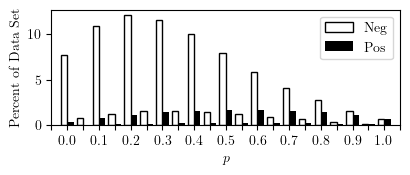


ROC()
BalBag_5_Fold_Medium_Test_Transformed_95

len(fpr/tpr) =  2217
[[0.         0.        ]
 [0.00700781 0.04185038]
 [0.00700946 0.04185038]
 [0.00701111 0.04185965]
 [0.00701276 0.04185965]
 [0.00701607 0.04186891]
 [0.00702432 0.04191522]
 [0.007059   0.04198933]
 [0.00708872 0.04205417]
 [0.00710854 0.04208196]]
[[0.         0.        ]
 [0.00700781 0.04185038]
 [0.00700946 0.04185038]
 [0.00701111 0.04185965]
 [0.00701276 0.04185965]
 [0.00701607 0.04186891]
 [0.00702432 0.04191522]
 [0.007059   0.04198933]
 [0.00708872 0.04205417]
 [0.00710854 0.04208196]]
Unique fpr/tpr =  2217

p_values =  []
./Images/BalBag_5_Fold_Medium_Test_Transformed_95_ROC.png


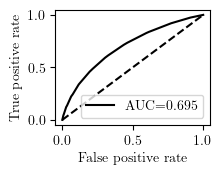





------------------------

EEC_5_Fold_Medium

K-fold iteration =  0
K-fold iteration =  1
K-fold iteration =  2
K-fold iteration =  3
K-fold iteration =  4
Analyze_Prediction()
EEC_5_Fold_Medium_Test
Value_Counts_y_proba
713566 3128
854
Finished
Plot_Prediction()
EEC_5_Fold_Medium_Test
./Images/EEC_5_Fold_Medium_Test_Pred.png


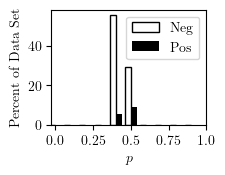


Plot_Prediction()
EEC_5_Fold_Medium_Test
./Images/EEC_5_Fold_Medium_Test_Pred_Wide.png


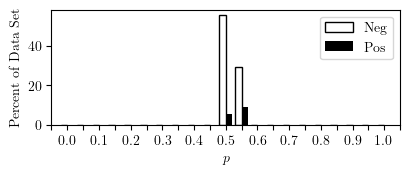


ROC()
EEC_5_Fold_Medium_Test

len(fpr/tpr) =  3086
[[0.         0.        ]
 [0.         0.00000926]
 [0.00000165 0.00000926]
 [0.0000033  0.00002779]
 [0.0000033  0.00003705]
 [0.00000495 0.00003705]
 [0.00000495 0.00005558]
 [0.0000066  0.00005558]
 [0.0000066  0.0000741 ]
 [0.00000826 0.0000741 ]]
[[0.         0.        ]
 [0.         0.00000926]
 [0.00000165 0.00000926]
 [0.0000033  0.00002779]
 [0.0000033  0.00003705]
 [0.00000495 0.00003705]
 [0.00000495 0.00005558]
 [0.0000066  0.00005558]
 [0.0000066  0.0000741 ]
 [0.00000826 0.0000741 ]]
Unique fpr/tpr =  3086

p_values =  []
./Images/EEC_5_Fold_Medium_Test_ROC.png


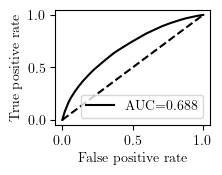


Linear_Transform_y_proba()

a = 0.454, b = 0.571

Analyze_Prediction()
EEC_5_Fold_Medium_Test_Transformed_100
Value_Counts_y_proba
713566 3128
854
Finished
Plot_Prediction()
EEC_5_Fold_Medium_Test_Transformed_100
./Images/EEC_5_Fold_Medium_Test_Transformed_100_Pred.png


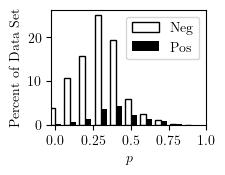


Plot_Prediction()
EEC_5_Fold_Medium_Test_Transformed_100
./Images/EEC_5_Fold_Medium_Test_Transformed_100_Pred_Wide.png


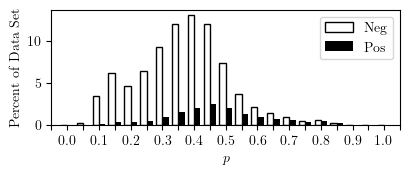


ROC()
EEC_5_Fold_Medium_Test_Transformed_100

len(fpr/tpr) =  3086
[[0.         0.        ]
 [0.         0.00000926]
 [0.00000165 0.00000926]
 [0.0000033  0.00002779]
 [0.0000033  0.00003705]
 [0.00000495 0.00003705]
 [0.00000495 0.00005558]
 [0.0000066  0.00005558]
 [0.0000066  0.0000741 ]
 [0.00000826 0.0000741 ]]
[[0.         0.        ]
 [0.         0.00000926]
 [0.00000165 0.00000926]
 [0.0000033  0.00002779]
 [0.0000033  0.00003705]
 [0.00000495 0.00003705]
 [0.00000495 0.00005558]
 [0.0000066  0.00005558]
 [0.0000066  0.0000741 ]
 [0.00000826 0.0000741 ]]
Unique fpr/tpr =  3086

p_values =  []
./Images/EEC_5_Fold_Medium_Test_Transformed_100_ROC.png


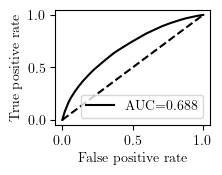


Linear_Transform_y_proba()

a = 0.463, b = 0.550

Analyze_Prediction()
EEC_5_Fold_Medium_Test_Transformed_98
Value_Counts_y_proba
713566 2982
815
Finished
Plot_Prediction()
EEC_5_Fold_Medium_Test_Transformed_98
./Images/EEC_5_Fold_Medium_Test_Transformed_98_Pred.png


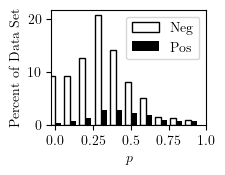


Plot_Prediction()
EEC_5_Fold_Medium_Test_Transformed_98
./Images/EEC_5_Fold_Medium_Test_Transformed_98_Pred_Wide.png


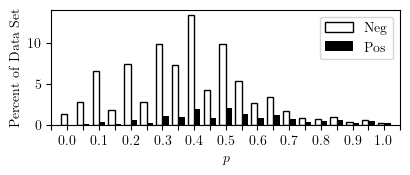


ROC()
EEC_5_Fold_Medium_Test_Transformed_98

len(fpr/tpr) =  2942
[[0.         0.        ]
 [0.00179488 0.01018007]
 [0.00179654 0.01018934]
 [0.00179654 0.0101986 ]
 [0.0018147  0.01035607]
 [0.0018147  0.01036533]
 [0.00181635 0.0103746 ]
 [0.001818   0.01039312]
 [0.00186424 0.01057838]
 [0.00186589 0.01057838]]
[[0.         0.        ]
 [0.00179488 0.01018007]
 [0.00179654 0.01018934]
 [0.00179654 0.0101986 ]
 [0.0018147  0.01035607]
 [0.0018147  0.01036533]
 [0.00181635 0.0103746 ]
 [0.001818   0.01039312]
 [0.00186424 0.01057838]
 [0.00186589 0.01057838]]
Unique fpr/tpr =  2942

p_values =  []
./Images/EEC_5_Fold_Medium_Test_Transformed_98_ROC.png


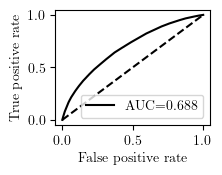


Linear_Transform_y_proba()

a = 0.463, b = 0.544

Analyze_Prediction()
EEC_5_Fold_Medium_Test_Transformed_95
Value_Counts_y_proba
713566 2873
784
Finished
Plot_Prediction()
EEC_5_Fold_Medium_Test_Transformed_95
./Images/EEC_5_Fold_Medium_Test_Transformed_95_Pred.png


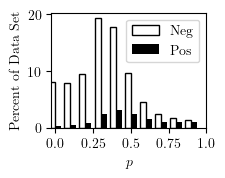


Plot_Prediction()
EEC_5_Fold_Medium_Test_Transformed_95
./Images/EEC_5_Fold_Medium_Test_Transformed_95_Pred_Wide.png


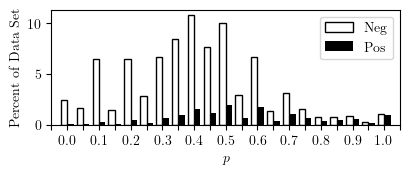


ROC()
EEC_5_Fold_Medium_Test_Transformed_95

len(fpr/tpr) =  2836
[[0.         0.        ]
 [0.00505441 0.02549187]
 [0.00507918 0.02567713]
 [0.00508743 0.02570492]
 [0.00508908 0.02571418]
 [0.00509404 0.02573271]
 [0.00562243 0.02788173]
 [0.00562904 0.02790026]
 [0.00567527 0.02809478]
 [0.00567692 0.02811331]]
[[0.         0.        ]
 [0.00505441 0.02549187]
 [0.00507918 0.02567713]
 [0.00508743 0.02570492]
 [0.00508908 0.02571418]
 [0.00509404 0.02573271]
 [0.00562243 0.02788173]
 [0.00562904 0.02790026]
 [0.00567527 0.02809478]
 [0.00567692 0.02811331]]
Unique fpr/tpr =  2836

p_values =  []
./Images/EEC_5_Fold_Medium_Test_Transformed_95_ROC.png


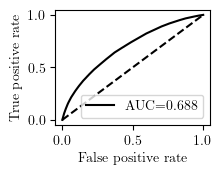





------------------------

RUSBoost_5_Fold_Medium

K-fold iteration =  0
K-fold iteration =  1
K-fold iteration =  2
K-fold iteration =  3
K-fold iteration =  4
Analyze_Prediction()
RUSBoost_5_Fold_Medium_Test
Value_Counts_y_proba
713566 654707
619029
Finished
Plot_Prediction()
RUSBoost_5_Fold_Medium_Test
./Images/RUSBoost_5_Fold_Medium_Test_Pred.png


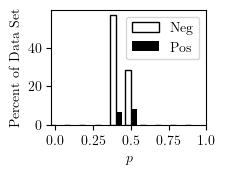


Plot_Prediction()
RUSBoost_5_Fold_Medium_Test
./Images/RUSBoost_5_Fold_Medium_Test_Pred_Wide.png


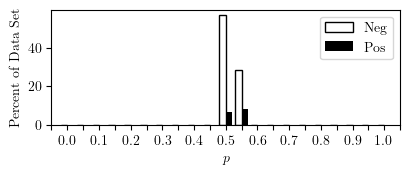


ROC()
RUSBoost_5_Fold_Medium_Test

len(fpr/tpr) =  236647
[[0.         0.        ]
 [0.00000165 0.        ]
 [0.0000066  0.        ]
 [0.0000066  0.00000926]
 [0.00002312 0.00000926]
 [0.00002642 0.00000926]
 [0.00002642 0.00002779]
 [0.00004128 0.00002779]
 [0.00004128 0.00003705]
 [0.00004623 0.00003705]]
[[0.         0.        ]
 [0.00000165 0.        ]
 [0.0000066  0.        ]
 [0.0000066  0.00000926]
 [0.00002312 0.00000926]
 [0.00002642 0.00000926]
 [0.00002642 0.00002779]
 [0.00004128 0.00002779]
 [0.00004128 0.00003705]
 [0.00004623 0.00003705]]
Unique fpr/tpr =  236647

p_values =  []
./Images/RUSBoost_5_Fold_Medium_Test_ROC.png


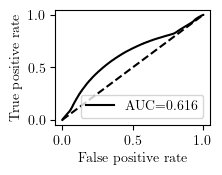


Linear_Transform_y_proba()

a = 0.493, b = 0.510

Analyze_Prediction()
RUSBoost_5_Fold_Medium_Test_Transformed_100
Value_Counts_y_proba
713566 654704
619026
Finished
Plot_Prediction()
RUSBoost_5_Fold_Medium_Test_Transformed_100
./Images/RUSBoost_5_Fold_Medium_Test_Transformed_100_Pred.png


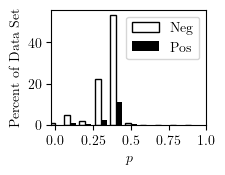


Plot_Prediction()
RUSBoost_5_Fold_Medium_Test_Transformed_100
./Images/RUSBoost_5_Fold_Medium_Test_Transformed_100_Pred_Wide.png


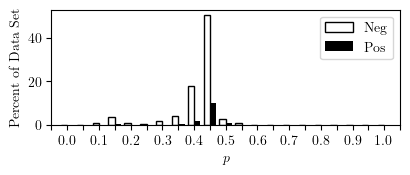


ROC()
RUSBoost_5_Fold_Medium_Test_Transformed_100

len(fpr/tpr) =  236646
[[0.         0.        ]
 [0.0000066  0.        ]
 [0.0000066  0.00000926]
 [0.00002312 0.00000926]
 [0.00002642 0.00000926]
 [0.00002642 0.00002779]
 [0.00004128 0.00002779]
 [0.00004128 0.00003705]
 [0.00004623 0.00003705]
 [0.00004623 0.00005558]]
[[0.         0.        ]
 [0.0000066  0.        ]
 [0.0000066  0.00000926]
 [0.00002312 0.00000926]
 [0.00002642 0.00000926]
 [0.00002642 0.00002779]
 [0.00004128 0.00002779]
 [0.00004128 0.00003705]
 [0.00004623 0.00003705]
 [0.00004623 0.00005558]]
Unique fpr/tpr =  236646

p_values =  []
./Images/RUSBoost_5_Fold_Medium_Test_Transformed_100_ROC.png


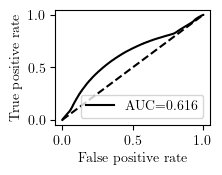


Linear_Transform_y_proba()

a = 0.494, b = 0.502

Analyze_Prediction()
RUSBoost_5_Fold_Medium_Test_Transformed_98
Value_Counts_y_proba
713566 644369
608691
Finished
Plot_Prediction()
RUSBoost_5_Fold_Medium_Test_Transformed_98
./Images/RUSBoost_5_Fold_Medium_Test_Transformed_98_Pred.png


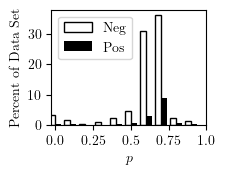


Plot_Prediction()
RUSBoost_5_Fold_Medium_Test_Transformed_98
./Images/RUSBoost_5_Fold_Medium_Test_Transformed_98_Pred_Wide.png


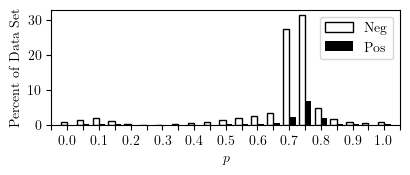


ROC()
RUSBoost_5_Fold_Medium_Test_Transformed_98

len(fpr/tpr) =  233157
[[0.         0.        ]
 [0.00531365 0.01000408]
 [0.00531365 0.01001334]
 [0.00533181 0.01001334]
 [0.00533347 0.0100226 ]
 [0.00533677 0.0100226 ]
 [0.00533677 0.01003186]
 [0.00534337 0.01003186]
 [0.00534337 0.01004113]
 [0.00535163 0.01004113]]
[[0.         0.        ]
 [0.00531365 0.01000408]
 [0.00531365 0.01001334]
 [0.00533181 0.01001334]
 [0.00533347 0.0100226 ]
 [0.00533677 0.0100226 ]
 [0.00533677 0.01003186]
 [0.00534337 0.01003186]
 [0.00534337 0.01004113]
 [0.00535163 0.01004113]]
Unique fpr/tpr =  233157

p_values =  []
./Images/RUSBoost_5_Fold_Medium_Test_Transformed_98_ROC.png


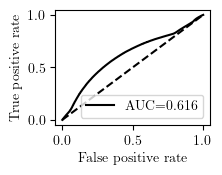


Linear_Transform_y_proba()

a = 0.495, b = 0.502

Analyze_Prediction()
RUSBoost_5_Fold_Medium_Test_Transformed_95
Value_Counts_y_proba
713566 628212
592534
Finished
Plot_Prediction()
RUSBoost_5_Fold_Medium_Test_Transformed_95
./Images/RUSBoost_5_Fold_Medium_Test_Transformed_95_Pred.png


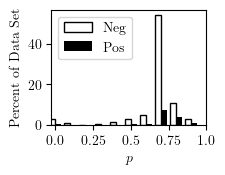


Plot_Prediction()
RUSBoost_5_Fold_Medium_Test_Transformed_95
./Images/RUSBoost_5_Fold_Medium_Test_Transformed_95_Pred_Wide.png


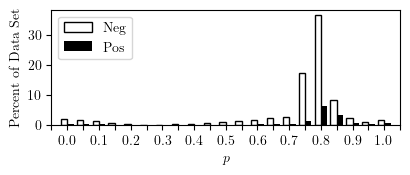


ROC()
RUSBoost_5_Fold_Medium_Test_Transformed_95

len(fpr/tpr) =  227322
[[0.         0.        ]
 [0.01457539 0.02500093]
 [0.01457539 0.02501019]
 [0.01458199 0.02501019]
 [0.01458199 0.02501945]
 [0.01458364 0.02501945]
 [0.01458364 0.02503798]
 [0.0145886  0.02503798]
 [0.0145919  0.02503798]
 [0.0145985  0.02503798]]
[[0.         0.        ]
 [0.01457539 0.02500093]
 [0.01457539 0.02501019]
 [0.01458199 0.02501019]
 [0.01458199 0.02501945]
 [0.01458364 0.02501945]
 [0.01458364 0.02503798]
 [0.0145886  0.02503798]
 [0.0145919  0.02503798]
 [0.0145985  0.02503798]]
Unique fpr/tpr =  227322

p_values =  []
./Images/RUSBoost_5_Fold_Medium_Test_Transformed_95_ROC.png


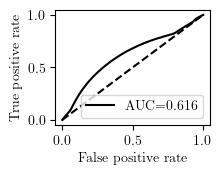





------------------------

KBFC_5_Fold_alpha_0_5_gamma_0_0_Medium



K-fold iteration =  0
len(train_index) =  570852
[     0      2      5 ... 713563 713564 713565]
len(test_index) =  142714
[     1      3      4 ... 713557 713558 713559]

train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SEX_0_x_0,AGE_x_SEX_0_x_1,AGE_x_SEX_1_x_0,AGE_x_SEX_1_x_1,AGE_x_SEX_2_x_0,...,WEATHER_2,WEATHER_3,WEATHER_4,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
6,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
7,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713561,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
713562,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
713563,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
713564,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0



test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SEX_0_x_0,AGE_x_SEX_0_x_1,AGE_x_SEX_1_x_0,AGE_x_SEX_1_x_1,AGE_x_SEX_2_x_0,...,WEATHER_2,WEATHER_3,WEATHER_4,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
14,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
18,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713539,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
713550,0,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
713557,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
713558,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


type(test_fold) =  <class 'pandas.core.frame.DataFrame'>
type(y_test_fold) =  <class 'pandas.core.series.Series'>
len(X_train_fold) =  570852
len(X_test_fold) =  142714
len(y_train_fold) =  570852
len(y_test_fold) =  142714

data.shape =  (713566, 94) 94
X_train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SEX_0_x_0,AGE_x_SEX_0_x_1,AGE_x_SEX_1_x_0,AGE_x_SEX_1_x_1,AGE_x_SEX_2_x_0,...,WEATHER_1,WEATHER_2,WEATHER_3,WEATHER_4,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
0,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
5,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
6,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
7,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


y_train_fold


0    0
2    0
5    0
6    0
7    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_train_fold.value_counts()


0    484488
1     86364
Name: HOSPITAL, dtype: int64

X_test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SEX_0_x_0,AGE_x_SEX_0_x_1,AGE_x_SEX_1_x_0,AGE_x_SEX_1_x_1,AGE_x_SEX_2_x_0,...,WEATHER_1,WEATHER_2,WEATHER_3,WEATHER_4,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021
1,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
14,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
18,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0


y_test_fold


1     0
3     0
4     0
14    0
18    0
Name: HOSPITAL, dtype: category
Categories (2, int64): [0, 1]

y_test_fold.value_counts()


0    121122
1     21592
Name: HOSPITAL, dtype: int64

y_proba_fold
[0.11901341, 0.2070261, 0.032335225, 0.07333722, 0.14223738, 0.10081433, 0.040334545, 0.26154447, 0.107232414, 0.1264091]


K-fold iteration =  1
len(train_index) =  570853
[     0      1      3 ... 713561 713562 713563]
len(test_index) =  142713
[     2      6     35 ... 713556 713564 713565]

train_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SEX_0_x_0,AGE_x_SEX_0_x_1,AGE_x_SEX_1_x_0,AGE_x_SEX_1_x_1,AGE_x_SEX_2_x_0,...,WEATHER_2,WEATHER_3,WEATHER_4,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713559,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
713560,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
713561,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
713562,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0



test_fold


,AGE_0,AGE_1,AGE_2,AGE_3,AGE_4,AGE_x_SEX_0_x_0,AGE_x_SEX_0_x_1,AGE_x_SEX_1_x_0,AGE_x_SEX_1_x_1,AGE_x_SEX_2_x_0,...,WEATHER_2,WEATHER_3,WEATHER_4,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,HOSPITAL
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
6,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
35,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
37,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
38,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713549,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
713552,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
713556,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
713564,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


type(test_fold) =  <class 'pandas.core.frame.DataFrame'>
type(y_test_fold) =  <class 'pandas.core.series.Series'>
len(X_train_fold) =  570853
len(X_test_fold) =  142713
len(y_train_fold) =  570853
len(y_test_fold) =  142713

data.shape =  (713566, 94) 94


KeyboardInterrupt: 

In [42]:
%%time
Run_with_Medium_Features()
# CPU times: user 2h 21min 16s, sys: 3min 36s, total: 2h 24min 52s
# Wall time: 2h 19min 48s

In [ ]:
%%time
Run_with_Easy_Features()
# CPU times: user 2h 2min 53s, sys: 1min 36s, total: 2h 4min 29s
# Wall time: 2h 3min 30s

Get_Data()
data.shape:  (713566, 78)
End Get_Data()

Feature_Engineering_Cross_Two

Thin_to_Easy_Features()
data.shape:  (713566, 10)
End Thin_to_Easy_Features()

Get_Dummies

p =  5.609785468153692
alpha_balanced =  0.84870915934896

------------------------

BRFC_5_Fold_alpha_0_5_Easy

K-fold iteration =  0
